# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


<br>

Let's start with data ingestion.

<br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load each sheet into separate DataFrames
# Define the file path
file_path = 'Dataset2_Needs_fixed.xlsx'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# **Data Exploration**

As for the last business case: I keep it minimalist, for the benefit of brevity, to be able to get to the heart of the problem. But you could/can spend tons of time here in order to **understand the problem and the dataset**.

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [3]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


<br>

We drop ID column as it's not needed for analysis.

<br>

In [4]:
# Fix compatibility issue between newer matplotlib and pandas
import matplotlib as mpl
if hasattr(mpl, 'colormaps') and not hasattr(mpl.colormaps, 'get_cmap'):
    def get_cmap(name):
        return mpl.colormaps[name]
    mpl.colormaps.get_cmap = get_cmap

# Drop ID column and create comprehensive summary
needs_df_no_id = needs_df.drop('ID', axis=1)

# Create enhanced summary statistics
def get_statistics(series):
    stats = {
        'Count': len(series),
        'Unique Values': series.nunique(),
        'Missing Values': series.isnull().sum(),
        'Mean': series.mean(),
        'Median': series.median(),
        'Mode': series.mode().iloc[0] if not series.mode().empty else None,
        'Std Dev': series.std(),
        'Variance': series.var(),
        'Min': series.min(),
        '25th Percentile': series.quantile(0.25),
        '75th Percentile': series.quantile(0.75),
        'Max': series.max(),
        'Range': series.max() - series.min(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Outliers (IQR)': len(series[((series < (series.quantile(0.25) - 1.5 * (series.quantile(0.75) - series.quantile(0.25)))) | 
                                    (series > (series.quantile(0.75) + 1.5 * (series.quantile(0.75) - series.quantile(0.25)))))]),
        'CV': (series.std() / series.mean()) * 100 if series.mean() != 0 else None
    }
    return stats

# Calculate statistics for each column
summary_data = []
for column in needs_df_no_id.columns:
    stats = get_statistics(needs_df_no_id[column])
    stats['Column'] = column
    summary_data.append(stats)

# Create DataFrame with statistics
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Column')

# Round numeric columns to 2 decimal places
numeric_columns = summary_df.select_dtypes(include=[np.number]).columns
summary_df[numeric_columns] = summary_df[numeric_columns].round(2)

# Display the summary table with styling
styled_summary = summary_df.style\
    .format(precision=2)\
    .background_gradient(cmap='YlOrRd', subset=['Missing Values'])\
    .background_gradient(cmap='YlOrRd', subset=['Skewness'])\
    .background_gradient(cmap='YlOrRd', subset=['Kurtosis'])\
    .background_gradient(cmap='YlOrRd', subset=['Outliers (IQR)'])\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption('Enhanced Dataset Summary Statistics (Excluding ID)')

display(styled_summary)

# Print additional insights with better formatting
print("\nKey Insights:")
print("1. Target Variables Distribution:")
income_dist = needs_df_no_id['IncomeInvestment'].value_counts(normalize=True).round(3) * 100
accum_dist = needs_df_no_id['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100
print(f"   - IncomeInvestment:")
print(f"     * Yes: {income_dist[1]:.1f}%")
print(f"     * No:  {income_dist[0]:.1f}%")
print(f"   - AccumulationInvestment:")
print(f"     * Yes: {accum_dist[1]:.1f}%")
print(f"     * No:  {accum_dist[0]:.1f}%")

print("\n2. Feature Characteristics:")
print(f"   - Age Range: {needs_df_no_id['Age'].min()} to {needs_df_no_id['Age'].max()} years")
print(f"   - Wealth Range: {needs_df_no_id['Wealth'].min():.2f} to {needs_df_no_id['Wealth'].max():.2f}")
print(f"   - Family Size: {needs_df_no_id['FamilyMembers'].min()} to {needs_df_no_id['FamilyMembers'].max()} members")

print("\n3. Data Quality:")
print(f"   - Missing Values: {needs_df_no_id.isnull().sum().sum()}")
print(f"   - Duplicate Rows: {needs_df_no_id.duplicated().sum()}")

print("\n4. Distribution Insights:")
for col in needs_df_no_id.select_dtypes(include=[np.number]).columns:
    skew = needs_df_no_id[col].skew()
    kurt = needs_df_no_id[col].kurtosis()
    outliers = summary_df.loc[col, 'Outliers (IQR)']
    print(f"   - {col}:")
    print(f"     * Skewness: {skew:.2f} ({'Right-skewed' if skew > 0 else 'Left-skewed' if skew < 0 else 'Symmetric'})")
    print(f"     * Kurtosis: {kurt:.2f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-like'})")
    print(f"     * Outliers: {outliers} ({outliers/len(needs_df_no_id)*100:.1f}% of data)")


Key Insights:
1. Target Variables Distribution:
   - IncomeInvestment:
     * Yes: 38.4%
     * No:  61.6%
   - AccumulationInvestment:
     * Yes: 51.3%
     * No:  48.7%

2. Feature Characteristics:
   - Age Range: 18 to 97 years
   - Wealth Range: 1.06 to 2233.23
   - Family Size: 1 to 5 members

3. Data Quality:
   - Missing Values: 0
   - Duplicate Rows: 0

4. Distribution Insights:
   - Age:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.03 (Light-tailed)
     * Outliers: 29 (0.6% of data)
   - Gender:
     * Skewness: 0.03 (Right-skewed)
     * Kurtosis: -2.00 (Light-tailed)
     * Outliers: 0 (0.0% of data)
   - FamilyMembers:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.21 (Light-tailed)
     * Outliers: 11 (0.2% of data)
   - FinancialEducation:
     * Skewness: 0.15 (Right-skewed)
     * Kurtosis: -0.42 (Light-tailed)
     * Outliers: 8 (0.2% of data)
   - RiskPropensity:
     * Skewness: 0.33 (Right-skewed)
     * Kurtosis: -0.35 (Light-tailed)
     *

In [5]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:



PRODUCTS VARIABLES SUMMARY:


<br>

## Data Transformation and Exploratory Analysis

### 1. Initial setup
* Import required libraries (seaborn, matplotlib, etc).
* Create utility function for histogram plotting.

### 2. Target variables analysis: are they imbalanced?
* Visualize distribution of Income Investment needs.
* Visualize distribution of Accumulation Investment needs.
* Assess class balance for both target variables.

### 3. Wealth variable transformation analysis: is it too fat-tailed?
Display the fat-tailed shape of the Wealth variable, and effect of a couple of reasonable transformations on the Wealth variable. We examine three versions of the Wealth variable:
* Original Wealth distribution.
* Log transformation.
* Power transformation (0.1 power).
* Evaluate which transformation better normalizes the distribution, identifying the most appropriate transformation for leptokurtic, skewed wealth data.

### 4. Some feature engineering and scaling
* Apply log transformation to Wealth and Income.
* Normalize selected variables using MinMaxScaler.
* Create a standardized feature set for modeling.

### 5. Multivariate analysis
* Generate a correlation matrix heatmap for all numeric variables.
* Create pairwise relationships visualization.
* Examine relationships between transformed variables and target variables.

<br>


In [6]:
# =====================================================================================
# BASELINE DATASET SETUP
# =====================================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Start with dataset that already has ID removed
baseline_df = needs_df_no_id.copy()
baseline_log_df = needs_df_no_id.copy()

# Log transform highly skewed financial variables
baseline_log_df['Wealth_log'] = np.log1p(baseline_df['Wealth'])
baseline_log_df = baseline_log_df.drop('Wealth', axis=1)

baseline_log_df['Income_log'] = np.log1p(baseline_df['Income'])
baseline_log_df = baseline_log_df.drop('Income', axis=1)

# Scale all numeric features
baseline_scaler = MinMaxScaler()
# Define numeric columns explicitly
baseline_to_scale_columns = [
    'Age', 
    'Wealth', 
    'Income', 
    'FamilyMembers', 
    'Gender'
]

baseline_log_to_scale_columns = [
    'Age',
    'FamilyMembers',
    'Gender',
    'Wealth_log',  # Log-transformed column we created
    'Income_log'   # Log-transformed column we created
]

# Apply scaling only to these specific numeric columns
baseline_df[baseline_to_scale_columns] = baseline_scaler.fit_transform(baseline_df[baseline_to_scale_columns])
baseline_log_df[baseline_log_to_scale_columns] = baseline_scaler.fit_transform(baseline_log_df[baseline_log_to_scale_columns])

# Split into features and targets
baseline_X = baseline_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_y_income = baseline_df['IncomeInvestment']
baseline_y_accum = baseline_df['AccumulationInvestment']

baseline_log_X = baseline_log_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_log_y_income = baseline_log_df['IncomeInvestment']
baseline_log_y_accum = baseline_log_df['AccumulationInvestment']

# =====================================================================================
# FEATURE-ENGINEERED DATASET
# =====================================================================================

# 1. CREATE BASE DATASET
# ----------------------
engineered_df = needs_df_no_id.copy()

# Extract target variables
y_income = engineered_df['IncomeInvestment']
y_accum = engineered_df['AccumulationInvestment']

# Add interaction feature if targets are correlated
target_correlation = np.corrcoef(y_income, y_accum)[0, 1]
if abs(target_correlation) > 0.2:
    engineered_df['Combined_Investment_Score'] = y_income + y_accum


# 2. CREATE BASIC FINANCIAL RATIO FEATURES
# ----------------------------------------
engineered_df['Wealth_to_Income'] = engineered_df['Wealth'] / engineered_df['Income']
engineered_df['Financial_Capacity'] = engineered_df['Income'] + (engineered_df['Wealth'] * 0.05)
engineered_df['Wealth_Per_Family_Size'] = engineered_df['Wealth'] / engineered_df['FamilyMembers']
engineered_df['Income_Per_Family_Size'] = engineered_df['Income'] / engineered_df['FamilyMembers']


# 3. CREATE INTERACTION FEATURES
# -----------------------------
engineered_df['Age_Risk_Interaction'] = engineered_df['Age'] * engineered_df['RiskPropensity']
engineered_df['Education_Risk_Profile'] = engineered_df['FinancialEducation'] * engineered_df['RiskPropensity']
engineered_df['Age_Squared'] = engineered_df['Age'] ** 2
engineered_df['Gender_Age_Risk'] = engineered_df['Gender'] * engineered_df['Age'] * engineered_df['RiskPropensity']


# 4. CREATE FINANCIAL INSIGHT FEATURES
# -----------------------------------
# Risk and capacity metrics
engineered_df['Risk_Capacity'] = engineered_df['Wealth'] / (engineered_df['Age'] + 1)
engineered_df['Life_Stage_Adjusted_Income'] = engineered_df['Income'] / (engineered_df['Age'] / 20)
engineered_df['Financial_Sophistication'] = (engineered_df['FinancialEducation'] * 
                                           engineered_df['Wealth_to_Income'] * 
                                           engineered_df['RiskPropensity'])

# Retirement and financial independence metrics
engineered_df['Retirement_Readiness'] = engineered_df['Wealth'] / ((engineered_df['Income'] * 0.7) * np.maximum(1, 65 - engineered_df['Age']))
engineered_df['Financial_Independence_Score'] = engineered_df['Wealth'] / (engineered_df['Income'] * 25)

# Risk and volatility metrics
engineered_df['Wealth_Concentration'] = engineered_df['Wealth'] / (engineered_df['Income'] * engineered_df['Age']/10)
engineered_df['Financial_Fragility'] = engineered_df['Income_Per_Family_Size'] / (engineered_df['FinancialEducation'] * engineered_df['RiskPropensity'])


# 5. APPLY MATHEMATICAL TRANSFORMATIONS
# -----------------------------------
# Non-linear transformations
engineered_df['RiskPropensity_Squared'] = engineered_df['RiskPropensity'] ** 2
engineered_df['FinancialEducation_Squared'] = engineered_df['FinancialEducation'] ** 2
engineered_df['Wealth_Sqrt'] = np.sqrt(engineered_df['Wealth'])
engineered_df['Income_Cbrt'] = np.cbrt(engineered_df['Income'])

# Additional composite metrics
engineered_df['Investment_Capacity'] = engineered_df['Income'] * engineered_df['Wealth'] * (1-(engineered_df['FamilyMembers']/6))
engineered_df['Financial_Sophistication_Ratio'] = engineered_df['FinancialEducation'] / engineered_df['Age']


# 6. APPLY LOG TRANSFORMATIONS TO FINANCIAL VARIABLES
# -------------------------------------------------
financial_vars = [
    # Original variables
    'Wealth', 'Income',
    
    # Financial ratios
    'Wealth_to_Income', 'Financial_Capacity',
    'Wealth_Per_Family_Size', 'Income_Per_Family_Size',
    
    # Financial insight metrics
    'Risk_Capacity', 'Life_Stage_Adjusted_Income', 'Financial_Sophistication',
    'Retirement_Readiness', 'Financial_Independence_Score', 
    'Wealth_Concentration', 'Financial_Fragility',
    'Investment_Capacity'
]

# Create log versions of all financial variables
for var in financial_vars:
    engineered_df[f'{var}_log'] = np.log1p(engineered_df[var])


# 7. CATEGORICAL FEATURE ENGINEERING
# --------------------------------
# Create life stage categories
engineered_df['Life_Stage'] = pd.cut(
    engineered_df['Age'], 
    bins=[0, 30, 50, 65, 100],
    labels=['Young', 'Middle', 'Pre-retirement', 'Retirement']
)

# One-hot encode categorical variables
engineered_df = pd.get_dummies(engineered_df, columns=['Life_Stage'], prefix=['life'])

# Convert life stage columns from boolean to integers (0/1)
life_stage_columns = ['life_Young', 'life_Middle', 'life_Pre-retirement', 'life_Retirement']
for col in life_stage_columns:
    if col in engineered_df.columns:
        engineered_df[col] = engineered_df[col].astype(int)

# Create life-stage specific features
engineered_df['Family_Pressure'] = engineered_df['FamilyMembers'] * (
    engineered_df['life_Young'] * 0.5 + 
    engineered_df['life_Middle'] * 1.0 + 
    engineered_df['life_Pre-retirement'] * 1.0 + 
    engineered_df['life_Retirement'] * 0.3
)


# 8. NORMALIZE/SCALE ALL NUMERICAL FEATURES
# ---------------------------------------
# Get all numeric columns
numeric_features = engineered_df.select_dtypes(include=['float64', 'int64']).columns

# Initialize and apply scaler
engineered_scaler = MinMaxScaler()
engineered_df[numeric_features] = engineered_scaler.fit_transform(engineered_df[numeric_features])


# 9. FEATURE SELECTION - REMOVE HIGHLY CORRELATED FEATURES
# -----------------------------------------------------
# First, ensure we keep log versions of all financial variables
# by forcing removal of all original versions
to_drop = set()

# ALWAYS drop all original financial variables
for var in financial_vars:
    if var in engineered_df.columns:
        to_drop.add(var)

print(f"Dropping {len(to_drop)} original financial variables")

# Calculate correlation with target variables
income_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                           .apply(lambda x: x.corr(engineered_df['IncomeInvestment']))
accum_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                          .apply(lambda x: x.corr(engineered_df['AccumulationInvestment']))

# Get feature correlations
feature_cols = engineered_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
corr_matrix = engineered_df[feature_cols].corr().abs()

# Find highly correlated pairs (correlation > 0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*np.where(upper_tri > 0.9))]

# Filter out pairs where one member is already in to_drop
filtered_pairs = []
for var1, var2, corr in high_corr_pairs:
    if var1 not in to_drop and var2 not in to_drop:
        filtered_pairs.append((var1, var2, corr))

print(f"Found {len(filtered_pairs)} remaining highly correlated feature pairs")

# For remaining highly correlated pairs, keep feature with higher correlation to targets
for var1, var2, _ in filtered_pairs:
    # Keep feature with higher correlation to targets
    var1_max_corr = max(abs(income_corr.get(var1, 0)), abs(accum_corr.get(var1, 0)))
    var2_max_corr = max(abs(income_corr.get(var2, 0)), abs(accum_corr.get(var2, 0)))
    
    if var1_max_corr >= var2_max_corr:
        to_drop.add(var2)  # Drop var2 if var1 has higher correlation
    else:
        to_drop.add(var1)  # Drop var1 if var2 has higher correlation

# Create final dataset by dropping highly correlated features
engineered_df = engineered_df.drop(to_drop, axis=1)

# Print summary of features kept
print(f"Dropped {len(to_drop)} features in total")
n_log_features = sum('_log' in col for col in engineered_df.columns)
print(f"Kept {n_log_features} log-transformed financial features")
print(f"Total features in final dataset: {len(engineered_df.columns)}")


# 10. PREPARE FINAL FEATURES AND TARGETS
# -------------------------------------
# Split into features and targets
engineered_X = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
engineered_y_income = engineered_df['IncomeInvestment']
engineered_y_accum = engineered_df['AccumulationInvestment']

# =====================================================================================
# PRINT FINAL DATAFRAME PREVIEWS WITH ENHANCED FORMATTING
# =====================================================================================
from IPython.display import display, HTML

# =====================================================================================
# PRINT FINAL DATAFRAME PREVIEWS WITH ENHANCED TABLE FORMATTING
# =====================================================================================
print("\n\n# =====================================================================================")
print("# FINAL DATAFRAME PREVIEWS")
print("# =====================================================================================")

# Try to use IPython display if available (much better formatting in Jupyter)
try:
    from IPython.display import display, HTML
    
    # Display baseline DataFrame as a styled table
    print("\nBaseline DataFrame (First 5 rows):")
    display(baseline_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))
    
    # Display baseline log DataFrame as a styled table
    print("\nBaseline Log-Transformed DataFrame (First 5 rows):")
    display(baseline_log_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))
    
    # Display engineered DataFrame as a styled table
    print("\nEngineered DataFrame (First 5 rows):")
    display(engineered_df.head().style
            .set_table_styles([
                {'selector': 'th', 'props': [('font-weight', 'bold'),
                                            ('border', '1px solid black')]},
                {'selector': 'td', 'props': [('border', '1px solid #cccccc')]},
            ])
            .format(precision=3))

# Fallback to regular pandas formatting if IPython is not available
except ImportError:
    # Set pandas display options for better table formatting
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.width', 1000)
    pd.set_option('display.precision', 3)
    pd.set_option('display.colheader_justify', 'center')
    
    # Print DataFrame previews with separator lines
    print("\nBaseline DataFrame (First 5 rows):")
    print("═" * 100)
    print(baseline_df.head())
    print("═" * 100)
    
    print("\nBaseline Log-Transformed DataFrame (First 5 rows):")
    print("═" * 100)
    print(baseline_log_df.head())
    print("═" * 100)
    
    print("\nEngineered DataFrame (First 5 rows):")
    print("═" * 100)
    print(engineered_df.head())
    print("═" * 100)
    
    # Reset display options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.precision')
    pd.reset_option('display.colheader_justify')

Dropping 14 original financial variables
Found 22 remaining highly correlated feature pairs
Dropped 28 features in total
Kept 5 log-transformed financial features
Total features in final dataset: 21


# =====================================================================================
# FINAL DATAFRAME PREVIEWS
# =====================================================================================

Baseline DataFrame (First 5 rows):



Baseline Log-Transformed DataFrame (First 5 rows):



Engineered DataFrame (First 5 rows):



===== DATAFRAME ANALYSIS =====

Baseline DataFrame:
  Shape: (5000, 9)
  Columns: 9
  Numeric columns: 9
  Binary columns: 3
  Categorical columns: 0
  Has target variables: Yes

Baseline_Log_Transformed DataFrame:
  Shape: (5000, 9)
  Columns: 9
  Numeric columns: 9
  Binary columns: 3
  Categorical columns: 0
  Has target variables: Yes

Engineered DataFrame:
  Shape: (5000, 21)
  Columns: 21
  Numeric columns: 21
  Binary columns: 7
  Categorical columns: 0
  Has target variables: Yes


===== TARGET DISTRIBUTIONS =====


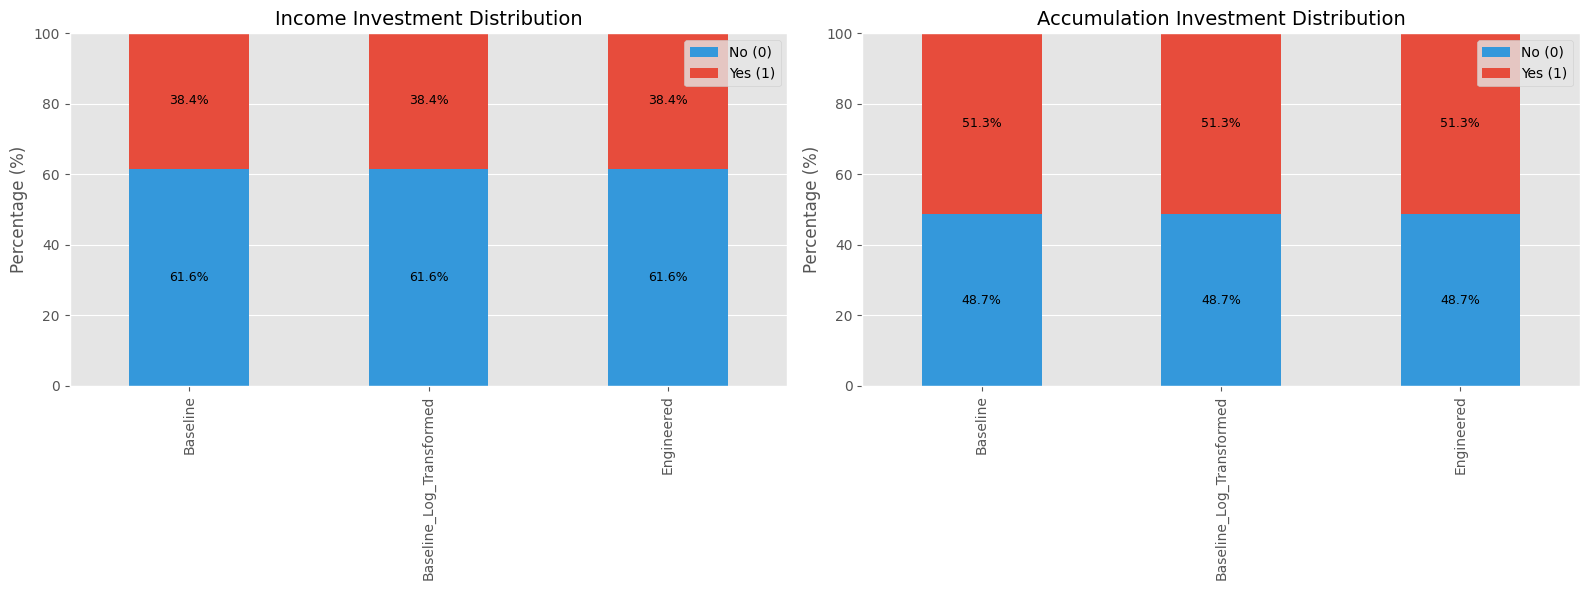

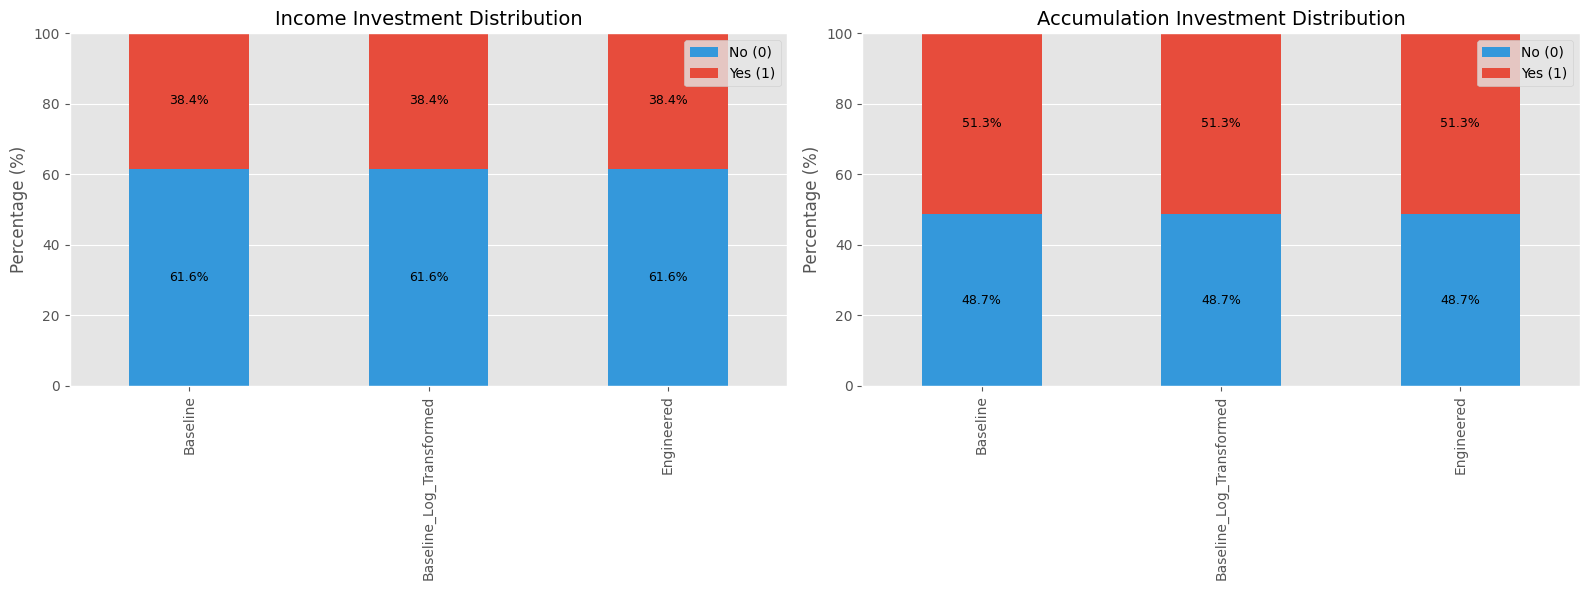

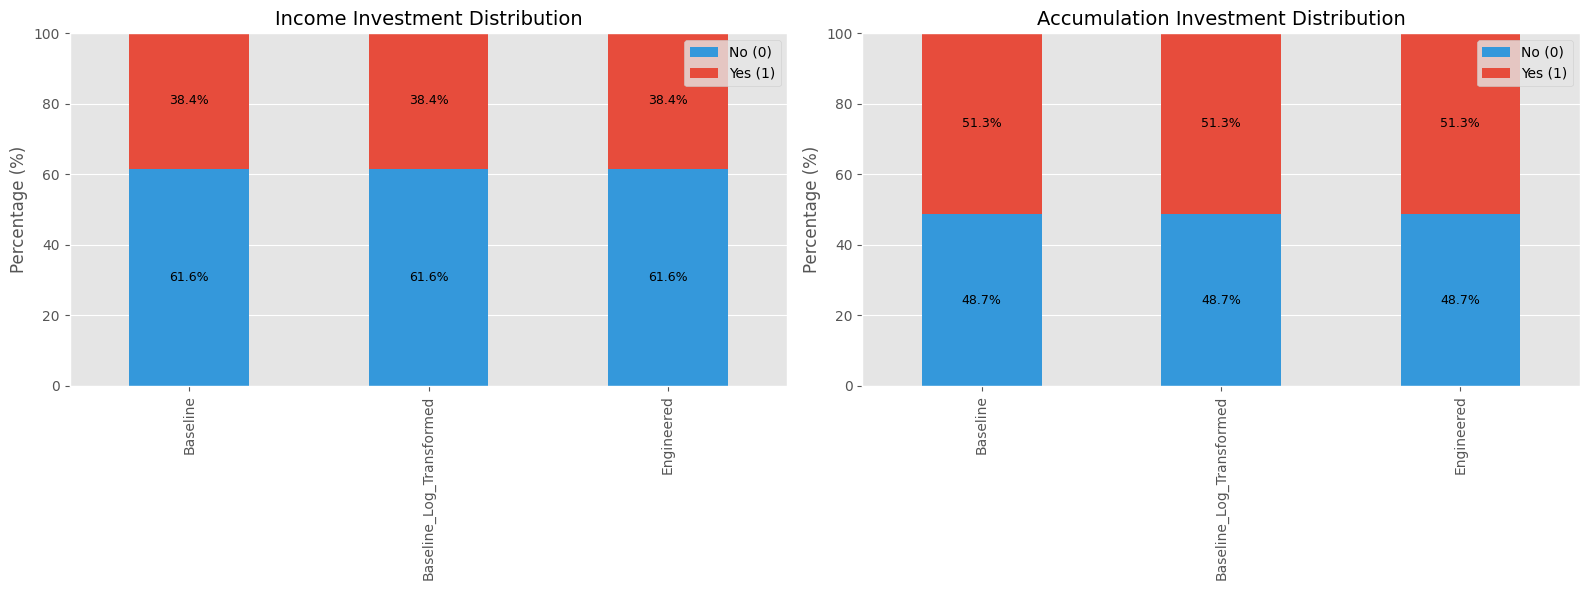



===== FEATURE DISTRIBUTIONS =====

Processing Baseline DataFrame (1/3)...
Saving plots to: baseline_plots
Found 7 features. Creating 1 pages...
  Processing batch 1/1 with 7 features...


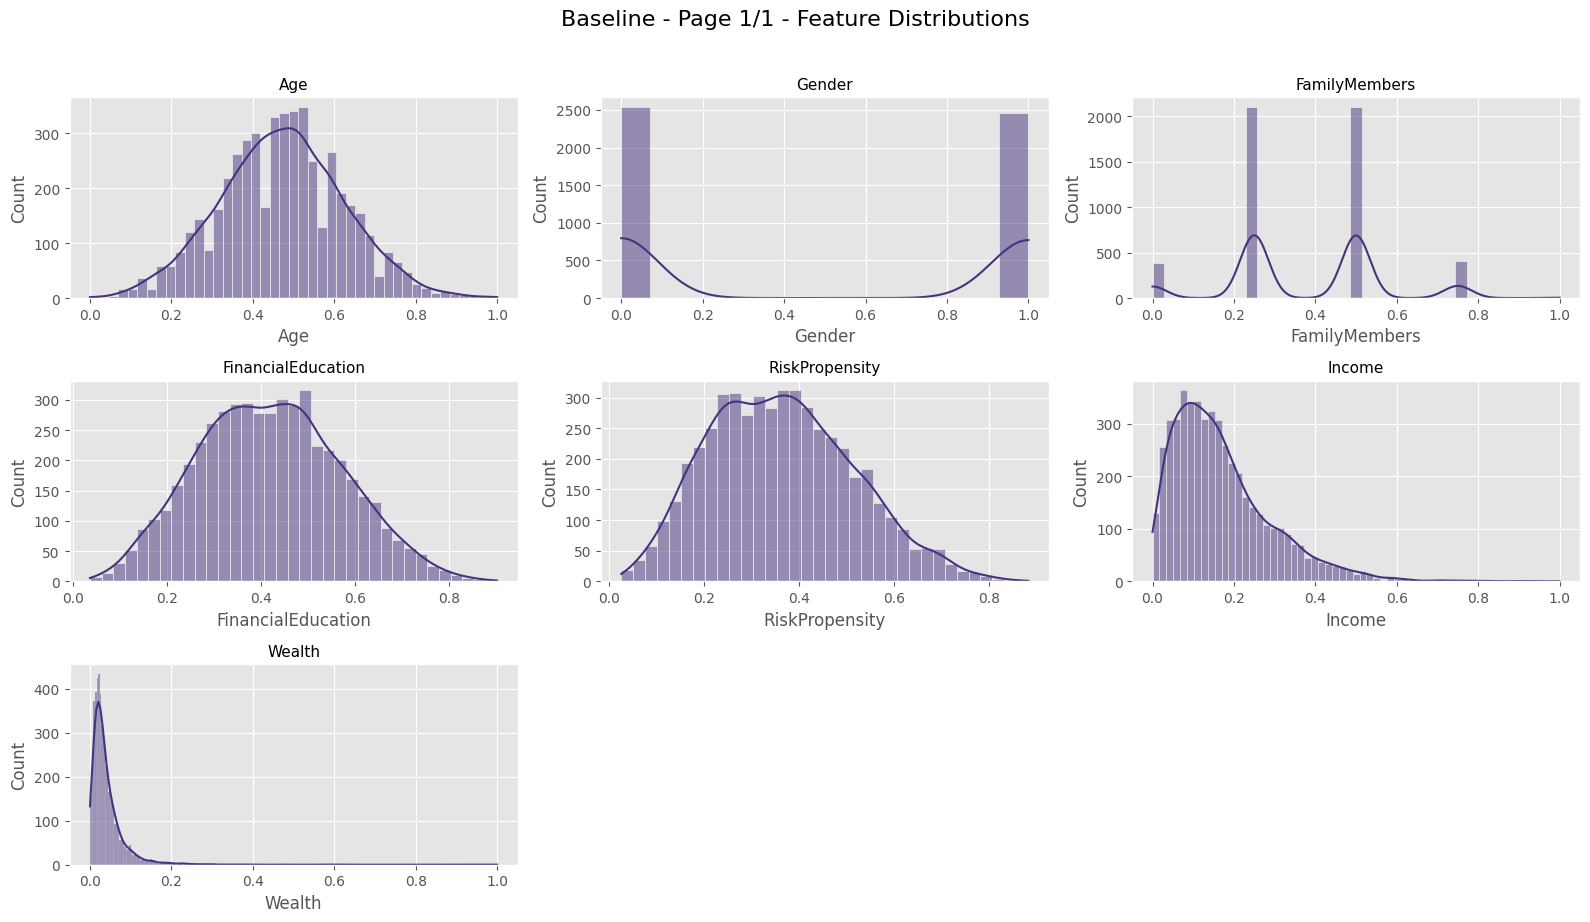

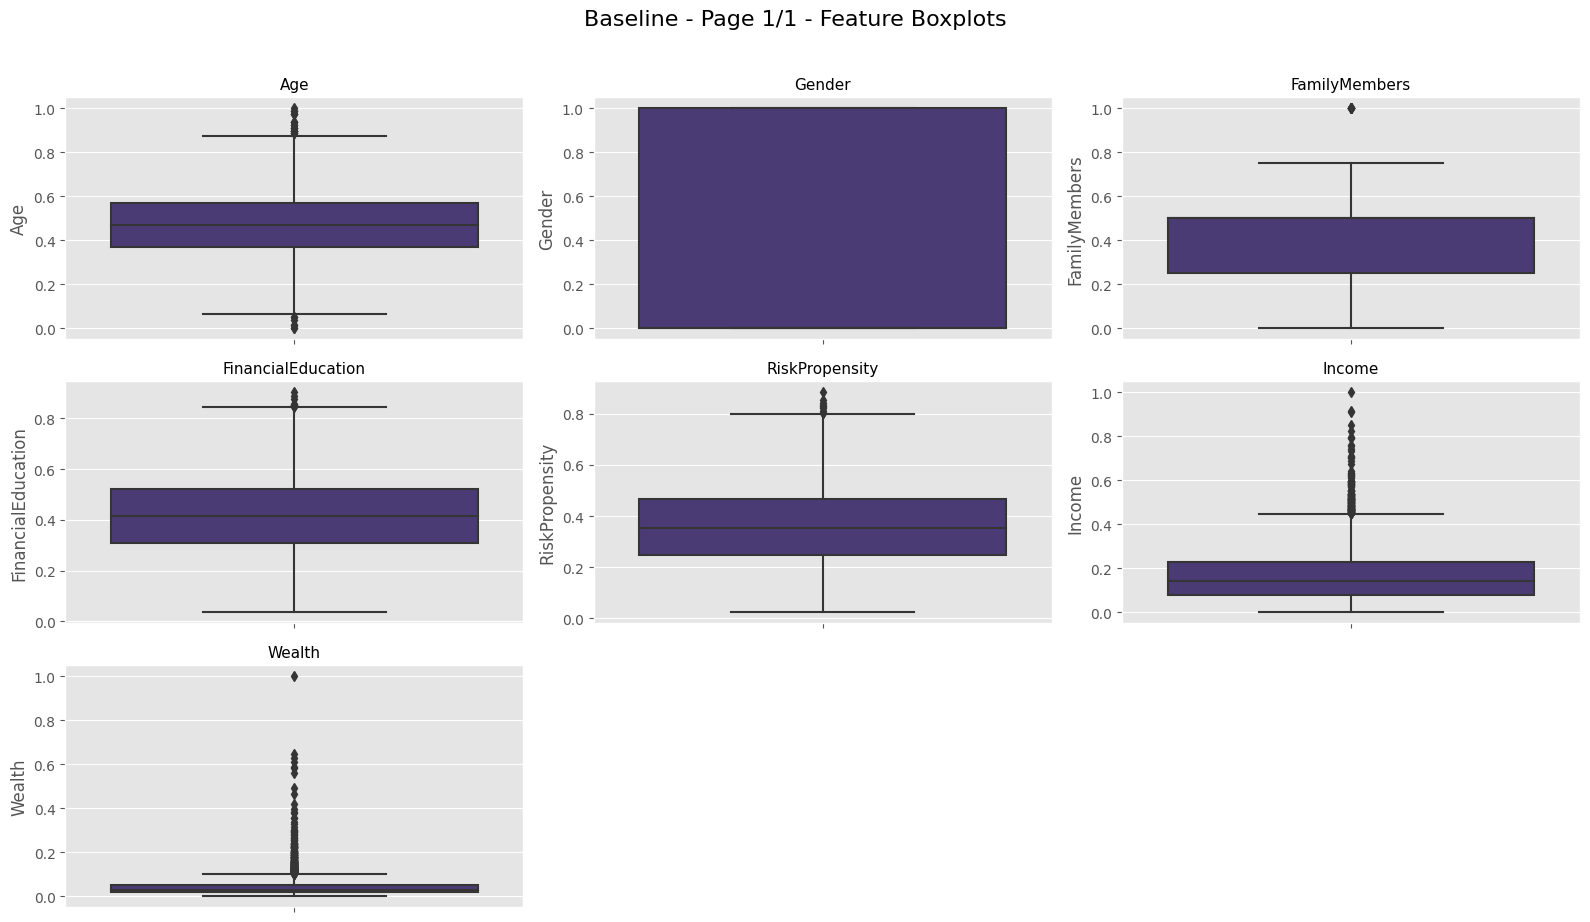

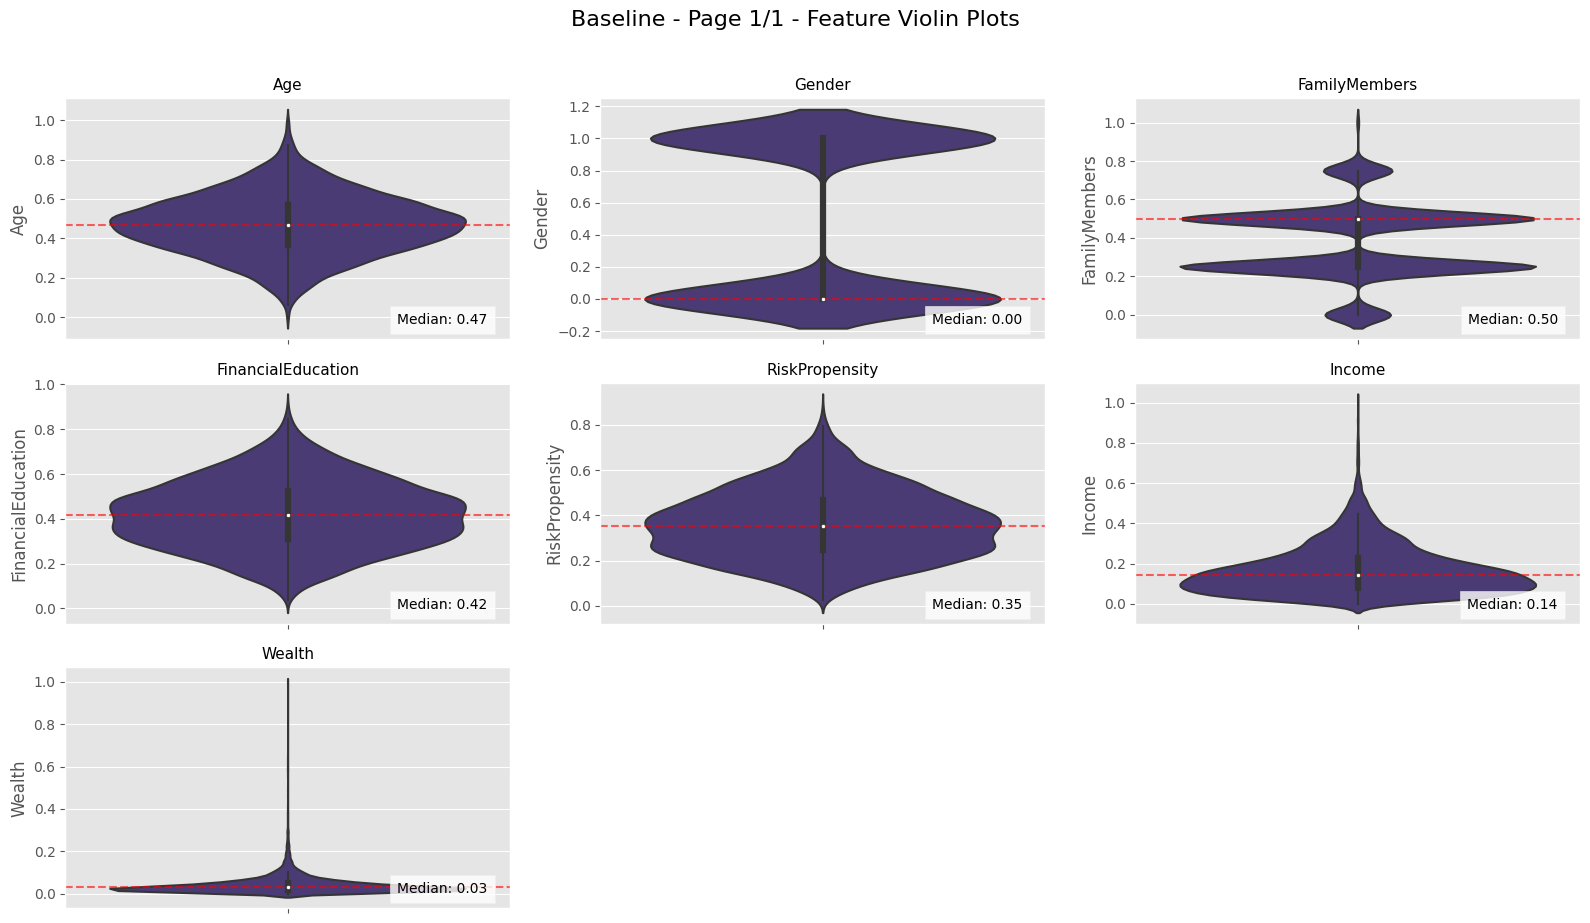


Processing Baseline_Log_Transformed DataFrame (2/3)...
Saving plots to: baseline_log_transformed_plots
Found 7 features. Creating 1 pages...
  Processing batch 1/1 with 7 features...


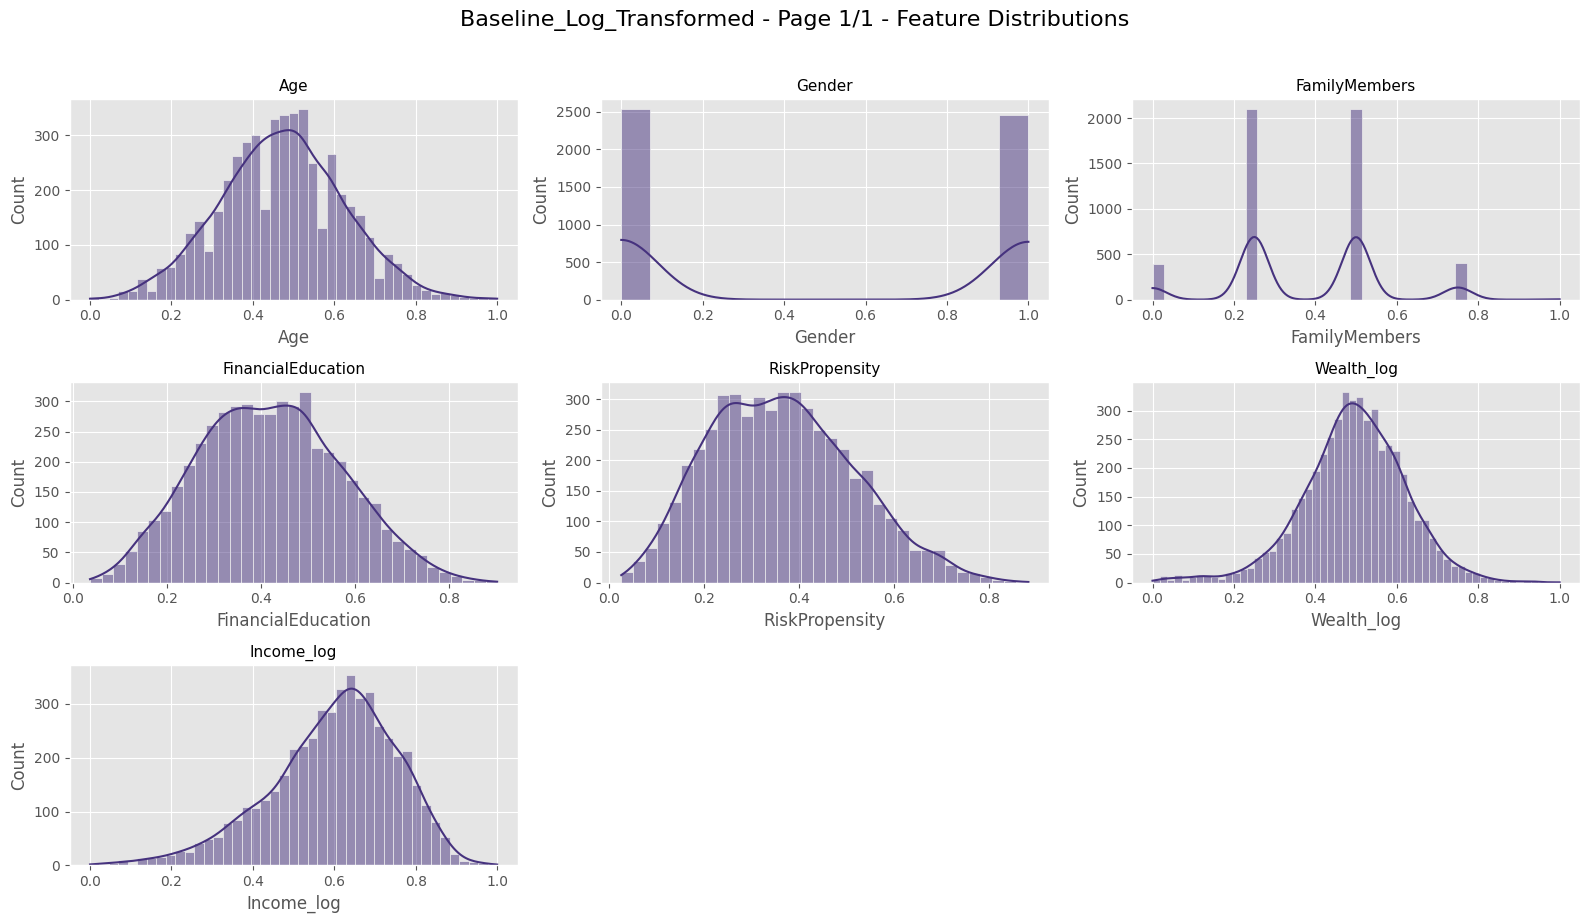

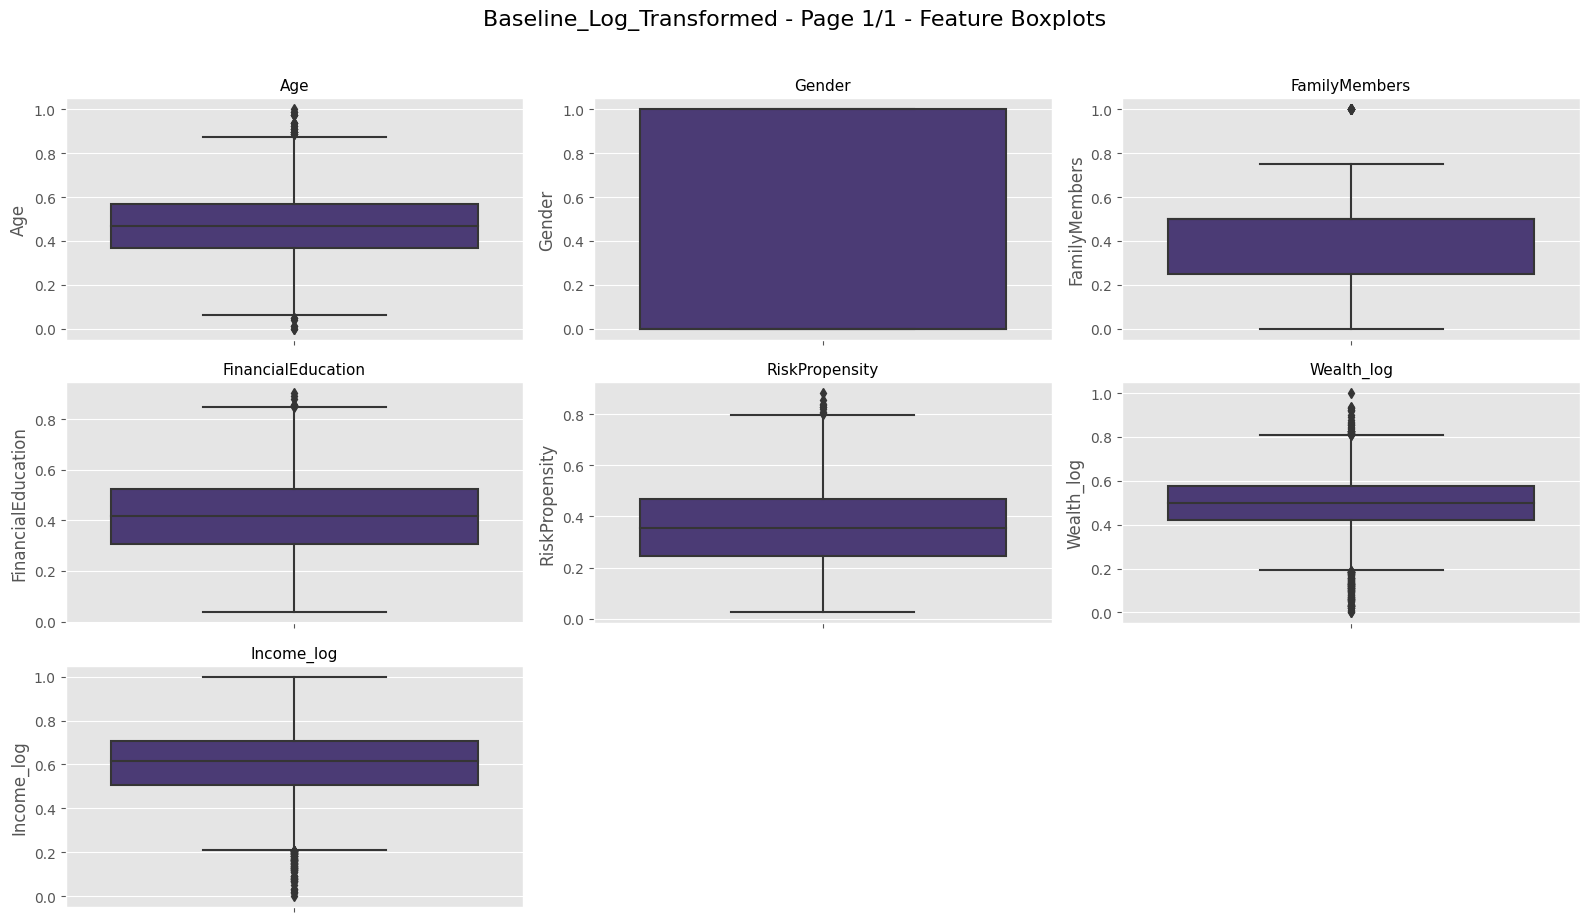

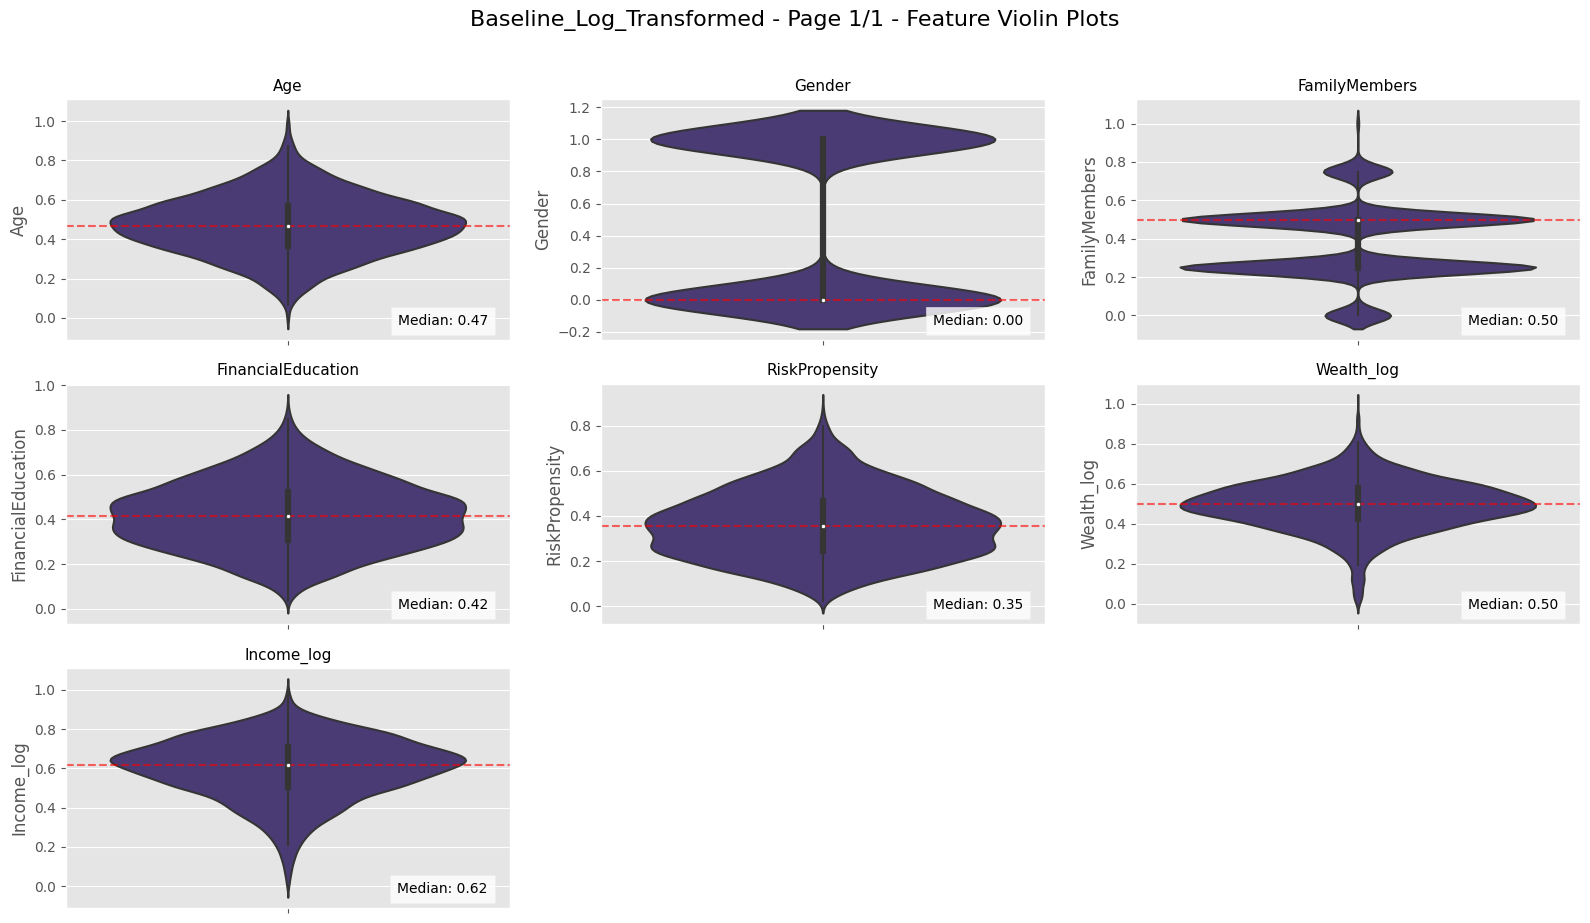


Processing Engineered DataFrame (3/3)...
Saving plots to: engineered_plots
Found 19 features. Creating 3 pages...
  Processing batch 1/3 with 9 features...


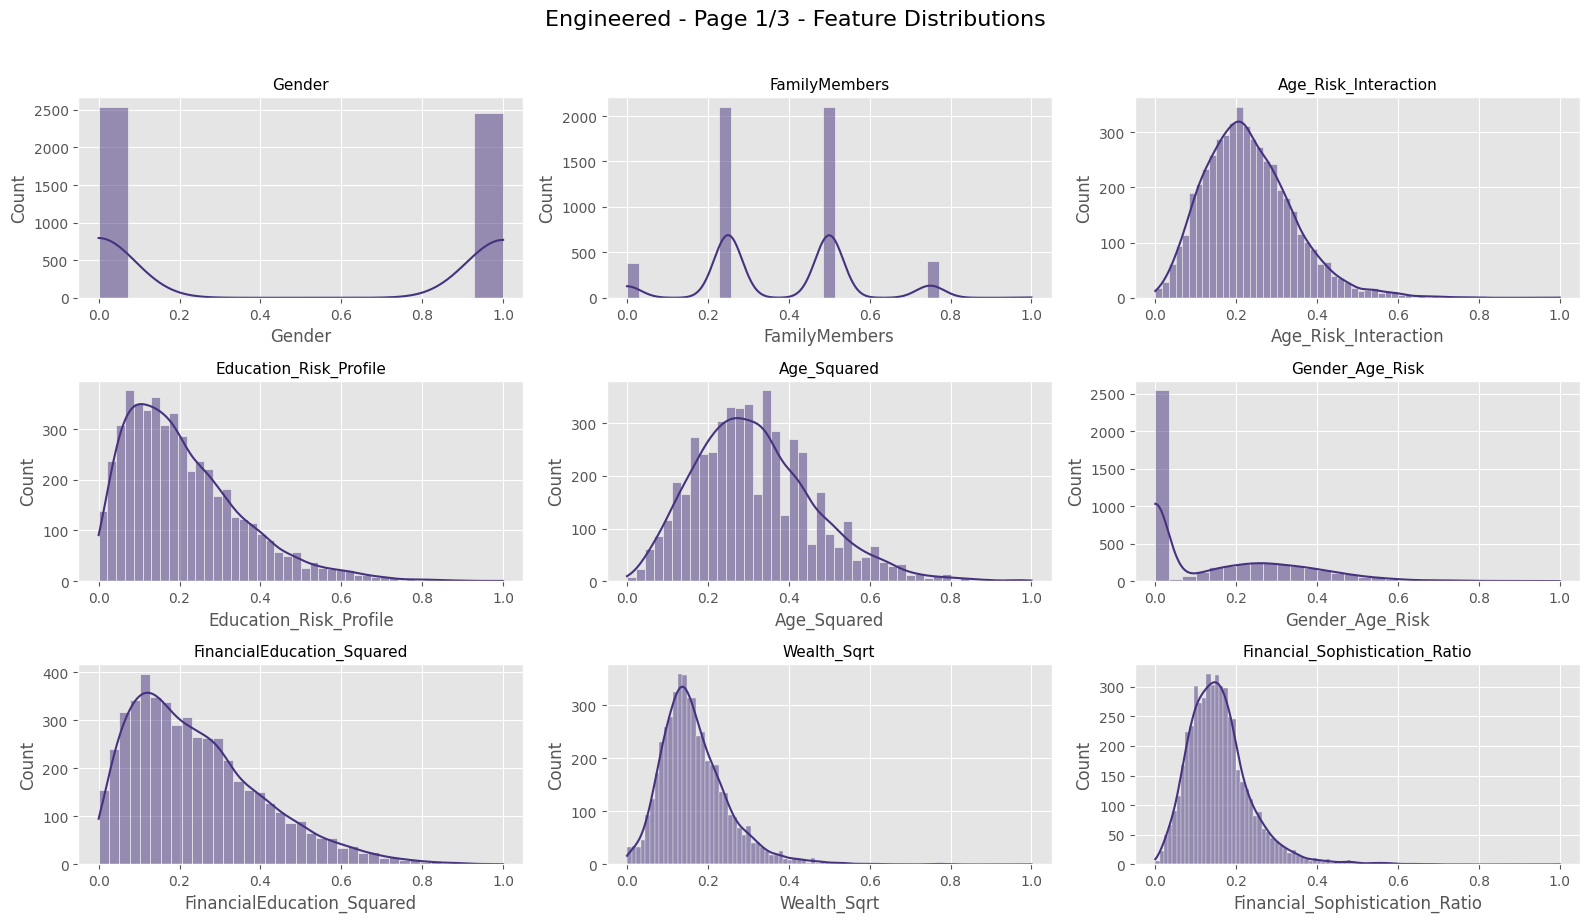

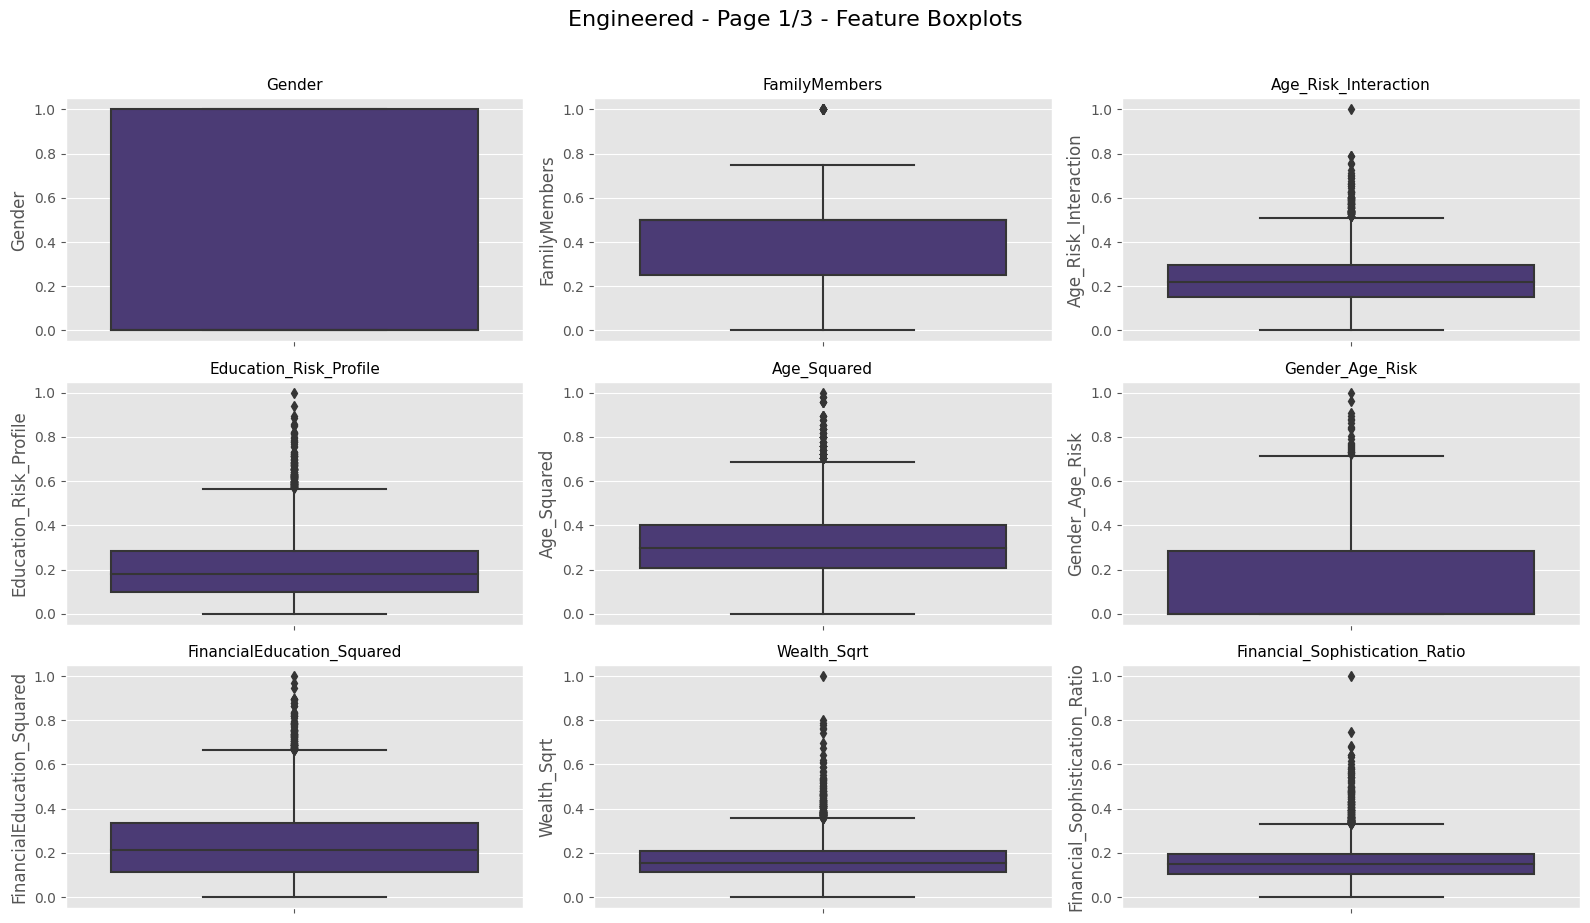

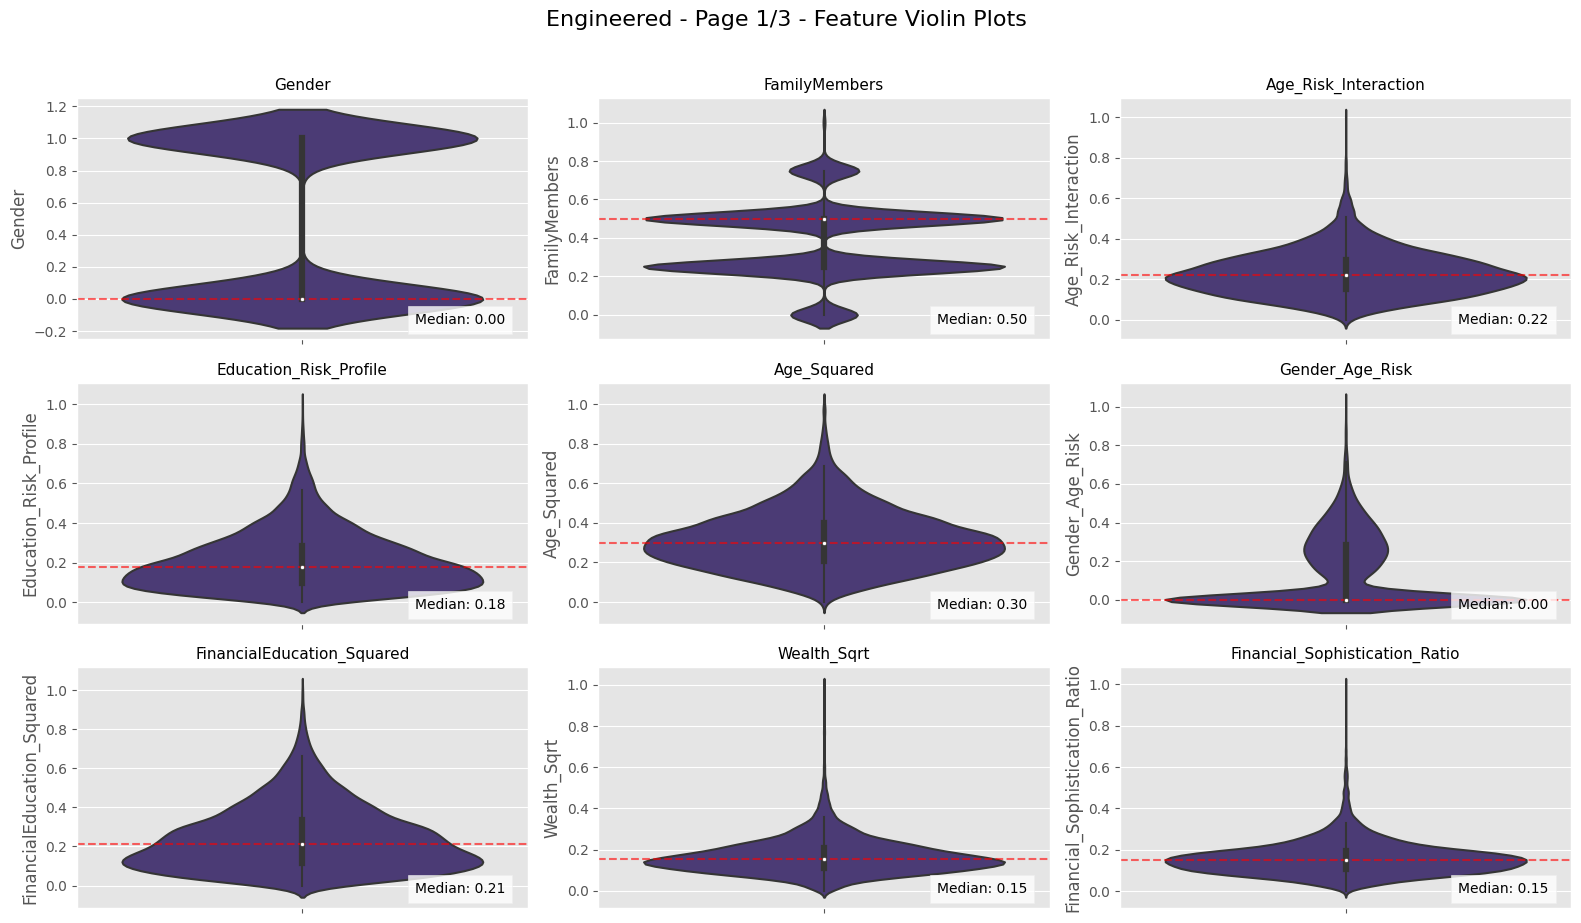

  Processing batch 2/3 with 9 features...


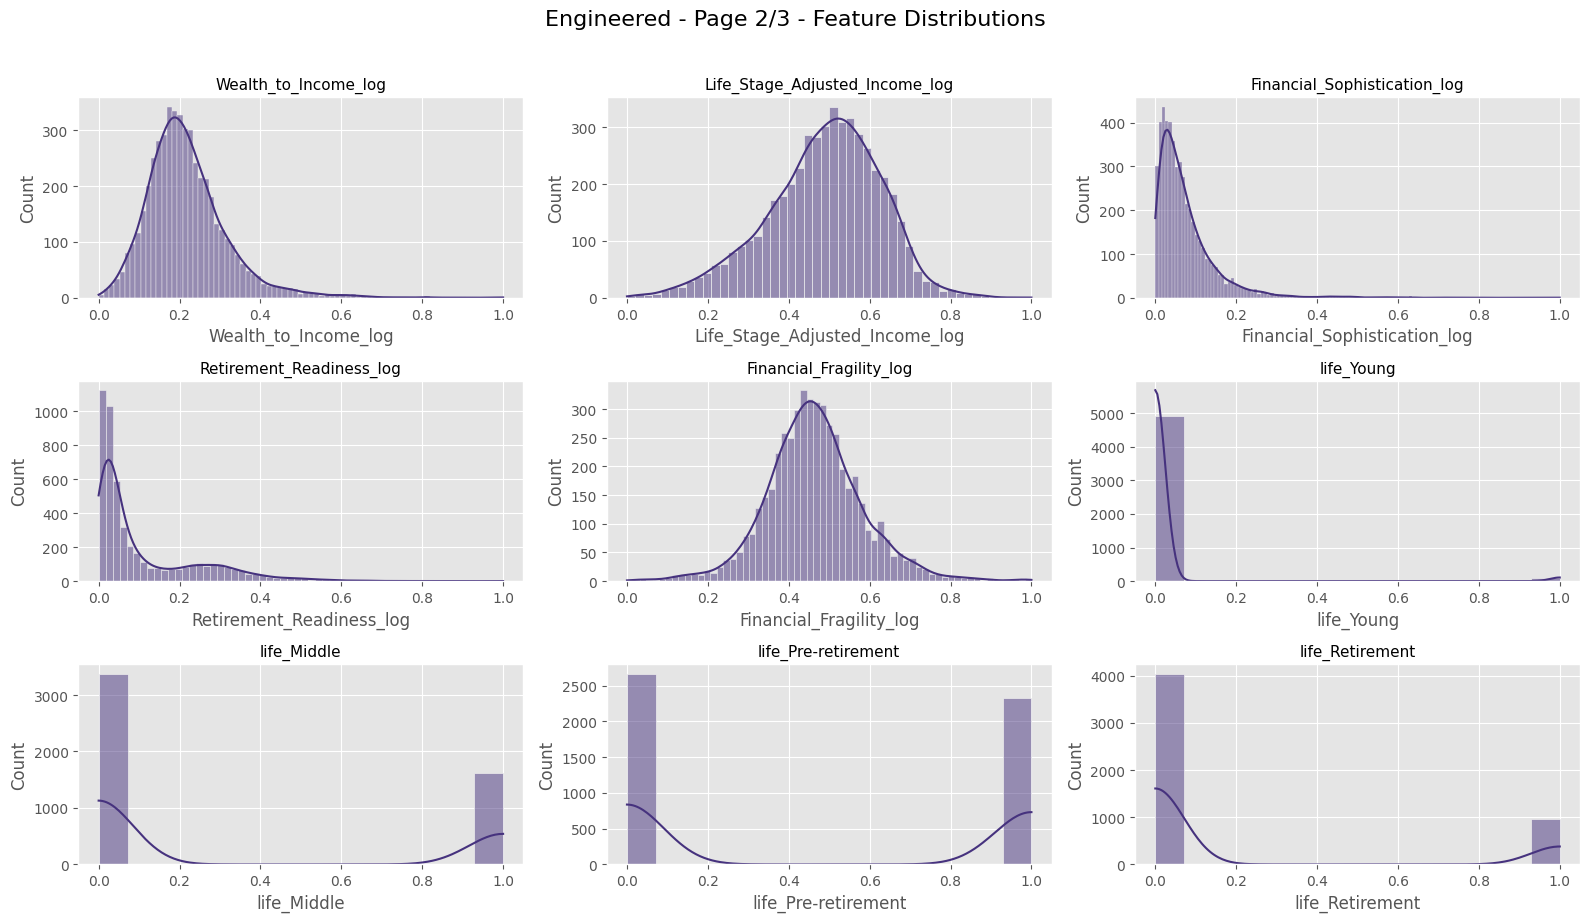

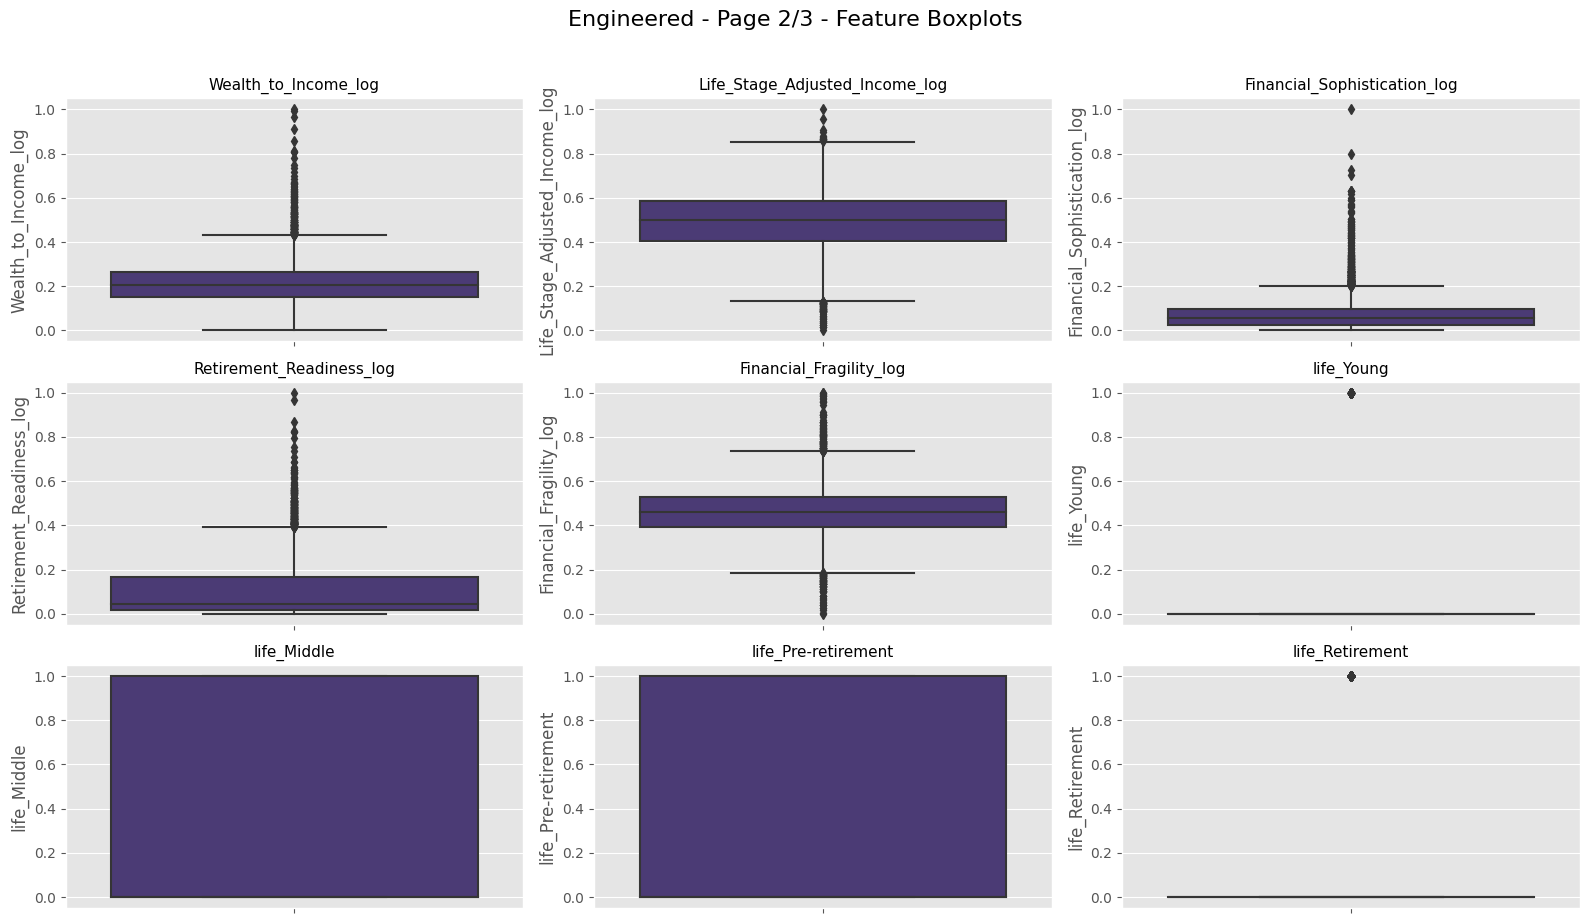

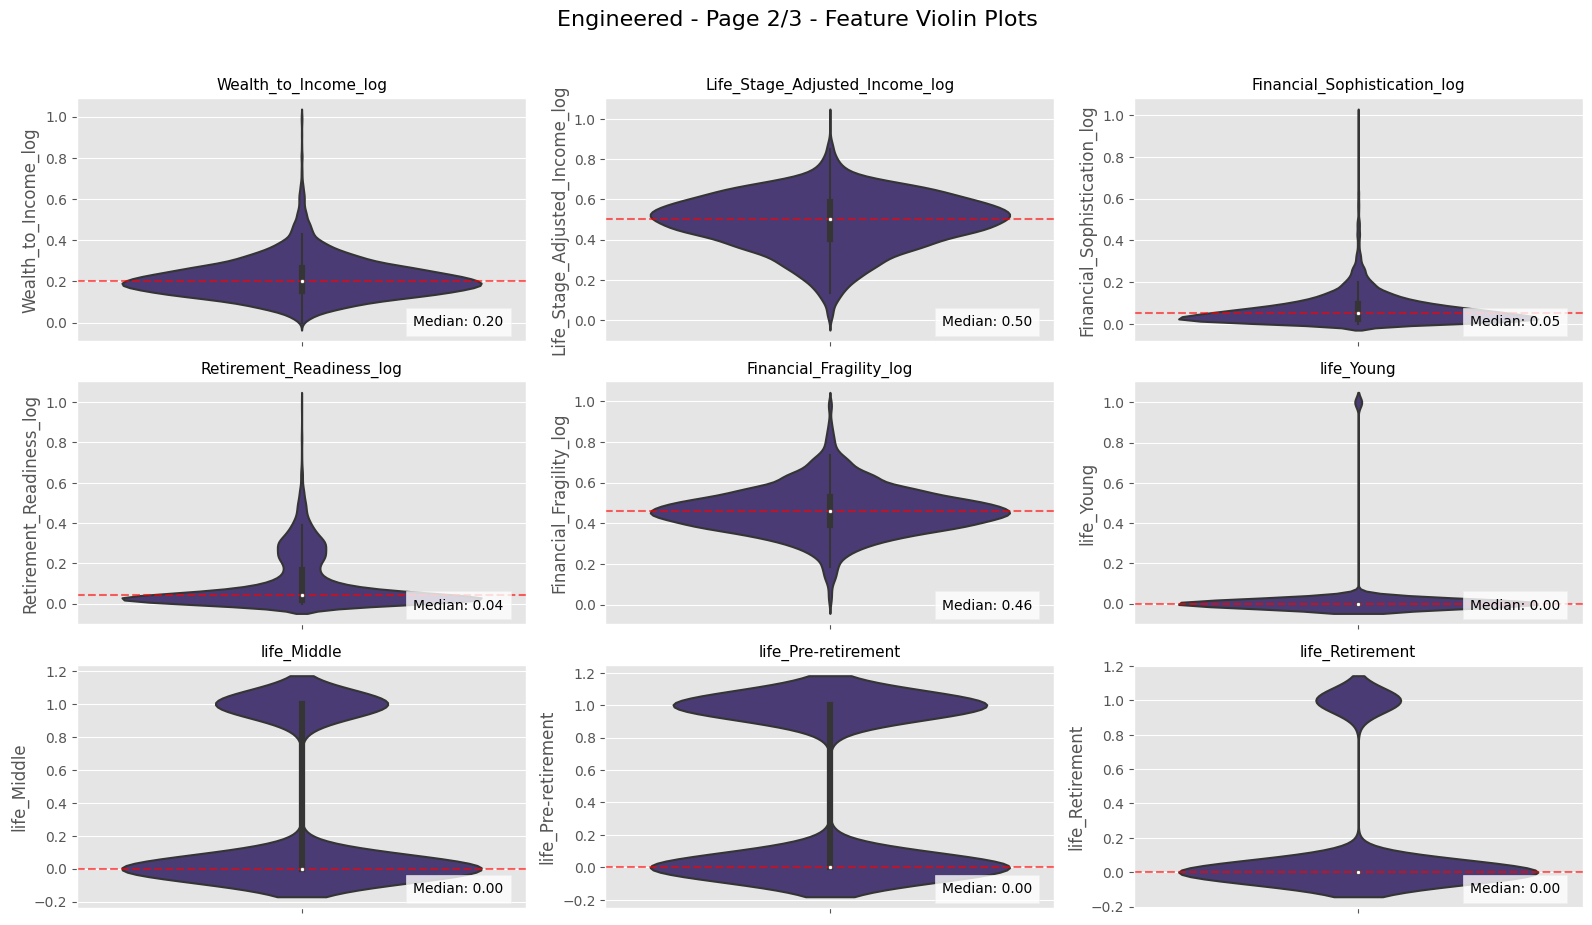

  Processing batch 3/3 with 1 features...


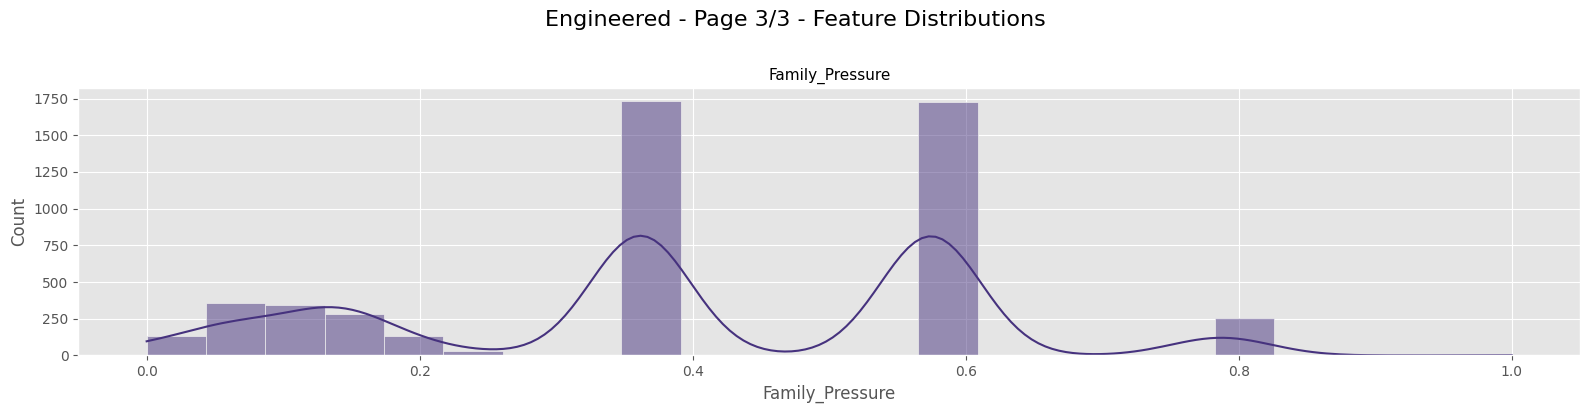

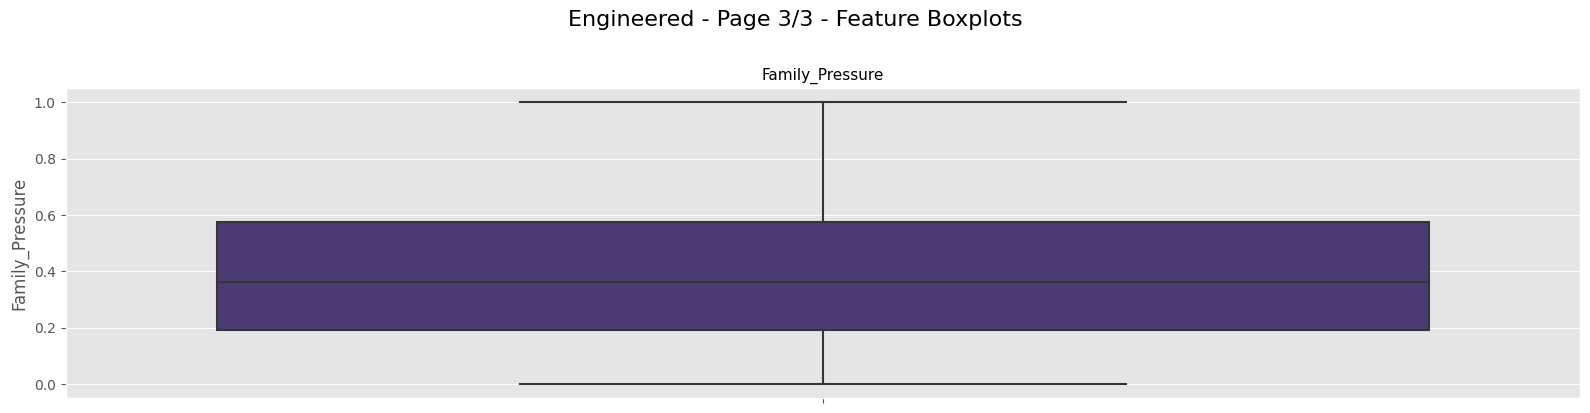

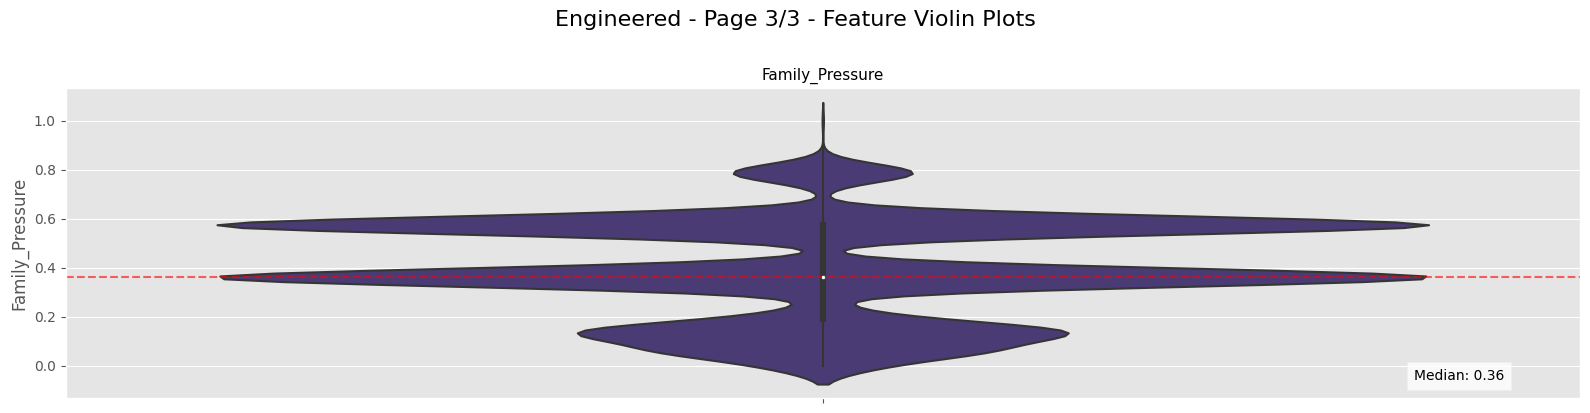



===== CORRELATION ANALYSIS =====

Processing correlations for Baseline DataFrame (1/3)...
Calculating correlations for 7 features...
Creating full correlation matrix for Baseline...


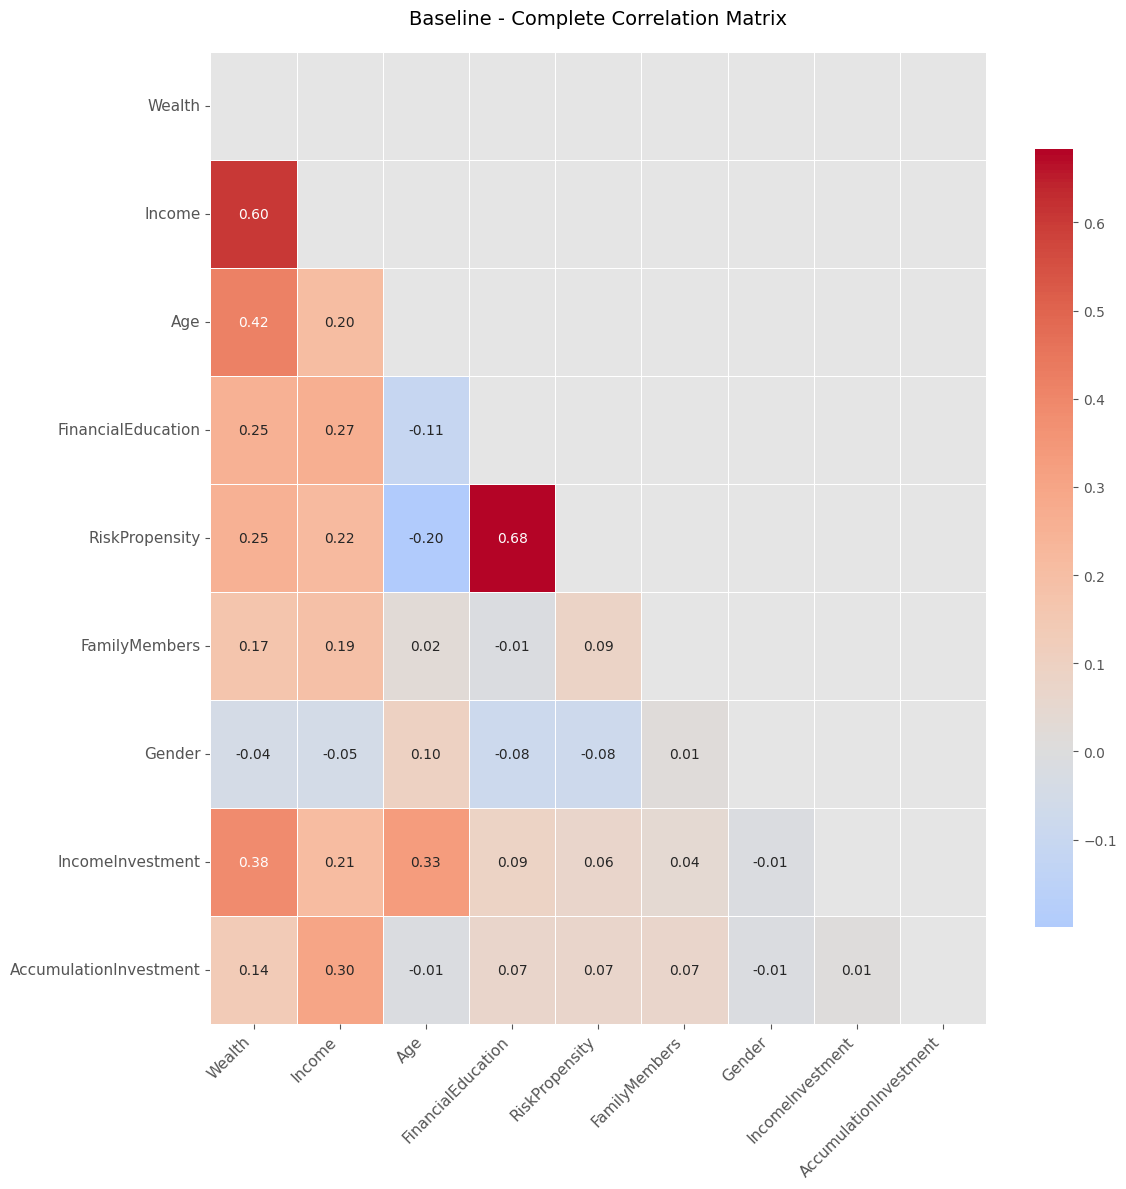

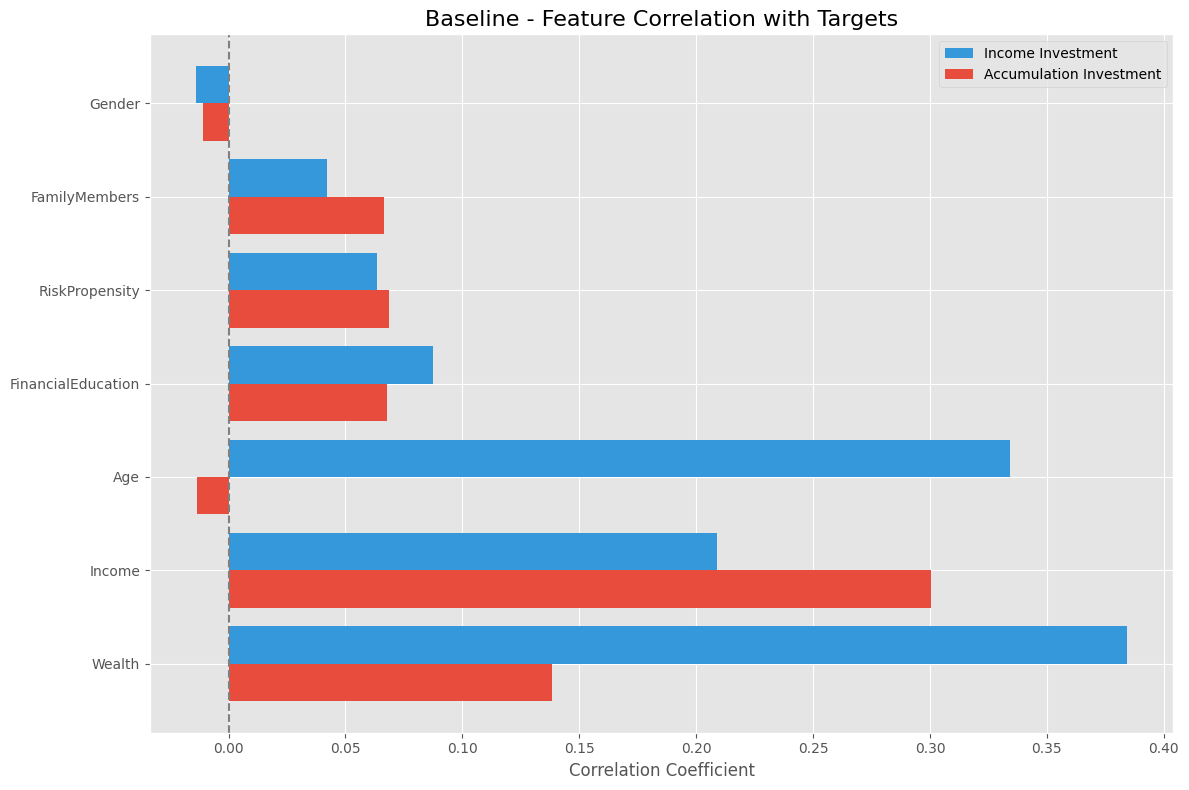


Processing correlations for Baseline_Log_Transformed DataFrame (2/3)...
Calculating correlations for 7 features...
Creating full correlation matrix for Baseline_Log_Transformed...


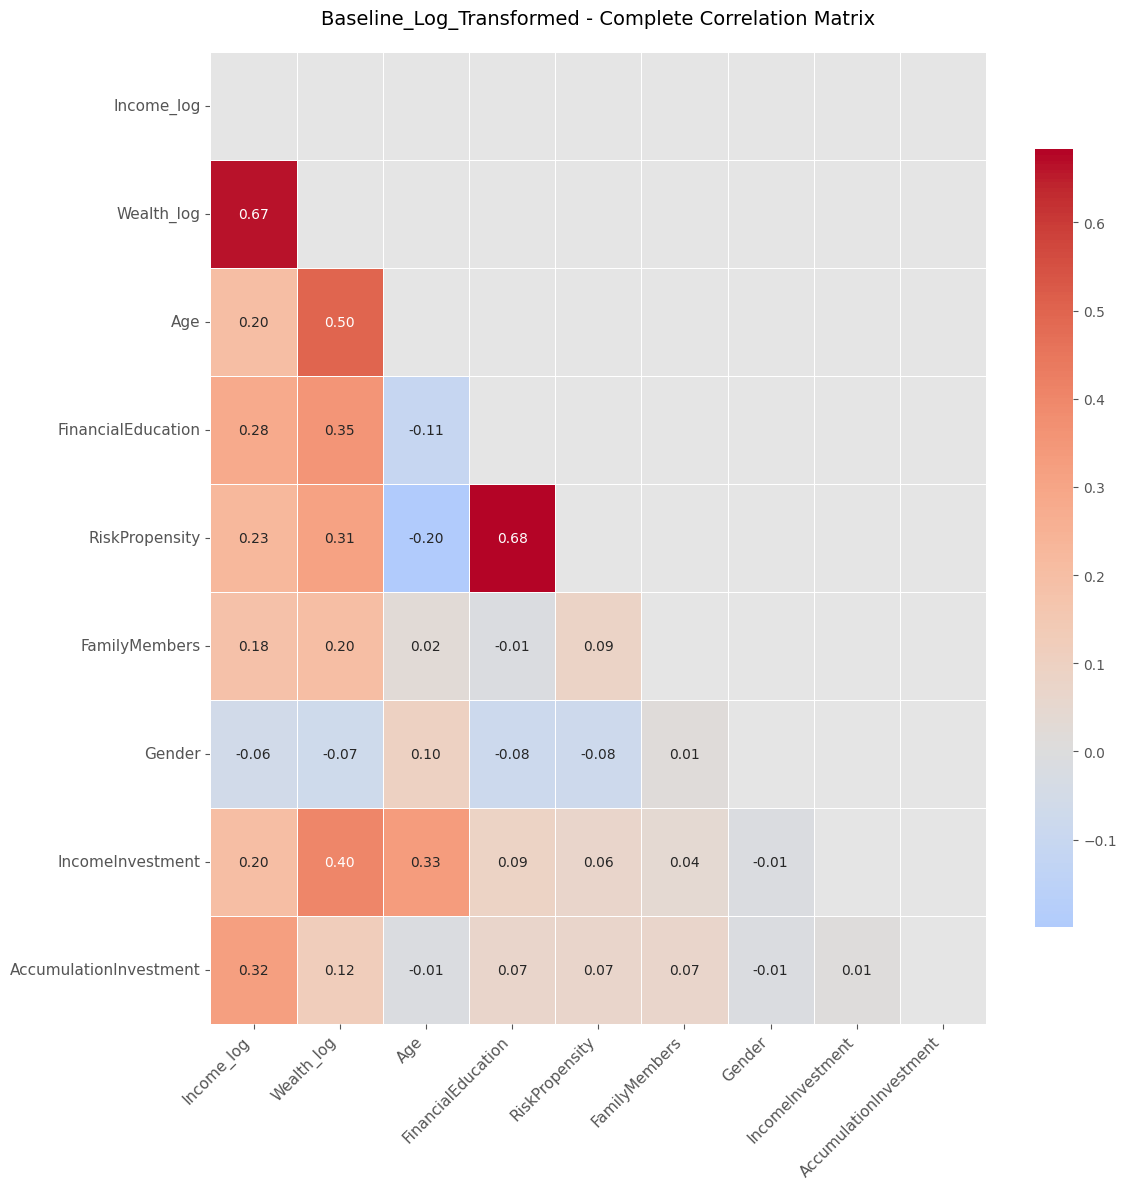

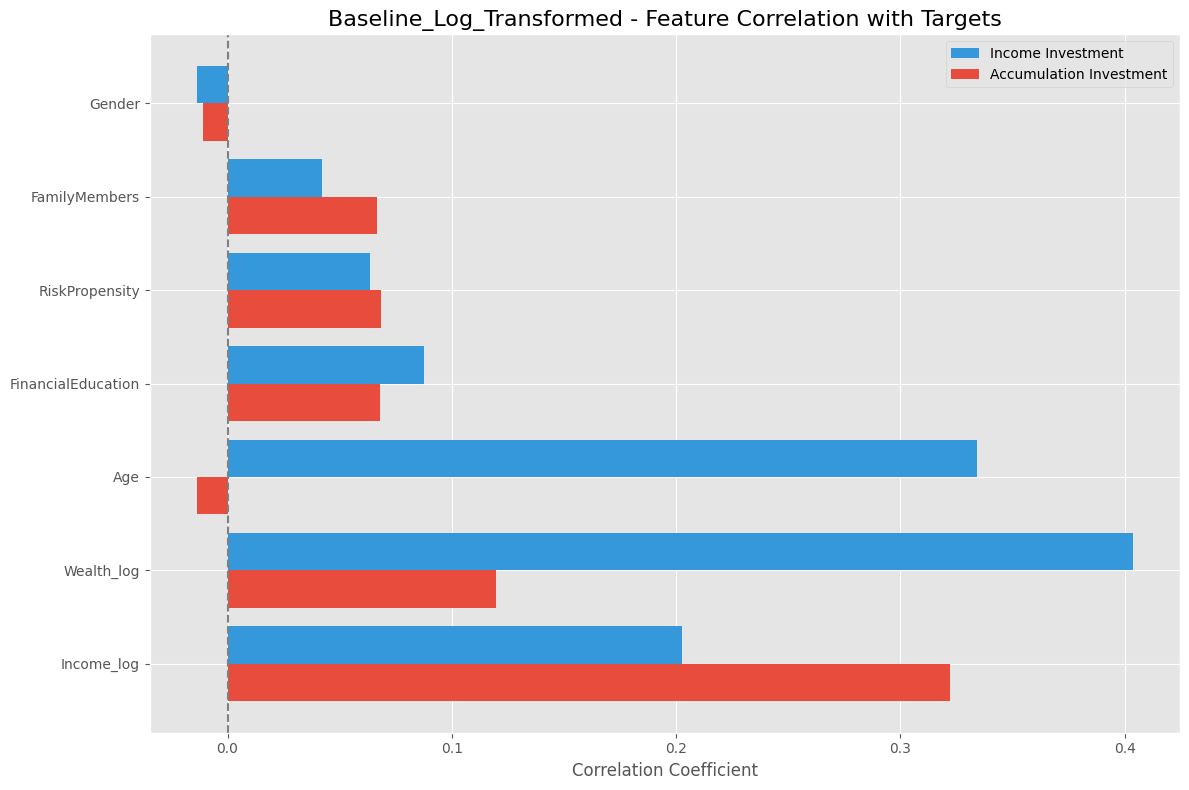


Processing correlations for Engineered DataFrame (3/3)...
Calculating correlations for 19 features...
Creating full correlation matrix for Engineered...


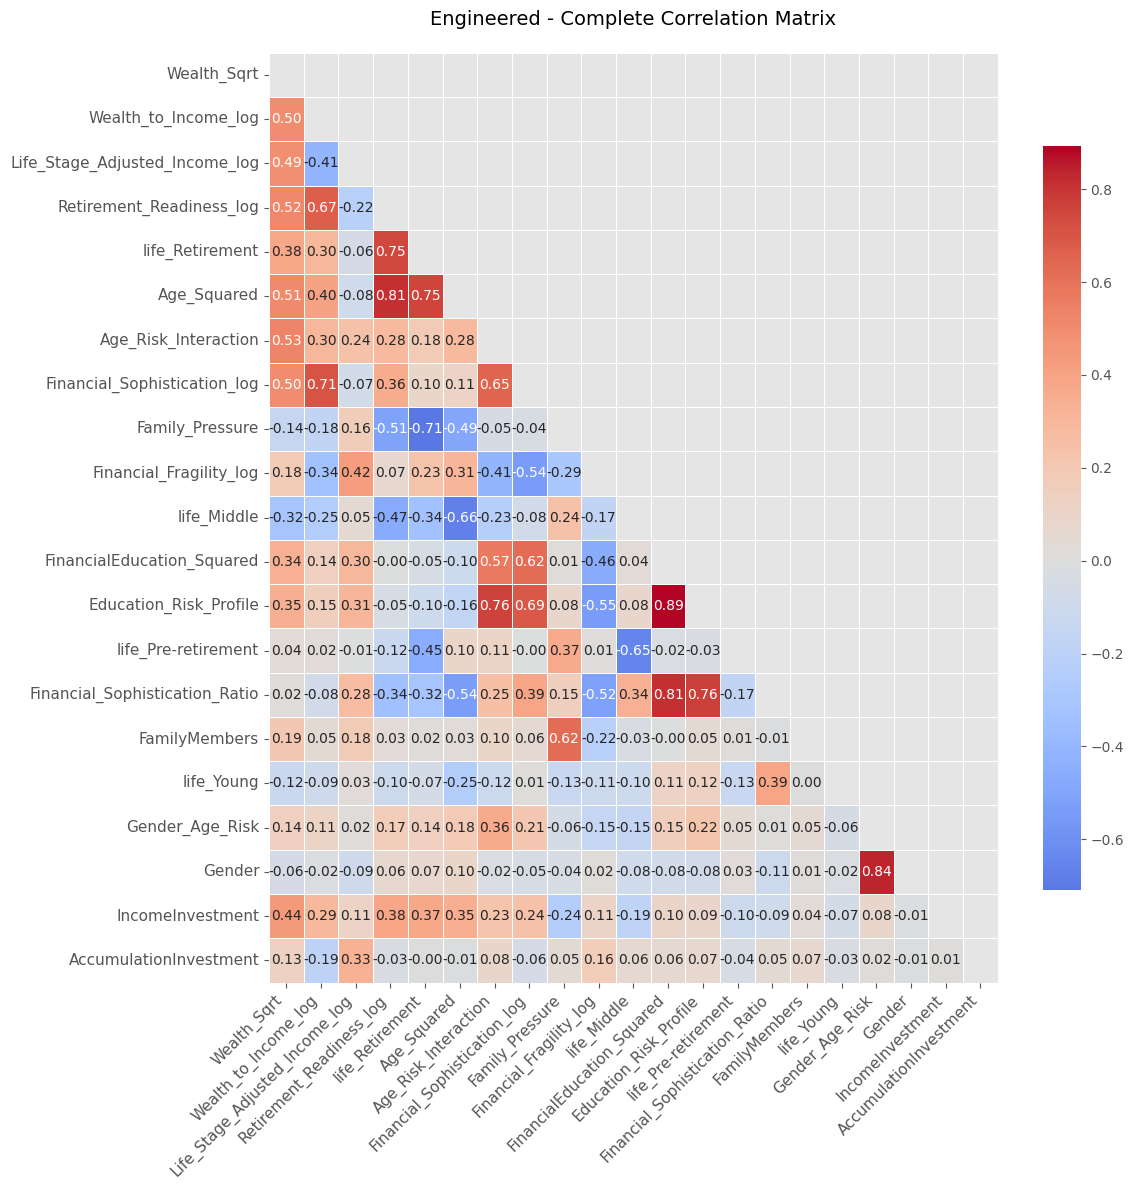

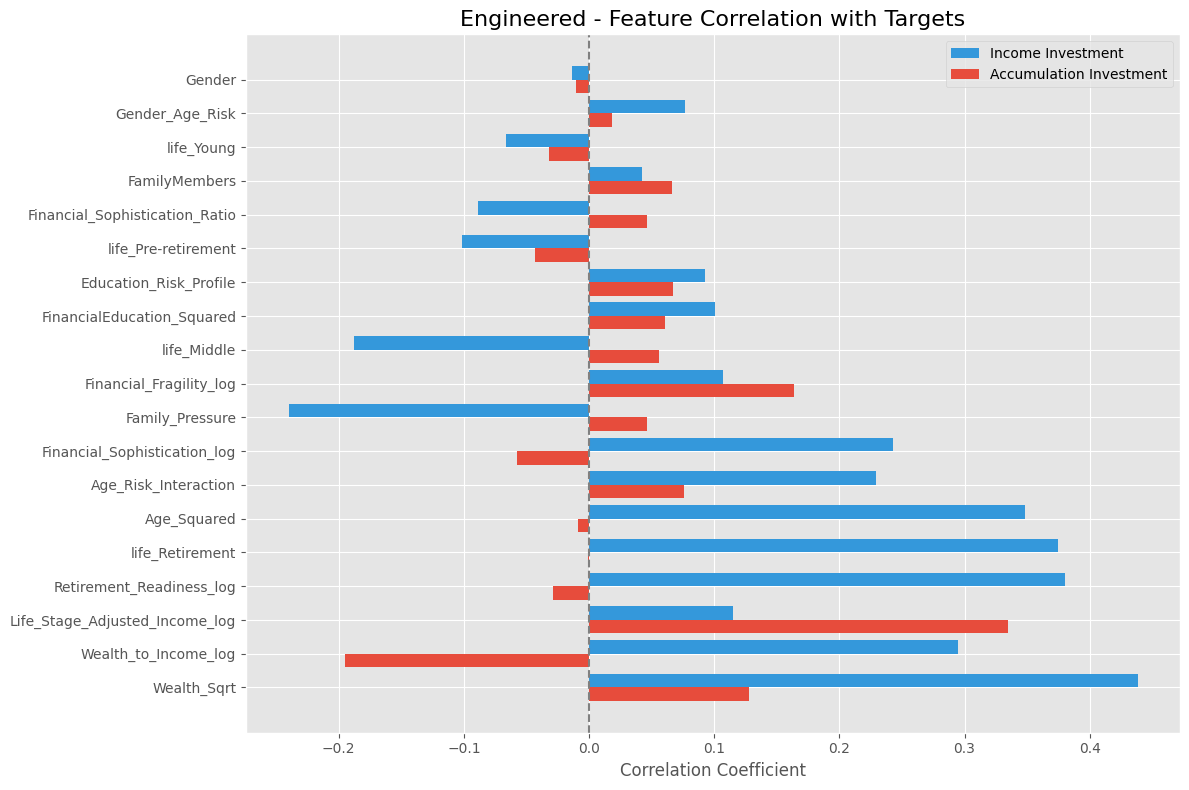



===== FEATURE COMPARISON ACROSS DATAFRAMES =====
Found 2 common features. Creating 1 comparison pages...
  Processing comparison batch 1/1 for Baseline...


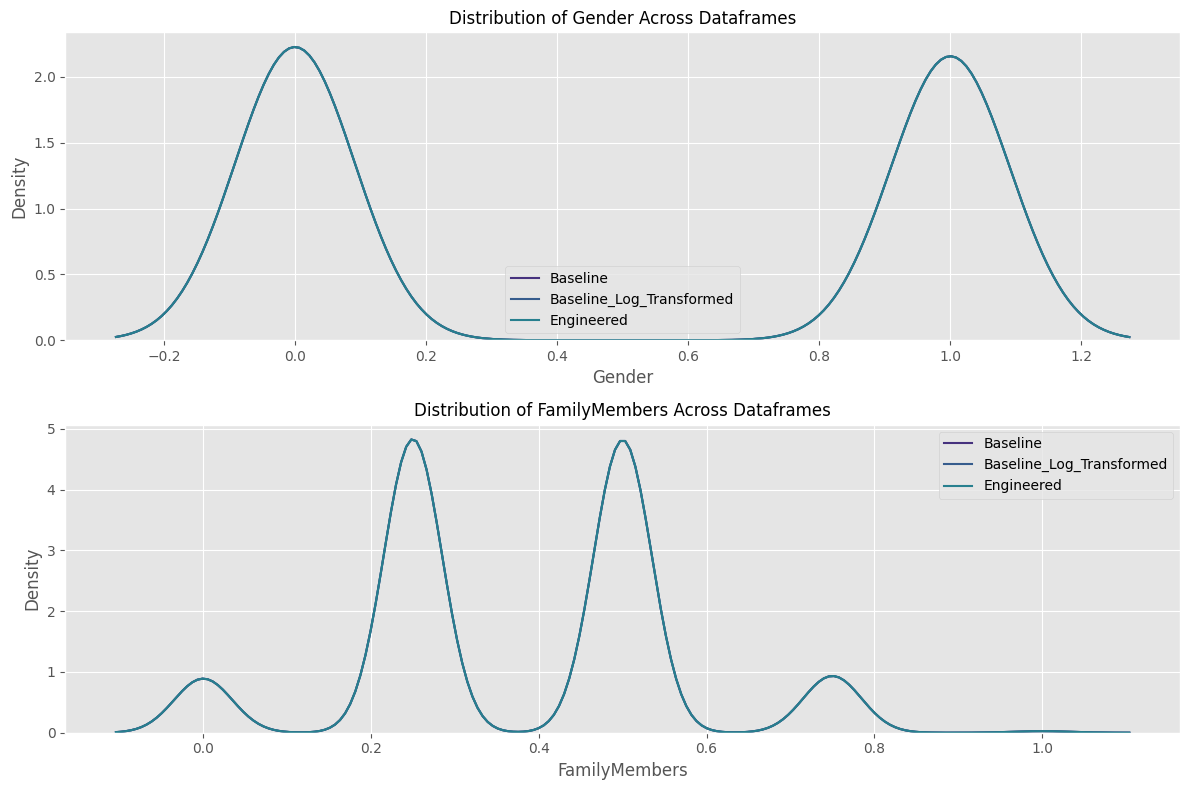

  Processing comparison batch 1/1 for Baseline_Log_Transformed...


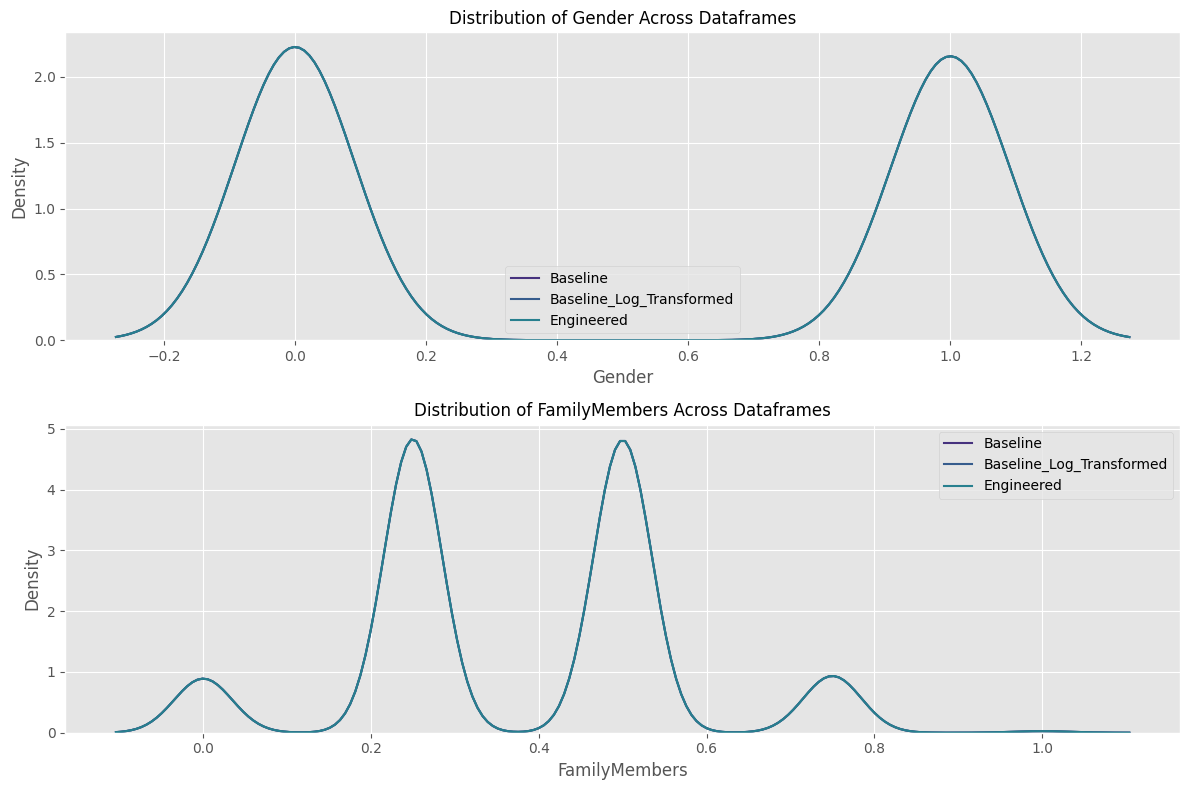

  Processing comparison batch 1/1 for Engineered...


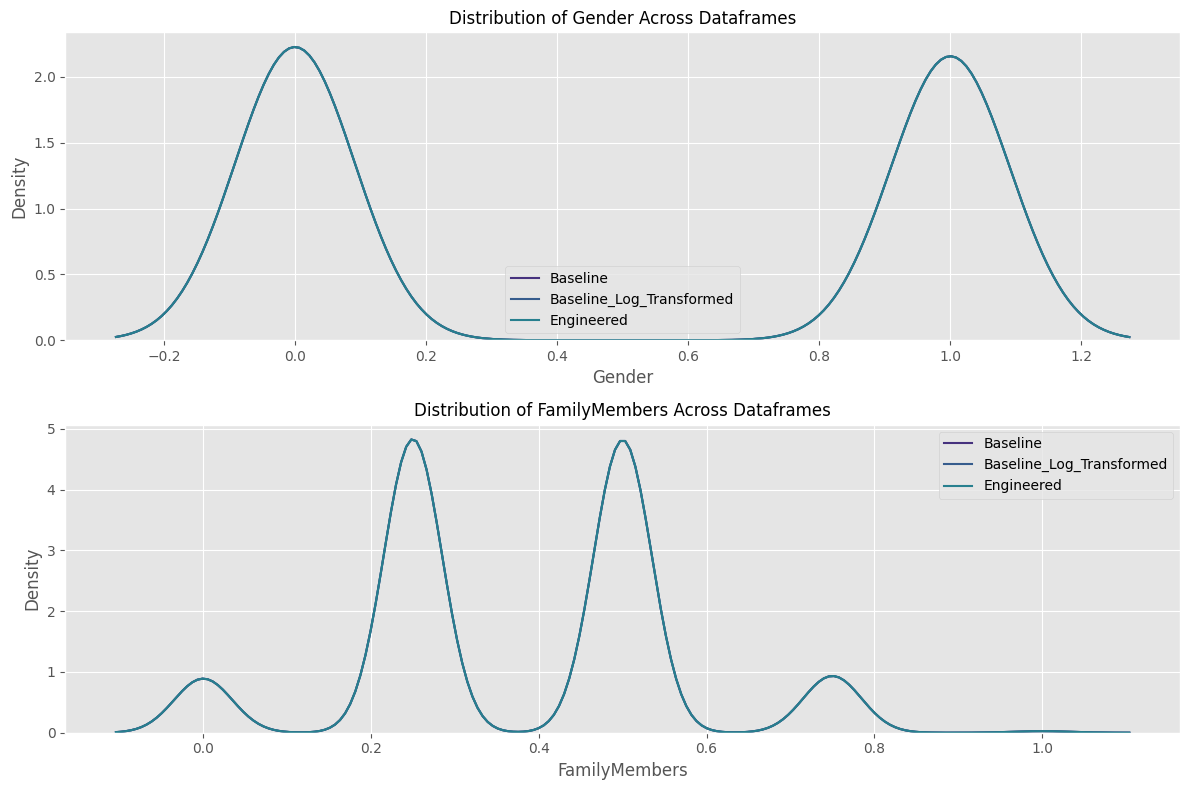

In [7]:
# =====================================================================================
# OPTIMIZED ADAPTIVE GRAPHICAL DISTRIBUTION AND CORRELATION ANALYSIS
# =====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import time
import gc  # Garbage collection
import os  # For directory creation
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_palette("viridis")  # Keep the purple color scheme
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def analyze_dataframes(df_list, titles, save_plots=True):
    """
    Optimized analysis of multiple dataframes with all correlations on single page.
    Saves plots in separate folders based on dataset title.
    """
    print("\n===== DATAFRAME ANALYSIS =====")
    
    # Create output directories for each dataset if they don't exist
    output_dirs = {}
    for title in titles:
        folder_name = f"{title.lower().replace(' ', '_')}_plots"
        os.makedirs(folder_name, exist_ok=True)
        output_dirs[title] = folder_name
    
    # Check what's in each dataframe
    for i, (df, title) in enumerate(zip(df_list, titles)):
        print(f"\n{title} DataFrame:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {len(df.columns)}")
        
        # Identify column types
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        binary_cols = [col for col in numeric_cols if df[col].nunique() <= 2]
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"  Numeric columns: {len(numeric_cols)}")
        print(f"  Binary columns: {len(binary_cols)}")
        print(f"  Categorical columns: {len(cat_cols)}")
        
        # Check for target variables
        has_income = 'IncomeInvestment' in df.columns
        has_accum = 'AccumulationInvestment' in df.columns
        print(f"  Has target variables: {'Yes' if has_income and has_accum else 'No'}")
    
    # 1. TARGET DISTRIBUTIONS (if targets exist)
    print("\n\n===== TARGET DISTRIBUTIONS =====")
    if all('IncomeInvestment' in df.columns and 'AccumulationInvestment' in df.columns for df in df_list):
        # Save target distributions in each output directory
        for title, output_dir in output_dirs.items():
            plot_target_distributions(df_list, titles, save_plots, output_dir)
    else:
        print("Target variables not found in all dataframes. Skipping target distribution plots.")
    
    # 2. FEATURE DISTRIBUTIONS
    print("\n\n===== FEATURE DISTRIBUTIONS =====")
    for df_idx, (df, title) in enumerate(zip(df_list, titles)):
        output_dir = output_dirs[title]
        print(f"\nProcessing {title} DataFrame ({df_idx+1}/{len(df_list)})...")
        print(f"Saving plots to: {output_dir}")
        
        # Find important numeric features
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Remove target variables if they exist
        for target in ['IncomeInvestment', 'AccumulationInvestment']:
            if target in numeric_cols:
                numeric_cols.remove(target)
        
        # Create optimized batches of features (smaller batches for better performance)
        feature_batches = [numeric_cols[i:i+9] for i in range(0, len(numeric_cols), 9)]
        
        print(f"Found {len(numeric_cols)} features. Creating {len(feature_batches)} pages...")
        
        # Process each batch
        for batch_idx, feature_batch in enumerate(feature_batches):
            print(f"  Processing batch {batch_idx+1}/{len(feature_batches)} with {len(feature_batch)} features...")
            plot_feature_distributions(df, f"{title} - Page {batch_idx+1}/{len(feature_batches)}", 
                                      feature_batch, save_plots, output_dir)
            
            # Clear matplotlib memory
            plt.close('all')
            gc.collect()
    
    # 3. CORRELATION ANALYSIS - UPDATED to show all correlations on one page
    print("\n\n===== CORRELATION ANALYSIS =====")
    for df_idx, (df, title) in enumerate(zip(df_list, titles)):
        output_dir = output_dirs[title]
        if 'IncomeInvestment' in df.columns and 'AccumulationInvestment' in df.columns:
            print(f"\nProcessing correlations for {title} DataFrame ({df_idx+1}/{len(df_list)})...")
            
            # Get all features (excluding targets)
            feature_cols = df.columns.difference(['IncomeInvestment', 'AccumulationInvestment']).tolist()
            
            # Calculate all correlations with targets in one go
            print(f"Calculating correlations for {len(feature_cols)} features...")
            corr_data = []
            for col in feature_cols:
                corr_income = df[col].corr(df['IncomeInvestment'])
                corr_accum = df[col].corr(df['AccumulationInvestment'])
                avg_abs_corr = (abs(corr_income) + abs(corr_accum)) / 2
                corr_data.append({
                    'Feature': col,
                    'Income Correlation': corr_income,
                    'Accumulation Correlation': corr_accum,
                    'Avg Abs Correlation': avg_abs_corr
                })
            
            corr_df = pd.DataFrame(corr_data)
            
            # Sort features by correlation and get top features
            sorted_features = corr_df.sort_values('Avg Abs Correlation', ascending=False)['Feature'].tolist()
            top_features = sorted_features[:min(30, len(sorted_features))]
            
            # Plot full correlation matrix with all features on one page
            print(f"Creating full correlation matrix for {title}...")
            plot_full_correlation_matrix(df, title, top_features, save_plots, output_dir)
            
            # Plot feature importance for all features
            plot_feature_importance(df, title, sorted_features, corr_df, save_plots, output_dir)
            
            # Clear matplotlib memory
            plt.close('all')
            gc.collect()
    
    # 4. FEATURE COMPARISON ACROSS DATAFRAMES
    print("\n\n===== FEATURE COMPARISON ACROSS DATAFRAMES =====")
    # Find common features across all dataframes
    common_numeric_features = set.intersection(*[
        set(df.select_dtypes(include=['float64', 'int64']).columns) 
        for df in df_list
    ])
    
    for target in ['IncomeInvestment', 'AccumulationInvestment']:
        if target in common_numeric_features:
            common_numeric_features.remove(target)
    
    common_features_list = list(common_numeric_features)
    
    if common_features_list:
        # Create batches for comparison plots (5 features per batch)
        comparison_batches = [common_features_list[i:i+5] for i in range(0, len(common_features_list), 5)]
        
        print(f"Found {len(common_features_list)} common features. Creating {len(comparison_batches)} comparison pages...")
        
        # Save comparison plots in each output directory
        for title, output_dir in output_dirs.items():
            for batch_idx, feature_batch in enumerate(comparison_batches):
                print(f"  Processing comparison batch {batch_idx+1}/{len(comparison_batches)} for {title}...")
                compare_features_across_dataframes(df_list, titles, feature_batch, save_plots, output_dir, batch_idx+1)
                
                # Clear matplotlib memory
                plt.close('all')
                gc.collect()
    else:
        print("No common numerical features found across all dataframes for comparison.")


# PLOTTING FUNCTIONS
# --------------------------

def plot_target_distributions(df_list, titles, save_plots=True, output_dir='.'):
    """Plot distribution of target variables across dataframes"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot IncomeInvestment distribution
    income_data = []
    for df in df_list:
        counts = df['IncomeInvestment'].value_counts(normalize=True) * 100
        income_data.append({
            'No (0)': counts.get(0, 0),
            'Yes (1)': counts.get(1, 0),
        })
    
    income_df = pd.DataFrame(income_data, index=titles)
    income_df.plot(kind='bar', stacked=True, ax=axes[0], 
                   color=['#3498db', '#e74c3c'])
    axes[0].set_title('Income Investment Distribution', fontsize=14)
    axes[0].set_ylabel('Percentage (%)', fontsize=12)
    axes[0].set_ylim([0, 100])
    
    # Add percentage labels
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    # Plot AccumulationInvestment distribution
    accum_data = []
    for df in df_list:
        counts = df['AccumulationInvestment'].value_counts(normalize=True) * 100
        accum_data.append({
            'No (0)': counts.get(0, 0),
            'Yes (1)': counts.get(1, 0),
        })
    
    accum_df = pd.DataFrame(accum_data, index=titles)
    accum_df.plot(kind='bar', stacked=True, ax=axes[1], 
                  color=['#3498db', '#e74c3c'])
    axes[1].set_title('Accumulation Investment Distribution', fontsize=14)
    axes[1].set_ylabel('Percentage (%)', fontsize=12)
    axes[1].set_ylim([0, 100])
    
    # Add percentage labels
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{output_dir}/target_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_distributions(df, title, feature_cols, save_plots=True, output_dir='.'):
    """Optimized plot histograms, boxplots, and violin plots for selected features"""
    if not feature_cols:
        print(f"No features to plot for {title}")
        return
    
    n_features = len(feature_cols)
    n_cols = min(3, n_features)
    n_rows = math.ceil(n_features / n_cols)
    
    # Create histograms
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Distributions", fontsize=16, y=1.02)
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_histograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create boxplots
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Boxplots", fontsize=16, y=1.02)
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create violin plots with the same purple color scheme
    fig = plt.figure(figsize=(16, max(4, 3*n_rows)))
    fig.suptitle(f"{title} - Feature Violin Plots", fontsize=16, y=1.02)
    
    # Get the current viridis color palette
    current_palette = sns.color_palette("viridis")
    main_purple = current_palette[0]  # Use the first color from viridis for consistency
    
    for i, col in enumerate(feature_cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # Use the exact same purple color for all violin plots
        sns.violinplot(y=df[col], ax=ax, color=main_purple)
        
        # Add median line for better readability
        median = df[col].median()
        ax.axhline(median, color='red', linestyle='--', alpha=0.6)
        
        # Add text with basic statistics
        stats_text = f"Median: {median:.2f}"
        ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, 
                verticalalignment='bottom', horizontalalignment='right',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
        
        ax.set_title(col, fontsize=11)
        
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_violinplots.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_full_correlation_matrix(df, title, features, save_plots=True, output_dir='.'):
    """Plot full correlation matrix with all features on one page"""
    # Add target variables to feature columns for correlation matrix
    all_cols = features + ['IncomeInvestment', 'AccumulationInvestment']
    
    # Calculate correlation matrix for all selected features
    corr_matrix = df[all_cols].corr()
    
    # Determine appropriate figure size and font size based on number of features
    n_features = len(all_cols)
    fig_size = min(20, max(12, n_features * 0.5))
    fig = plt.figure(figsize=(fig_size, fig_size))
    
    # Adjust font size for readability
    font_size = max(5, min(10, 300 / n_features))
    
    # Create mask for upper triangle to reduce redundant information
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot full correlation matrix
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8},
                annot_kws={"size": font_size})
    
    plt.title(f'{title} - Complete Correlation Matrix', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=font_size+1)
    plt.yticks(fontsize=font_size+1)
    plt.tight_layout()
    
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_full_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(df, title, features, corr_df, save_plots=True, output_dir='.', max_features=30):
    """Plot feature importance for all features on one page"""
    # Select top features if there are too many
    if len(features) > max_features:
        print(f"Limiting feature importance plot to top {max_features} features")
        features = features[:max_features]
    
    # Filter correlation data for selected features
    plot_data = corr_df[corr_df['Feature'].isin(features)].sort_values('Avg Abs Correlation')
    
    # Calculate appropriate figure size based on number of features
    fig_height = max(8, len(features) * 0.3)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    
    y_pos = np.arange(len(plot_data))
    ax.barh(y_pos, plot_data['Income Correlation'], height=0.4, align='center', 
            color='#3498db', label='Income Investment')
    ax.barh(y_pos + 0.4, plot_data['Accumulation Correlation'], height=0.4, align='center', 
            color='#e74c3c', label='Accumulation Investment')
    
    ax.set_yticks(y_pos + 0.2)
    ax.set_yticklabels(plot_data['Feature'])
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Correlation Coefficient', fontsize=12)
    ax.set_title(f'{title} - Feature Correlation with Targets', fontsize=16)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.legend()
    
    plt.tight_layout()
    if save_plots:
        cleaned_title = title.lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        plt.savefig(f'{output_dir}/{cleaned_title}_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

def compare_features_across_dataframes(df_list, titles, features, save_plots=True, output_dir='.', page=1):
    """Optimized comparison of features across dataframes"""
    n_features = len(features)
    
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        for df, title in zip(df_list, titles):
            if feature in df.columns:
                sns.kdeplot(df[feature], ax=axes[i], label=title)
        
        axes[i].set_title(f'Distribution of {feature} Across Dataframes', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(f'{output_dir}/feature_comparison_page{page}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the analysis with optimized plotting and separate output folders
df_list = [baseline_df, baseline_log_df, engineered_df]
titles = ["Baseline", "Baseline_Log_Transformed", "Engineered"]
analyze_dataframes(df_list, titles, save_plots=True)

# **HINTs**:

* Other **EDA ideas**:

    * You could add box plots to identify **outliers**.
    * You could add Q-Q plots to check for **normality**.
    * You might include [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html) for categorical variables - to observe and **compare the distribution of numeric data between multiple groups** (e.g., Gender, grouping by Financial Education, or whatever you think might make sense as a grouping variable): peaks, valleys, and tails of each group’s density curve can be compared to see where groups are similar or different.
    * You can add distribution plots, **comparing different demographic groups**.
    * For some pairs of features you can plot joint and marginal distribution to understand **dependence** (maybe a candidate response variable and a candidate explanatory variable) using a [joint plot, aka scatter histogram plot](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot).
    * ...and more.

<br>

###CLUSTERING


In [8]:
# =====================================================================================
# PART 3: CLUSTERING WITH CUSTOM DISTANCE METRICS
# =====================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import gower

print("\nCUSTOM DISTANCE-BASED CLUSTERING ANALYSIS")
print("========================================")

# Use our engineered features dataset for clustering (without normalization since we'll handle it in the distance functions)
X_for_clustering = engineered_X.copy()

# Separate numerical and categorical features
# Identify categorical features (modify as needed based on your actual dataset)
categorical_cols = [col for col in X_for_clustering.columns if 
                    col.startswith('life_') or col == 'Gender']
numerical_cols = [col for col in X_for_clustering.columns if col not in categorical_cols]

# Further separate numerical features into professional and financial education features
professional_cols = ['Age', 'Income_log', 'Wealth_log', 'FamilyMembers', 
                    'Wealth_to_Income', 'Wealth_Per_Family_Size', 'Income_Per_Family_Size']
financial_edu_cols = [col for col in numerical_cols if col not in professional_cols]

# Create separate dataframes for each feature type
X_num = X_for_clustering[numerical_cols]
X_cat = X_for_clustering[categorical_cols]
X_num_prof = X_for_clustering[[col for col in professional_cols if col in X_for_clustering.columns]]
X_num_finedu = X_for_clustering[[col for col in financial_edu_cols if col in X_for_clustering.columns]]

print(f"Total features: {X_for_clustering.shape[1]}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"  - Professional features: {X_num_prof.shape[1]}")
print(f"  - Financial education features: {X_num_finedu.shape[1]}")
print(f"Categorical features: {len(categorical_cols)}")


CUSTOM DISTANCE-BASED CLUSTERING ANALYSIS
Total features: 19
Numerical features: 14
  - Professional features: 1
  - Financial education features: 13
Categorical features: 5


In [9]:
# -------------------------
# Create GPU-Accelerated Custom Distance Matrices
# -------------------------
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, mahalanobis, jensenshannon
from scipy.linalg import inv
import time
import torch

# Set up GPU device if available (Apple M4 Max)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"\nUsing device: {device} for distance matrix calculations")

# Generate distance matrices with different metrics
print("Generating distance matrices with different metrics...")

# Create a numeric-only version of X_for_clustering for pdist functions
X_for_clustering_numeric = X_for_clustering.select_dtypes(include=['number']).copy()

# More thorough preprocessing for X_cat
print("Converting categorical features to numeric format...")
X_cat_numeric = pd.get_dummies(X_cat)

# Convert to numpy arrays and ensure they're numeric
X_num_np = X_num.to_numpy().astype('float64')
X_cat_numeric_np = X_cat_numeric.to_numpy().astype('float64')
X_num_prof_np = X_num_prof.to_numpy().astype('float64')
X_num_finedu_np = X_num_finedu.to_numpy().astype('float64')
X_clustering_np = X_for_clustering_numeric.to_numpy().astype('float64')

# Check for any NaN values that might cause issues
print(f"NaN values in X_num: {np.isnan(X_num_np).sum()}")
print(f"NaN values in X_cat_numeric: {np.isnan(X_cat_numeric_np).sum()}")
print(f"NaN values in X_num_prof: {np.isnan(X_num_prof_np).sum()}")
print(f"NaN values in X_num_finedu: {np.isnan(X_num_finedu_np).sum()}")

# Fill any NaN values with 0 as a safety measure
X_num_np = np.nan_to_num(X_num_np)
X_cat_numeric_np = np.nan_to_num(X_cat_numeric_np)
X_num_prof_np = np.nan_to_num(X_num_prof_np)
X_num_finedu_np = np.nan_to_num(X_num_finedu_np)
X_clustering_np = np.nan_to_num(X_clustering_np)

# ---------------------------------
# GPU-Accelerated Distance Functions
# ---------------------------------

def timed_operation(name, function, *args, **kwargs):
    """Run and time a function, reporting execution time"""
    print(f"Computing {name}...")
    start_time = time.time()
    result = function(*args, **kwargs)
    end_time = time.time()
    print(f"  ✓ {name} completed in {end_time - start_time:.2f} seconds")
    return result

def gpu_euclidean_distance(X):
    """GPU-accelerated Euclidean distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Calculate squared Euclidean using matrix operations || x - y ||^2 = ||x||^2 + ||y||^2 - 2<x,y>
    squared_norms = torch.sum(X_tensor**2, dim=1, keepdim=True)
    squared_distances = squared_norms + squared_norms.T - 2 * torch.mm(X_tensor, X_tensor.T)
    
    # Fix numerical instability (small negative values due to floating point)
    squared_distances = torch.clamp(squared_distances, min=0.0)
    
    # Take square root for actual distances
    distances = torch.sqrt(squared_distances)
    
    return distances.cpu().numpy()

def gpu_manhattan_distance(X):
    """GPU-accelerated Manhattan/Cityblock distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    n = X_tensor.shape[0]
    distances = torch.zeros((n, n), device=device)
    
    # Process in batches for memory efficiency
    batch_size = min(100, n)
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch_i = X_tensor[i:end_i]
        
        for j in range(0, n, batch_size):
            end_j = min(j + batch_size, n)
            batch_j = X_tensor[j:end_j]
            
            # Compute L1 norm between pairs of points
            pairwise_diff = torch.abs(batch_i.unsqueeze(1) - batch_j.unsqueeze(0))
            batch_distances = torch.sum(pairwise_diff, dim=2)
            distances[i:end_i, j:end_j] = batch_distances
            
    return distances.cpu().numpy()

def gpu_cosine_distance(X):
    """GPU-accelerated Cosine distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Normalize each vector
    X_norms = torch.sqrt(torch.sum(X_tensor**2, dim=1, keepdim=True))
    X_norms = torch.max(X_norms, torch.tensor(1e-8, device=device))  # Avoid division by zero
    X_normalized = X_tensor / X_norms
    
    # Compute cosine similarity
    similarities = torch.mm(X_normalized, X_normalized.T)
    
    # Clip to [-1, 1] range to handle numerical issues
    similarities = torch.clamp(similarities, -1.0, 1.0)
    
    # Convert to distances: d = 1 - similarity
    distances = 1.0 - similarities
    
    return distances.cpu().numpy()

def gpu_mahalanobis_distance(X):
    """GPU-accelerated Mahalanobis distance matrix calculation"""
    try:
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        n = X_tensor.shape[0]
        
        # Center the data
        X_centered = X_tensor - torch.mean(X_tensor, dim=0)
        
        # Compute covariance matrix
        cov = torch.mm(X_centered.T, X_centered) / (n - 1)
        
        # Add small regularization for numerical stability
        cov = cov + torch.eye(cov.shape[0], device=device) * 1e-6
        
        # Inverse of covariance matrix
        inv_cov = torch.linalg.inv(cov)
        
        # Calculate distances in batches
        distances = torch.zeros((n, n), device=device)
        batch_size = min(50, n)
        
        for i in range(0, n, batch_size):
            end_i = min(i + batch_size, n)
            for j in range(i, n, batch_size):
                end_j = min(j + batch_size, n)
                
                # Calculate differences between pairs of points
                x_i = X_tensor[i:end_i].unsqueeze(1)  # Shape: [batch_i, 1, features]
                x_j = X_tensor[j:end_j].unsqueeze(0)  # Shape: [1, batch_j, features]
                diffs = x_i - x_j  # Shape: [batch_i, batch_j, features]
                
                # Reshape for batch matrix multiplication
                batch_i_size = end_i - i
                batch_j_size = end_j - j
                diffs_reshaped = diffs.reshape(-1, diffs.shape[-1])  # [batch_i*batch_j, features]
                
                # Apply inverse covariance matrix
                mahal_factors = torch.mm(diffs_reshaped, inv_cov)  # [batch_i*batch_j, features]
                mahal_terms = torch.sum(mahal_factors * diffs_reshaped, dim=1)  # [batch_i*batch_j]
                
                # Reshape back to distance matrix
                mahal_terms = mahal_terms.reshape(batch_i_size, batch_j_size)
                
                # Apply square root for final distances
                batch_distances = torch.sqrt(torch.clamp(mahal_terms, min=0.0))
                
                # Store in distance matrix (symmetric)
                distances[i:end_i, j:end_j] = batch_distances
                if i != j:  # Fill in symmetric part
                    distances[j:end_j, i:end_i] = batch_distances.T
                    
        return distances.cpu().numpy()
                
    except Exception as e:
        print(f"  ⚠️ GPU Mahalanobis calculation error: {e}")
        print("  ⚠️ Falling back to CPU implementation")
        
        # Fallback to CPU implementation
        try:
            # Calculate covariance matrix
            V = np.cov(X, rowvar=False)
            VI = inv(V)
            
            # Create Mahalanobis distance matrix
            n = X.shape[0]
            distances = np.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    vi = X[i]
                    vj = X[j]
                    distances[i, j] = mahalanobis(vi, vj, VI)
                    distances[j, i] = distances[i, j]
            return distances
            
        except Exception as e2:
            print(f"  ⚠️ CPU Mahalanobis calculation error: {e2}")
            print("  ⚠️ Falling back to Euclidean distance")
            return gpu_euclidean_distance(X)

def gpu_jensen_shannon_distance(X):
    """GPU-accelerated Jensen-Shannon distance matrix calculation"""
    try:
        # Normalize data to make it resemble probability distributions
        row_sums = np.sum(X, axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0  # Avoid division by zero
        X_normalized = X / row_sums
        X_normalized = np.nan_to_num(X_normalized)  # Handle any NaNs
        
        X_tensor = torch.tensor(X_normalized, dtype=torch.float32).to(device)
        n = X_tensor.shape[0]
        
        # Process in batches
        batch_size = min(100, n)
        distances = torch.zeros((n, n), device=device)
        
        for i in range(0, n, batch_size):
            end_i = min(i + batch_size, n)
            batch_i = X_tensor[i:end_i]
            
            for j in range(i, n, batch_size):
                end_j = min(j + batch_size, n)
                batch_j = X_tensor[j:end_j]
                
                # Create all pairs using broadcasting
                p_expanded = batch_i.unsqueeze(1)  # [batch_i, 1, features]
                q_expanded = batch_j.unsqueeze(0)  # [1, batch_j, features]
                
                # Compute mixture distribution
                m = (p_expanded + q_expanded) / 2
                
                # Small constant to avoid log(0)
                epsilon = 1e-10
                
                # Calculate KL divergences using vectorized operations
                p_safe = p_expanded + epsilon
                q_safe = q_expanded + epsilon
                m_safe = m + epsilon
                
                kl_p_m = p_safe * (torch.log(p_safe) - torch.log(m_safe))
                kl_q_m = q_safe * (torch.log(q_safe) - torch.log(m_safe))
                
                # Sum over feature dimension and compute JS divergence
                js_div = (torch.sum(kl_p_m, dim=2) + torch.sum(kl_q_m, dim=2)) / 2.0
                
                # Ensure non-negative values
                js_div = torch.clamp(js_div, min=0.0)
                
                # JS distance = sqrt(JS divergence)
                batch_distances = torch.sqrt(js_div)
                
                # Fill in the distance matrix (symmetric)
                distances[i:end_i, j:end_j] = batch_distances
                if i != j:  # Fill in symmetric part
                    distances[j:end_j, i:end_i] = batch_distances.T
                
        return distances.cpu().numpy()
    
    except Exception as e:
        print(f"  ⚠️ GPU Jensen-Shannon calculation error: {e}")
        print("  ⚠️ Falling back to CPU implementation")
        
        try:
            # CPU fallback
            X_norm = X.copy()
            row_sums = X_norm.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            X_norm = X_norm / row_sums
            X_norm = np.nan_to_num(X_norm)
            
            n = X_norm.shape[0]
            js_matrix = np.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    js_matrix[i, j] = jensenshannon(X_norm[i], X_norm[j])
                    js_matrix[j, i] = js_matrix[i, j]
            return js_matrix
        except:
            return squareform(pdist(X, metric='cosine'))

def gpu_financial_hybrid_distance(X_num, X_cat):
    """GPU-accelerated financial hybrid distance calculation"""
    try:
        # Calculate numeric distances (Euclidean)
        num_dist = gpu_euclidean_distance(X_num)
        
        # Calculate categorical distances (Jaccard)
        if X_cat.shape[1] > 0:
            X_cat_tensor = torch.tensor(X_cat, dtype=torch.float32).to(device)
            n = X_cat_tensor.shape[0]
            cat_dist = torch.zeros((n, n), device=device)
            
            batch_size = min(100, n)
            for i in range(0, n, batch_size):
                end_i = min(i + batch_size, n)
                for j in range(0, n, batch_size):
                    end_j = min(j + batch_size, n)
                    
                    # Extract batches
                    batch_i = X_cat_tensor[i:end_i]
                    batch_j = X_cat_tensor[j:end_j]
                    
                    # Calculate intersection and union for Jaccard
                    intersection = torch.matmul(batch_i, batch_j.T)
                    sum_i = torch.sum(batch_i, dim=1, keepdim=True)
                    sum_j = torch.sum(batch_j, dim=1, keepdim=True).T
                    union = sum_i + sum_j - intersection
                    
                    # Jaccard similarity = intersection / union
                    # Avoid division by zero
                    union_nonzero = union > 0
                    similarity = torch.zeros_like(intersection)
                    similarity[union_nonzero] = intersection[union_nonzero] / union[union_nonzero]
                    
                    # Jaccard distance = 1 - similarity
                    cat_dist[i:end_i, j:end_j] = 1 - similarity
            
            cat_dist = cat_dist.cpu().numpy()
        else:
            cat_dist = np.zeros_like(num_dist)
        
        # Normalize distances to [0, 1] range
        num_dist_max = np.max(num_dist)
        if num_dist_max > 0:
            num_dist = num_dist / num_dist_max
            
        cat_dist_max = np.max(cat_dist)
        if cat_dist_max > 0:
            cat_dist = cat_dist / cat_dist_max
        
        # Weight the components
        return 0.6 * num_dist + 0.4 * cat_dist
        
    except Exception as e:
        print(f"  ⚠️ GPU Financial hybrid calculation error: {e}")
        print("  ⚠️ Falling back to CPU implementation")
        
        # Fallback to CPU implementation
        num_dist = squareform(pdist(X_num, metric='euclidean'))
        if X_cat.shape[1] > 0:
            cat_dist = squareform(pdist(X_cat, metric='jaccard'))
        else:
            cat_dist = np.zeros_like(num_dist)
        
        # Scale distances to similar ranges
        num_dist = num_dist / np.max(num_dist) if np.max(num_dist) > 0 else num_dist
        cat_dist = cat_dist / np.max(cat_dist) if np.max(cat_dist) > 0 else cat_dist
        
        # Weight different components
        return 0.6 * num_dist + 0.4 * cat_dist

def gpu_chebyshev_distance(X):
    """GPU-accelerated Chebyshev distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    n = X_tensor.shape[0]
    distances = torch.zeros((n, n), device=device)
    
    # Process in batches
    batch_size = min(200, n)
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            end_j = min(j + batch_size, n)
            
            # Calculate pairwise absolute differences
            diffs = torch.abs(X_tensor[i:end_i].unsqueeze(1) - X_tensor[j:end_j].unsqueeze(0))
            
            # Chebyshev distance is the maximum absolute difference
            batch_distances = torch.max(diffs, dim=2).values
            distances[i:end_i, j:end_j] = batch_distances
    
    return distances.cpu().numpy()

def gpu_correlation_distance(X):
    """GPU-accelerated correlation distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    n = X_tensor.shape[0]
    
    # Center the data
    X_centered = X_tensor - torch.mean(X_tensor, dim=1, keepdim=True)
    
    # Calculate norms of centered vectors
    X_norms = torch.sqrt(torch.sum(X_centered**2, dim=1, keepdim=True))
    X_norms = torch.max(X_norms, torch.tensor(1e-8, device=device))  # Avoid division by zero
    
    # Normalize centered vectors
    X_normalized = X_centered / X_norms
    
    # Compute correlation similarity
    similarities = torch.mm(X_normalized, X_normalized.T)
    
    # Clip to valid range
    similarities = torch.clamp(similarities, -1.0, 1.0)
    
    # Convert to distances: d = 1 - similarity
    distances = 1.0 - similarities
    
    return distances.cpu().numpy()

def gpu_canberra_distance(X):
    """GPU-accelerated Canberra distance matrix calculation"""
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    n = X_tensor.shape[0]
    distances = torch.zeros((n, n), device=device)
    
    # Process in batches
    batch_size = min(100, n)
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            end_j = min(j + batch_size, n)
            
            # Calculate pairwise absolute differences and sums
            x_i = X_tensor[i:end_i].unsqueeze(1)  # [batch_i, 1, features]
            x_j = X_tensor[j:end_j].unsqueeze(0)  # [1, batch_j, features]
            
            abs_diff = torch.abs(x_i - x_j)
            abs_sum = torch.abs(x_i) + torch.abs(x_j)
            
            # Avoid division by zero
            mask = abs_sum > 0
            ratio = torch.zeros_like(abs_diff)
            ratio[mask] = abs_diff[mask] / abs_sum[mask]
            
            # Sum over features
            batch_distances = torch.sum(ratio, dim=2)
            distances[i:end_i, j:end_j] = batch_distances
    
    return distances.cpu().numpy()

# ---------------------------------
# Generate all distance matrices
# ---------------------------------

# Create distance matrices dictionary
distance_matrices = {}

# Compute standard distances using GPU
distance_matrices["Euclidean"] = timed_operation("GPU Euclidean distance", gpu_euclidean_distance, X_clustering_np)
distance_matrices["Manhattan"] = timed_operation("GPU Manhattan distance", gpu_manhattan_distance, X_clustering_np)
distance_matrices["Cosine"] = timed_operation("GPU Cosine distance", gpu_cosine_distance, X_clustering_np)
distance_matrices["Chebyshev"] = timed_operation("GPU Chebyshev distance", gpu_chebyshev_distance, X_clustering_np)
distance_matrices["Correlation"] = timed_operation("GPU Correlation distance", gpu_correlation_distance, X_clustering_np)
distance_matrices["Canberra"] = timed_operation("GPU Canberra distance", gpu_canberra_distance, X_clustering_np)

# Compute more complex distances
distance_matrices["Mahalanobis"] = timed_operation("GPU Mahalanobis distance", gpu_mahalanobis_distance, X_clustering_np)
distance_matrices["JensenShannon"] = timed_operation("GPU Jensen-Shannon distance", gpu_jensen_shannon_distance, X_clustering_np)
distance_matrices["Financial_Hybrid"] = timed_operation("GPU Financial hybrid distance", 
                                                      gpu_financial_hybrid_distance, 
                                                      X_num_np, X_cat_numeric_np)

# Add Gower distance (typically CPU-based)
try:
    import gower
    start_time = time.time()
    print("Computing Gower distance...")
    distance_matrices["Gower"] = gower.gower_matrix(X_for_clustering)
    end_time = time.time()
    print(f"  ✓ Gower distance completed in {end_time - start_time:.2f} seconds")
except Exception as e:
    print(f"  ⚠️ Gower distance calculation error: {e}")

print(f"\nCreated {len(distance_matrices)} different distance matrices.")

# Clean up GPU memory
# Clean up GPU memory
if device.type == "mps":
    if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()
    else:
        print("Note: torch.mps.empty_cache() not available in this PyTorch version")


Using device: mps for distance matrix calculations
Generating distance matrices with different metrics...
Converting categorical features to numeric format...
NaN values in X_num: 0
NaN values in X_cat_numeric: 0
NaN values in X_num_prof: 0
NaN values in X_num_finedu: 0
Computing GPU Euclidean distance...
  ✓ GPU Euclidean distance completed in 0.31 seconds
Computing GPU Manhattan distance...
  ✓ GPU Manhattan distance completed in 0.38 seconds
Computing GPU Cosine distance...
  ✓ GPU Cosine distance completed in 0.07 seconds
Computing GPU Chebyshev distance...
  ✓ GPU Chebyshev distance completed in 0.26 seconds
Computing GPU Correlation distance...
  ✓ GPU Correlation distance completed in 0.08 seconds
Computing GPU Canberra distance...
  ✓ GPU Canberra distance completed in 9.13 seconds
Computing GPU Mahalanobis distance...
  ✓ GPU Mahalanobis distance completed in 1.11 seconds
Computing GPU Jensen-Shannon distance...
  ✓ GPU Jensen-Shannon distance completed in 0.87 seconds
Comput

In [10]:
# -------------------------
# Perform KMedoids Clustering with Different Distance Metrics
# -------------------------

# Define number of clusters to try
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {}

# Initialize list to hold all KMedoids models for later use
kmedoids_models = {}

print("\nPerforming KMedoids clustering with different distance metrics...")

for metric_name, dist_matrix in distance_matrices.items():
    print(f"\nClustering with {metric_name} distance:")
    cluster_results[metric_name] = {}
    kmedoids_models[metric_name] = {}
    
    for k in k_values:
        print(f"  k={k}...")
        
        # Run KMedoids using precomputed distances
        try:
            kmedoids = KMedoids(
                n_clusters=k, 
                metric='precomputed',
                random_state=42,
                init='k-medoids++',
                max_iter=300
            )
            labels = kmedoids.fit_predict(dist_matrix)
            
            # Store clustering results and model
            cluster_results[metric_name][k] = labels
            kmedoids_models[metric_name][k] = kmedoids
        except Exception as e:
            print(f"  ⚠️ Error with {metric_name}, k={k}: {e}")

print("\n✅ Clustering completed for all distance metrics")


Performing KMedoids clustering with different distance metrics...

Clustering with Euclidean distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Manhattan distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Cosine distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Chebyshev distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Correlation distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Canberra distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with Mahalanobis distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8...
  k=9...
  k=10...

Clustering with JensenShannon distance:
  k=2...
  k=3...
  k=4...
  k=5...
  k=6...
  k=7...
  k=8

In [11]:
# -------------------------
# GPU-Accelerated Clustering Quality Evaluation
# -------------------------

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import numpy as np
import torch
import torch.nn.functional as F
import time
import pandas as pd

# Get the GPU device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"\nUsing device: {device} for clustering quality evaluation")

# Try to increase GPU memory utilization
if device.type == "mps" and hasattr(torch.mps, 'set_per_process_memory_fraction'):
    torch.mps.set_per_process_memory_fraction(0.9)

# Helper function to prepare data for GPU processing
def prepare_for_gpu(data):
    """Convert DataFrames to numpy arrays and ensure data is in the right format"""
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data = data.to_numpy()
    
    # Ensure data is numeric
    if isinstance(data, np.ndarray) and data.dtype.kind in 'OSU':  # If object, string or unicode
        try:
            # Try to convert to float
            data = data.astype(np.float32)
        except ValueError:
            # If conversion fails, print details
            print(f"  ⚠️ Warning: Data contains non-numeric values. Sample: {data.flatten()[:5]}")
            # Create dummy numeric data of same shape (fallback)
            data = np.zeros(data.shape, dtype=np.float32)
    
    return data

# Helper function to clean distance matrices
def prepare_distance_matrix(dist_matrix):
    """Clean distance matrix by zeroing the diagonal"""
    # Convert to numpy if needed
    dist_matrix = prepare_for_gpu(dist_matrix)
    dist_matrix = dist_matrix.copy()  # Make a copy to avoid modifying the original
    np.fill_diagonal(dist_matrix, 0)  # Set diagonal to zero
    return dist_matrix

# Simplify the evaluation to use only the reliable metrics
def evaluate_clusters(distance_matrix, X, labels):
    """Calculate only reliable and fast cluster validity metrics"""
    try:
        # Clean the inputs
        distance_matrix = prepare_distance_matrix(distance_matrix)
        X = prepare_for_gpu(X)
        
        # Calculate metrics with proper error handling
        metrics = {}
        
        try:
            metrics["silhouette"] = silhouette_score(distance_matrix, labels, metric='precomputed')
        except Exception as e:
            print(f"  ⚠️ Silhouette score error: {e}")
            metrics["silhouette"] = float('nan')
            
        try:
            metrics["davies_bouldin"] = davies_bouldin_score(X, labels)
        except Exception as e:
            print(f"  ⚠️ Davies-Bouldin score error: {e}")
            metrics["davies_bouldin"] = float('nan')
            
        try:
            metrics["calinski_harabasz"] = calinski_harabasz_score(X, labels)
        except Exception as e:
            print(f"  ⚠️ Calinski-Harabasz score error: {e}")
            metrics["calinski_harabasz"] = float('nan')
            
        return metrics
        
    except Exception as e:
        print(f"  ⚠️ Evaluation error: {e}")
        return {"silhouette": float('nan'), "davies_bouldin": float('nan'), "calinski_harabasz": float('nan')}

# Evaluate clustering results
print("\nEvaluating clustering quality...")

# Dictionary to store evaluation metrics
evaluation_metrics = {
    metric_name: {
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "k_values": []
    } for metric_name in distance_matrices.keys()
}

# GPU memory status function
def print_gpu_memory():
    if device.type == "mps" and hasattr(torch, 'mps'):
        try:
            print(f"  Available GPU memory: {torch.mps.current_allocated_memory()/1024**2:.1f}MB")
        except:
            pass

for metric_name, k_clusters in cluster_results.items():
    print(f"\nEvaluating {metric_name} clusters:")
    
    # Prepare data once for each distance matrix
    clean_dist_matrix = prepare_distance_matrix(distance_matrices[metric_name])
    X_np = prepare_for_gpu(X_for_clustering)
    
    print(f"  Distance matrix shape: {clean_dist_matrix.shape}")
    print_gpu_memory()
    
    for k, labels in k_clusters.items():
        print(f"  Processing k={k}...")
        
        try:
            start_time = time.time()
            
            # Use simplified evaluation
            metrics = evaluate_clusters(clean_dist_matrix, X_np, labels)
            
            # Store metrics
            evaluation_metrics[metric_name]["silhouette"].append(metrics.get("silhouette", float('nan')))
            evaluation_metrics[metric_name]["davies_bouldin"].append(metrics.get("davies_bouldin", float('nan')))
            evaluation_metrics[metric_name]["calinski_harabasz"].append(metrics.get("calinski_harabasz", float('nan')))
            evaluation_metrics[metric_name]["k_values"].append(k)
            
            end_time = time.time()
            
            # Clear GPU cache after each calculation to reduce memory pressure
            if device.type == "mps":
                if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
                    torch.mps.empty_cache()
            
            # Print results with timing
            print(f"  k={k}: Silhouette={metrics.get('silhouette', float('nan')):.3f}, "
                  f"Davies-Bouldin={metrics.get('davies_bouldin', float('nan')):.3f}, "
                  f"CH={metrics.get('calinski_harabasz', float('nan')):.3f} "
                  f"(computed in {end_time - start_time:.2f}s)")
            
            print_gpu_memory()
            
        except Exception as e:
            print(f"  ⚠️ Error evaluating {metric_name}, k={k}: {e}")

# Final GPU memory cleanup
if device.type == "mps":
    if hasattr(torch, 'mps') and hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()
    else:
        print("Note: torch.mps.empty_cache() not available in this PyTorch version")


Using device: mps for clustering quality evaluation

Evaluating clustering quality...

Evaluating Euclidean clusters:
  Distance matrix shape: (5000, 5000)
  Available GPU memory: 0.0MB
  Processing k=2...
  k=2: Silhouette=0.324, Davies-Bouldin=1.487, CH=1967.736 (computed in 0.11s)
  Available GPU memory: 0.0MB
  Processing k=3...
  k=3: Silhouette=0.370, Davies-Bouldin=1.311, CH=2204.754 (computed in 0.13s)
  Available GPU memory: 0.0MB
  Processing k=4...
  k=4: Silhouette=0.473, Davies-Bouldin=0.824, CH=3572.527 (computed in 0.10s)
  Available GPU memory: 0.0MB
  Processing k=5...
  k=5: Silhouette=0.487, Davies-Bouldin=0.788, CH=3336.663 (computed in 0.11s)
  Available GPU memory: 0.0MB
  Processing k=6...
  k=6: Silhouette=0.520, Davies-Bouldin=0.820, CH=4098.703 (computed in 0.11s)
  Available GPU memory: 0.0MB
  Processing k=7...
  k=7: Silhouette=0.479, Davies-Bouldin=1.108, CH=3549.162 (computed in 0.10s)
  Available GPU memory: 0.0MB
  Processing k=8...
  k=8: Silhouette=0

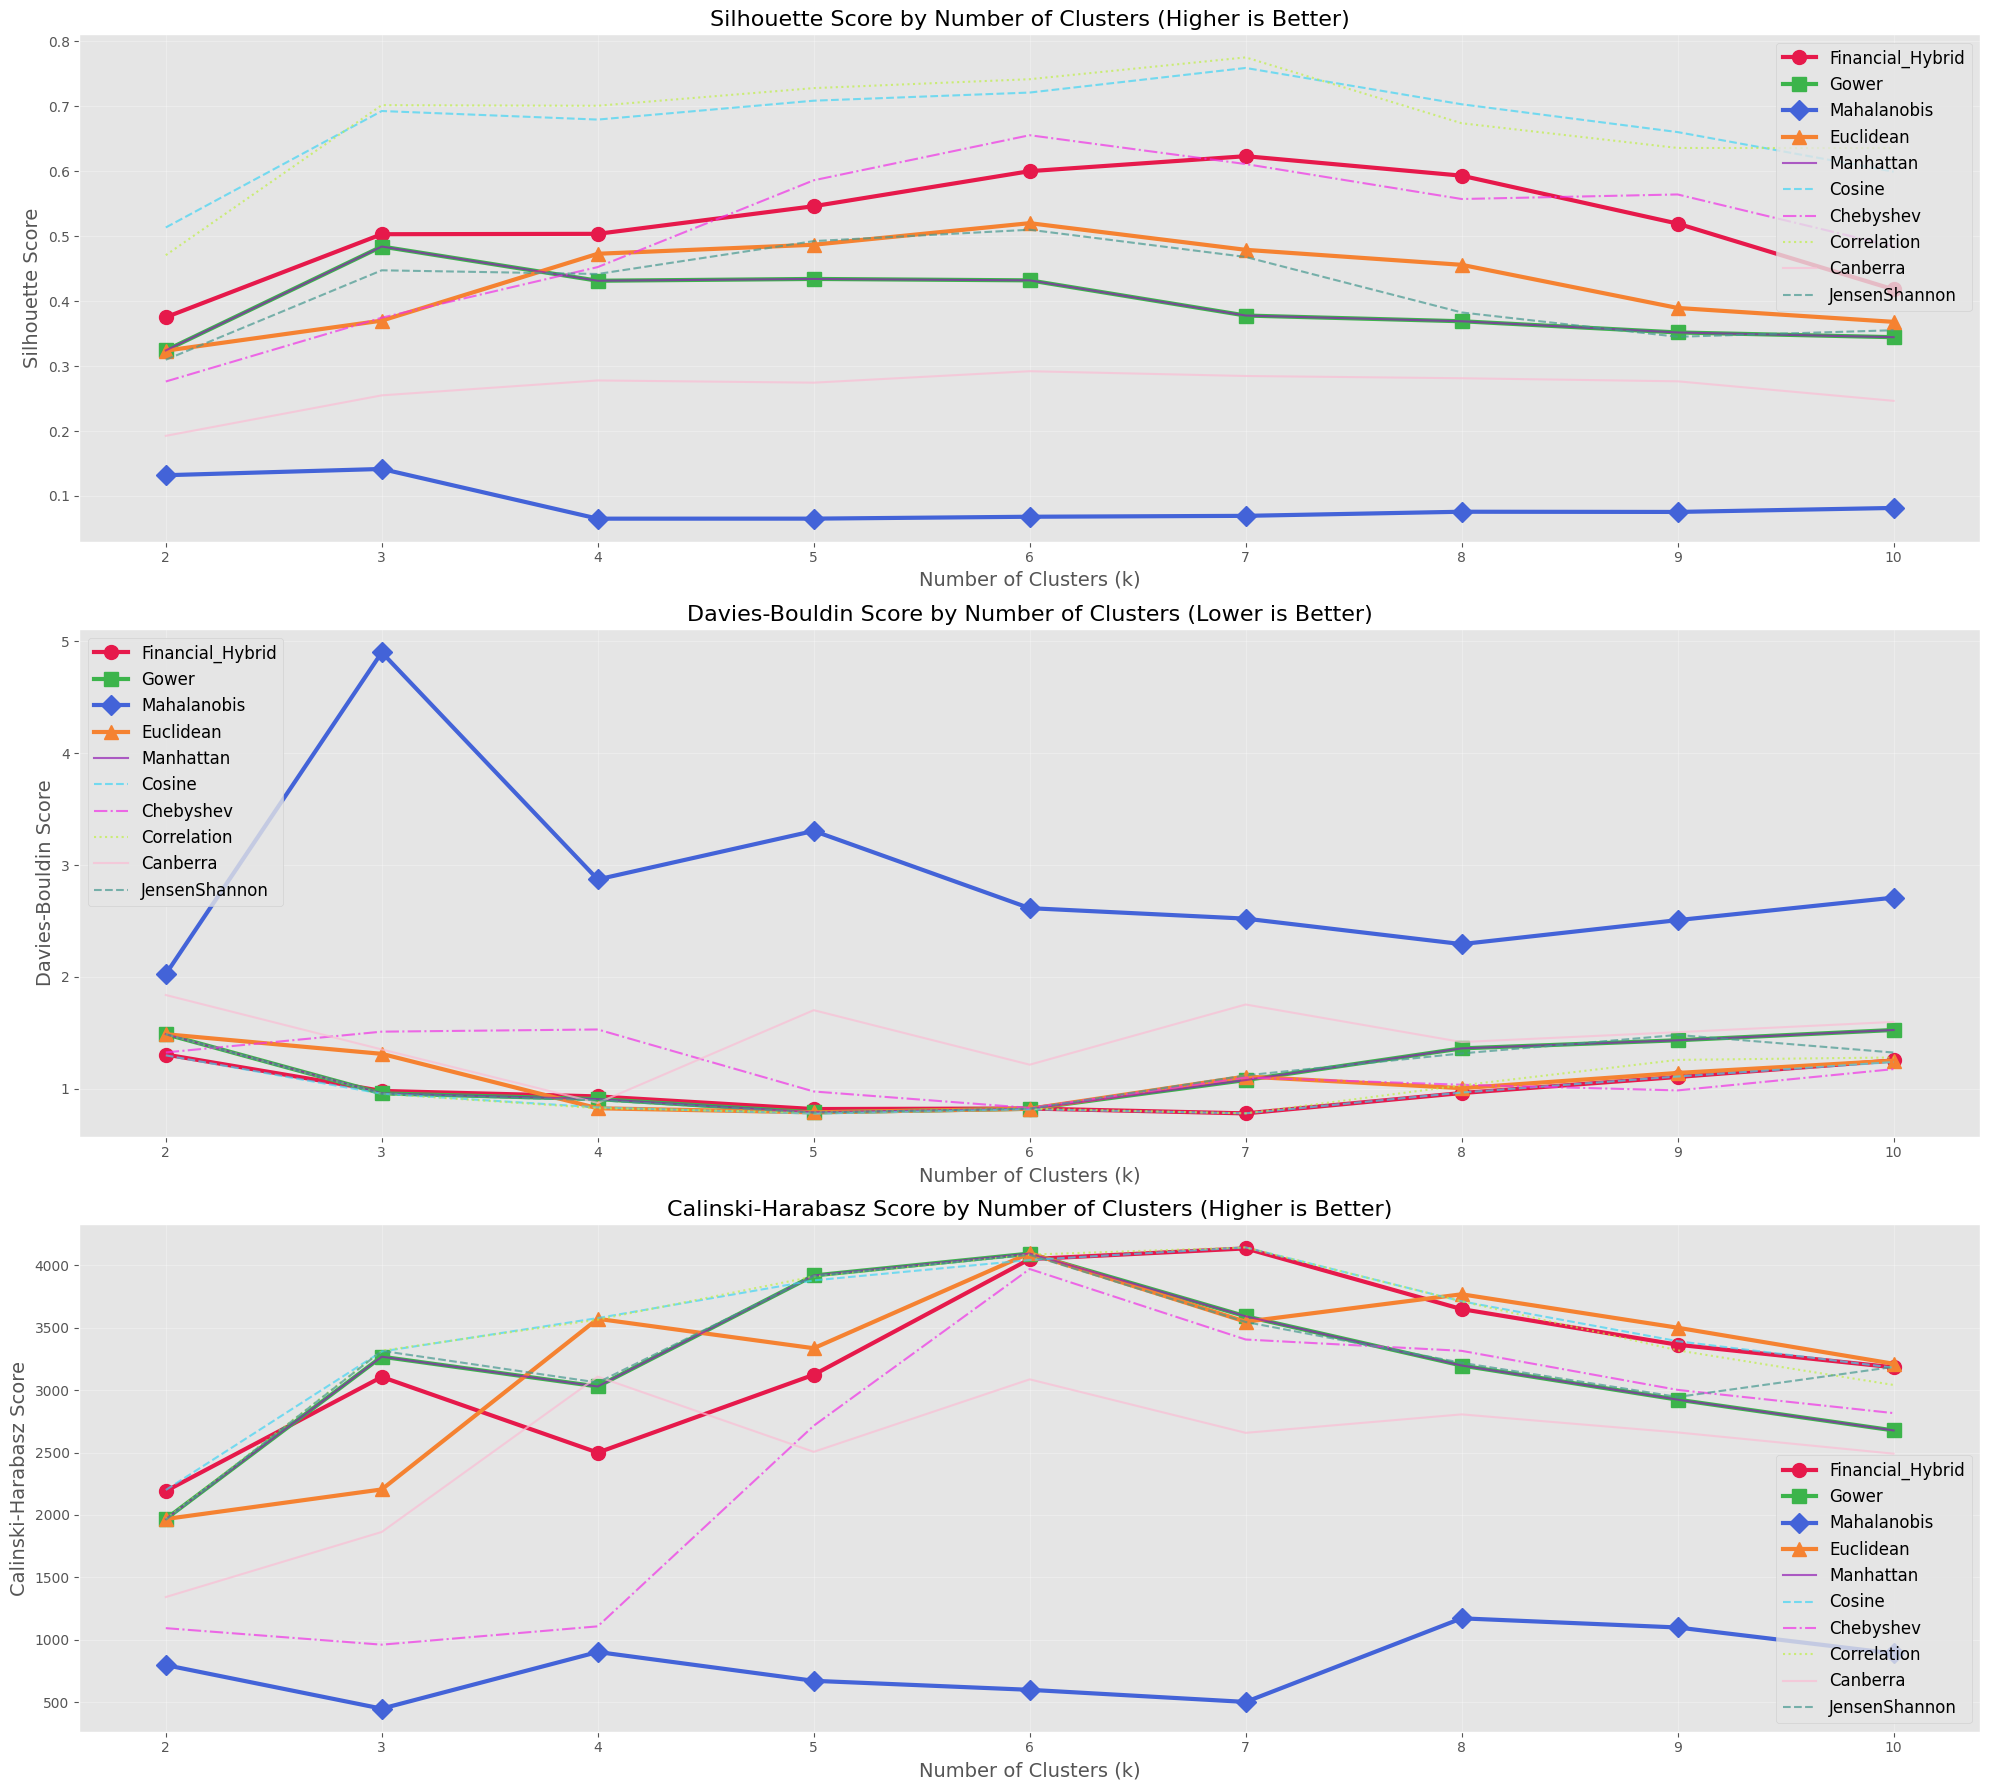


Recommended number of clusters based on evaluation metrics:
 Distance Metric  Silhouette  Davies-Bouldin  Calinski-Harabasz     Consensus
       Euclidean           6               5                  6 6 (2/3 votes)
       Manhattan           3               5                  6 3 (1/3 votes)
          Cosine           7               5                  7 7 (2/3 votes)
       Chebyshev           6               6                  6 6 (3/3 votes)
     Correlation           7               7                  7 7 (3/3 votes)
        Canberra           6               4                  4 4 (2/3 votes)
     Mahalanobis           3               2                  8 3 (1/3 votes)
   JensenShannon           6               5                  6 6 (2/3 votes)
Financial_Hybrid           7               7                  7 7 (3/3 votes)
           Gower           3               5                  6 3 (1/3 votes)

Overall Best Clustering Configuration:
Best overall number of clusters: k=6
Over

In [12]:
# -------------------------
# Visualize Clustering Metrics with Distinct Colors
# -------------------------
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from matplotlib.cm import get_cmap
from cycler import cycler

# Handle NaN values in metrics
for metric_name in evaluation_metrics:
    for metric_type in ["silhouette", "davies_bouldin", "calinski_harabasz"]:
        # Convert to numpy array and replace NaN with 0 for plotting
        values = np.array(evaluation_metrics[metric_name][metric_type])
        evaluation_metrics[metric_name][metric_type] = np.nan_to_num(values, nan=0.0)

# Set up a distinct color palette (colorblind-friendly)
distinct_colors = ['#e6194B', '#3cb44b', '#4363d8', '#f58231', '#911eb4', 
                   '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990',
                   '#dcbeff', '#9A6324', '#800000', '#aaffc3', '#000075']

# Define distinct markers for the highlighted metrics
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'd']

# Create figure
plt.figure(figsize=(20, 18))

# Set up different line styles
line_styles = ['-', '--', '-.', ':']

# 1. Silhouette Score (higher is better)
plt.subplot(3, 1, 1)

# Get metrics to emphasize
highlight_metrics = ["Financial_Hybrid", "Gower", "Mahalanobis", "Euclidean"]
other_metrics = [m for m in evaluation_metrics.keys() if m not in highlight_metrics]

# First plot highlighted metrics with vibrant colors
for i, metric_name in enumerate(highlight_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["silhouette"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["silhouette"], 
        marker=markers[i % len(markers)],
        linestyle='-',
        linewidth=3.0,
        markersize=10,
        color=distinct_colors[i],
        label=f"{metric_name}"
    )

# Then plot other metrics with different styles
for i, metric_name in enumerate(other_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["silhouette"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["silhouette"], 
        linestyle=line_styles[i % len(line_styles)],
        linewidth=1.5,
        color=distinct_colors[(i + len(highlight_metrics)) % len(distinct_colors)],
        alpha=0.7,
        label=metric_name
    )

plt.title('Silhouette Score by Number of Clusters (Higher is Better)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(2, 11, 1))  # Assuming k ranges from 2 to 10

# 2. Davies-Bouldin Score (lower is better)
plt.subplot(3, 1, 2)

# First plot highlighted metrics
for i, metric_name in enumerate(highlight_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["davies_bouldin"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["davies_bouldin"], 
        marker=markers[i % len(markers)],
        linestyle='-',
        linewidth=3.0,
        markersize=10,
        color=distinct_colors[i],
        label=f"{metric_name}"
    )

# Then plot other metrics
for i, metric_name in enumerate(other_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["davies_bouldin"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["davies_bouldin"], 
        linestyle=line_styles[i % len(line_styles)],
        linewidth=1.5,
        color=distinct_colors[(i + len(highlight_metrics)) % len(distinct_colors)],
        alpha=0.7,
        label=metric_name
    )

plt.title('Davies-Bouldin Score by Number of Clusters (Lower is Better)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Davies-Bouldin Score', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(2, 11, 1))

# 3. Calinski-Harabasz Score (higher is better)
plt.subplot(3, 1, 3)

# First plot highlighted metrics
for i, metric_name in enumerate(highlight_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["calinski_harabasz"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["calinski_harabasz"], 
        marker=markers[i % len(markers)],
        linestyle='-',
        linewidth=3.0,
        markersize=10,
        color=distinct_colors[i],
        label=f"{metric_name}"
    )

# Then plot other metrics
for i, metric_name in enumerate(other_metrics):
    if metric_name not in evaluation_metrics or len(evaluation_metrics[metric_name]["calinski_harabasz"]) == 0:
        continue
        
    metrics = evaluation_metrics[metric_name]
    plt.plot(
        metrics["k_values"], 
        metrics["calinski_harabasz"], 
        linestyle=line_styles[i % len(line_styles)],
        linewidth=1.5,
        color=distinct_colors[(i + len(highlight_metrics)) % len(distinct_colors)],
        alpha=0.7,
        label=metric_name
    )

plt.title('Calinski-Harabasz Score by Number of Clusters (Higher is Better)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Calinski-Harabasz Score', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(2, 11, 1))

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300)  # Save high-resolution image
plt.show()

# Rest of the code for the recommendations table remains the same
# ...

# Create a summary table of optimal k values
print("\nRecommended number of clusters based on evaluation metrics:")

recommendations = []
for metric_name, metrics in evaluation_metrics.items():
    # Skip metrics with no values
    if (len(metrics["silhouette"]) == 0 or 
        len(metrics["davies_bouldin"]) == 0 or 
        len(metrics["calinski_harabasz"]) == 0):
        continue
    
    # Find best k for each metric
    try:
        best_k_silhouette = metrics["k_values"][np.argmax(metrics["silhouette"])]
    except:
        best_k_silhouette = "N/A"
        
    try:
        best_k_db = metrics["k_values"][np.argmin(metrics["davies_bouldin"])]
    except:
        best_k_db = "N/A"
        
    try:
        best_k_ch = metrics["k_values"][np.argmax(metrics["calinski_harabasz"])]
    except:
        best_k_ch = "N/A"
    
    # Get consensus (voting)
    valid_suggestions = [k for k in [best_k_silhouette, best_k_db, best_k_ch] if k != "N/A"]
    if valid_suggestions:
        suggestion_counts = Counter(valid_suggestions)
        most_common = suggestion_counts.most_common(1)[0][0]
        consensus = f"{most_common} ({suggestion_counts[most_common]}/{len(valid_suggestions)} votes)"
    else:
        consensus = "N/A"
    
    recommendations.append({
        "Distance Metric": metric_name,
        "Silhouette": best_k_silhouette,
        "Davies-Bouldin": best_k_db,
        "Calinski-Harabasz": best_k_ch,
        "Consensus": consensus
    })

# Display as a nicely formatted table
recom_df = pd.DataFrame(recommendations)
print(recom_df.to_string(index=False))

# Get overall consensus
print("\nOverall Best Clustering Configuration:")
all_valid_recommendations = []
for rec in recommendations:
    if rec["Consensus"] != "N/A" and not isinstance(rec["Consensus"], str):
        value = int(rec["Consensus"].split(" ")[0])
        all_valid_recommendations.append(value)
    elif rec["Consensus"] != "N/A":
        try:
            value = int(rec["Consensus"].split(" ")[0])
            all_valid_recommendations.append(value)
        except:
            pass

if all_valid_recommendations:
    overall_counts = Counter(all_valid_recommendations)
    overall_best_k = overall_counts.most_common(1)[0][0]
    overall_confidence = overall_counts[overall_best_k] / len(all_valid_recommendations)
    
    print(f"Best overall number of clusters: k={overall_best_k}")
    print(f"Overall confidence: {overall_confidence:.1%} of metrics agree")
    
    # Find best distance metric for this k
    best_silhouette = -1
    best_metric = ""
    
    for metric_name, metrics in evaluation_metrics.items():
        if len(metrics["silhouette"]) == 0:
            continue
            
        try:
            k_index = metrics["k_values"].index(overall_best_k)
            if metrics["silhouette"][k_index] > best_silhouette:
                best_silhouette = metrics["silhouette"][k_index]
                best_metric = metric_name
        except:
            pass
    
    if best_metric:
        print(f"Best distance metric: {best_metric} (Silhouette = {best_silhouette:.3f})")

In [13]:
# -------------------------
# Interactive 3D Cluster Visualization
# -------------------------
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings

# Filter out the specific t-SNE warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold._t_sne")

# Set distance metric, number of clusters and perplexity
distance_metric = "Cosine"  # Change this to match your distance_matrices key exactly
num_clusters = 7  # Change this to your desired K value
perplexity_value = 50  # Adjust based on your dataset size

# Verify the selection exists in your results
if distance_metric not in distance_matrices:
    print(f"⚠️ Distance metric '{distance_metric}' not found. Available metrics: {list(distance_matrices.keys())}")
    # Use the first available metric as fallback
    distance_metric = list(distance_matrices.keys())[0]
    print(f"Using '{distance_metric}' instead")

if num_clusters not in cluster_results[distance_metric]:
    print(f"⚠️ K={num_clusters} not found for '{distance_metric}'. Available K values: {list(cluster_results[distance_metric].keys())}")
    # Use the first available K as fallback
    num_clusters = list(cluster_results[distance_metric].keys())[0]
    print(f"Using K={num_clusters} instead")

# Get the distance matrix and labels
dist_matrix = distance_matrices[distance_metric]
labels = cluster_results[distance_metric][num_clusters]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    print(f"⚠️ Distance matrix contains NaN or Inf values - fixing...")
    # Replace NaN/Inf with large values
    dist_matrix = np.nan_to_num(dist_matrix, nan=np.nanmax(dist_matrix)*2, 
                             posinf=np.nanmax(dist_matrix)*2, 
                             neginf=np.nanmin(dist_matrix)*2)

# Compute 3D t-SNE projection with square_distances=True to avoid warnings
tsne = TSNE(
    n_components=3, 
    metric='precomputed', 
    init='random', 
    random_state=42, 
    perplexity=perplexity_value,
    square_distances=True  # Add this to avoid warnings
)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization - make sure cluster is numeric
df_plot = pd.DataFrame({
    'x': X_tsne_3d[:, 0], 
    'y': X_tsne_3d[:, 1], 
    'z': X_tsne_3d[:, 2], 
    'Cluster': labels.astype(int)  # Ensure cluster labels are integers
})

# Add target variables for hover information
df_plot['IncomeInvestment'] = engineered_y_income.values
df_plot['AccumulationInvestment'] = engineered_y_accum.values

# Create the 3D scatter plot using a color map approach
# Define unique colors for each cluster
num_unique_clusters = len(np.unique(labels))
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
]

# Create color mapping
color_map = {i: colors[i % len(colors)] for i in range(num_unique_clusters)}
df_plot['color'] = df_plot['Cluster'].map(color_map)

# Create hover text
hover_text = [
    f"Cluster: {c}<br>Income Need: {i}<br>Accum Need: {a}" 
    for c, i, a in zip(
        df_plot['Cluster'], 
        df_plot['IncomeInvestment'], 
        df_plot['AccumulationInvestment']
    )
]

# Create a separate trace for each cluster for better visualization
fig = go.Figure()

for cluster_id in sorted(df_plot['Cluster'].unique()):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    cluster_hover = [t for i, t in enumerate(hover_text) if df_plot['Cluster'].iloc[i] == cluster_id]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(
            size=5,
            color=color_map[cluster_id],
            opacity=0.8
        ),
        text=cluster_hover,
        hoverinfo='text',
        name=f'Cluster {cluster_id}'
    ))

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization<br>({distance_metric}, k={num_clusters}, perplexity={perplexity_value})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1000,  # Width of the figure
    height=800   # Height of the figure
)

# Display the interactive plot
fig.show()

# Print cluster information
print("\nCluster sizes:")
for cluster in sorted(np.unique(labels)):
    size = np.sum(labels == cluster)
    print(f"  Cluster {cluster}: {size} clients ({size/len(labels)*100:.1f}%)")

# Analyze investment needs by cluster
cluster_df = pd.DataFrame({
    'Cluster': labels,
    'IncomeInvestment': engineered_y_income.values,
    'AccumulationInvestment': engineered_y_accum.values
})

investment_by_cluster = cluster_df.groupby('Cluster')[['IncomeInvestment', 'AccumulationInvestment']].mean() * 100
print("\nInvestment Need Distribution by Cluster:")
print(investment_by_cluster.round(1).astype(str) + '%')


Cluster sizes:
  Cluster 0: 920 clients (18.4%)
  Cluster 1: 1180 clients (23.6%)
  Cluster 2: 414 clients (8.3%)
  Cluster 3: 1151 clients (23.0%)
  Cluster 4: 700 clients (14.0%)
  Cluster 5: 542 clients (10.8%)
  Cluster 6: 93 clients (1.9%)

Investment Need Distribution by Cluster:
        IncomeInvestment AccumulationInvestment
Cluster                                        
0                  27.6%                  58.0%
1                  31.1%                  50.5%
2                  79.0%                  51.2%
3                  35.1%                  47.4%
4                  22.0%                  51.9%
5                  73.4%                  51.3%
6                  15.1%                  39.8%


In [14]:
# -------------------------
# Complete Cluster Centroids Table with All Columns
# -------------------------
import pandas as pd
import numpy as np
from IPython.display import display

# Set pandas to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Wider display
pd.set_option('display.max_colwidth', 20)   # Limit column width for readability

# Create a DataFrame with cluster labels
cluster_data = X_for_clustering.copy()
cluster_data['Cluster'] = labels

# Add investment needs
cluster_data['IncomeInvestment'] = engineered_y_income.values
cluster_data['AccumulationInvestment'] = engineered_y_accum.values

# Calculate mean values for each feature by cluster
centroids = cluster_data.groupby('Cluster').mean()

# Calculate cluster sizes
cluster_sizes = pd.Series(labels).value_counts().sort_index()
size_percentages = (cluster_sizes / len(labels) * 100).round(1)

# Add cluster size information
centroids['Cluster_Size'] = cluster_sizes.values
centroids['Cluster_Percentage'] = size_percentages.values

# Convert the investment needs to percentages for clarity
centroids['IncomeInvestment'] = (centroids['IncomeInvestment'] * 100).round(1)
centroids['AccumulationInvestment'] = (centroids['AccumulationInvestment'] * 100).round(1)

# Round numerical values for better readability
centroids_rounded = centroids.round(3)

# Create a more readable order of columns
# First get all feature columns except the ones we just added
feature_cols = [col for col in centroids.columns 
                if col not in ['Cluster_Size', 'Cluster_Percentage', 
                              'IncomeInvestment', 'AccumulationInvestment']]

# Reorder columns: size metrics first, then investment needs, then features
ordered_cols = ['Cluster_Size', 'Cluster_Percentage', 
                'IncomeInvestment', 'AccumulationInvestment'] + feature_cols

# Reindex to get our preferred column order
if all(col in centroids_rounded.columns for col in ordered_cols):
    centroids_rounded = centroids_rounded[ordered_cols]

# Add % symbol to percentage columns
centroids_display = centroids_rounded.copy()
centroids_display['Cluster_Percentage'] = centroids_display['Cluster_Percentage'].astype(str) + '%'
centroids_display['IncomeInvestment'] = centroids_display['IncomeInvestment'].astype(str) + '%'
centroids_display['AccumulationInvestment'] = centroids_display['AccumulationInvestment'].astype(str) + '%'

# Reset index to make Cluster a column
centroids_display = centroids_display.reset_index()

# Display the table
print("\nCluster Centroids: Mean Value of Each Feature by Cluster")
print("=" * 70)
display(centroids_display)

# If there are still too many columns, you can display them in chunks
if len(centroids_display.columns) > 20:
    print("\nDisplaying columns in chunks for better visibility:")
    
    # Display key metrics
    key_cols = ['Cluster', 'Cluster_Size', 'Cluster_Percentage', 
                'IncomeInvestment', 'AccumulationInvestment']
    print("\nKey Metrics:")
    display(centroids_display[key_cols])
    
    # Display financial features (select some important ones)
    financial_cols = [col for col in centroids_display.columns if 
                     any(term in col for term in ['Wealth', 'Income', 'Financial', 'Risk'])]
    financial_cols = ['Cluster'] + financial_cols[:10]  # Limit to 10 financial features
    print("\nKey Financial Features:")
    display(centroids_display[financial_cols])
    
    # Display demographic features
    demo_cols = [col for col in centroids_display.columns if 
                any(term in col for term in ['Age', 'Gender', 'Family'])]
    demo_cols = ['Cluster'] + demo_cols
    print("\nDemographic Features:")
    display(centroids_display[demo_cols])
    
    # You can continue with more specific feature groups as needed

# Save full table to CSV for external viewing
try:
    csv_path = 'cluster_centroids_full.csv'
    centroids_rounded.to_csv(csv_path)
    print(f"\nFull table with all columns saved to {csv_path}")
except Exception as e:
    print(f"Could not save to CSV: {e}")

# Restore pandas display options to defaults
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


Cluster Centroids: Mean Value of Each Feature by Cluster


Cluster  Cluster_Size Cluster_Percentage IncomeInvestment AccumulationInvestment  Gender  FamilyMembers  Age_Risk_Interaction  Education_Risk_Profile  Age_Squared  Gender_Age_Risk  FinancialEducation_Squared  Wealth_Sqrt  Financial_Sophistication_Ratio  Wealth_to_Income_log  Life_Stage_Adjusted_Income_log  Financial_Sophistication_log  Retirement_Readiness_log  Financial_Fragility_log  life_Young  life_Middle  life_Pre-retirement  life_Retirement  Family_Pressure
0        0           920              18.4%            27.6%                58.0%     0.000          0.373                0.199                 0.235           0.173            0.000                0.260               0.135                0.204                           0.184                 0.512                           0.068                         0.019                     0.436             0.0          1.0                  0.0              0.0            0.466
1        1          1180              23.6%            31.1%                50.5%     1.000          0.384                0.236                 0.193           0.334            0.314                0.227               0.163                0.139                           0.216                 0.476                           0.069                         0.093                     0.467             0.0          0.0                  1.0              0.0            0.476
2        2           414               8.3%            79.0%                51.2%     0.000          0.381                0.272                 0.184           0.548            0.000                0.238               0.249                0.109                           0.293                 0.476                           0.097                         0.327                     0.523             0.0          0.0                  0.0              1.0            0.097
3        3          1151              23.0%            35.1%                47.4%     0.000          0.376                0.253                 0.216           0.329            0.000                0.250               0.180                0.149                           0.225                 0.498                           0.080                         0.089                     0.464             0.0          0.0                  1.0              0.0            0.469
4        4           700              14.0%            22.0%                51.9%     1.000          0.366                0.189                 0.216           0.176            0.255                0.238               0.119                0.193                           0.178                 0.480                           0.063                         0.019                     0.431             0.0          1.0                  0.0              0.0            0.461
5        5           542              10.8%            73.4%                51.3%     1.000          0.387                0.271                 0.175           0.544            0.357                0.215               0.225                0.104                           0.271                 0.467                           0.084                         0.305                     0.519             0.0          0.0                  0.0              1.0            0.099
6        6            93               1.9%            15.1%                39.8%     0.409          0.379                0.139                 0.334           0.046            0.074                0.376               0.090                0.388                           0.151                 0.515                           0.078                         0.010                     0.370             1.0          0.0                  0.0              0.0            0.204


Displaying columns in chunks for better visibility:

Key Metrics:


Cluster  Cluster_Size Cluster_Percentage IncomeInvestment AccumulationInvestment
0        0           920              18.4%            27.6%                58.0%  
1        1          1180              23.6%            31.1%                50.5%  
2        2           414               8.3%            79.0%                51.2%  
3        3          1151              23.0%            35.1%                47.4%  
4        4           700              14.0%            22.0%                51.9%  
5        5           542              10.8%            73.4%                51.3%  
6        6            93               1.9%            15.1%                39.8%


Key Financial Features:


Cluster IncomeInvestment  Age_Risk_Interaction  Education_Risk_Profile  Gender_Age_Risk  FinancialEducation_Squared  Wealth_Sqrt  Financial_Sophistication_Ratio  Wealth_to_Income_log  Life_Stage_Adjusted_Income_log  Financial_Sophistication_log
0        0            27.6%                0.199                 0.235               0.000                0.260               0.135                0.204                           0.184                 0.512                           0.068         
1        1            31.1%                0.236                 0.193               0.314                0.227               0.163                0.139                           0.216                 0.476                           0.069         
2        2            79.0%                0.272                 0.184               0.000                0.238               0.249                0.109                           0.293                 0.476                           0.097         
3        3            35.1%                0.253                 0.216               0.000                0.250               0.180                0.149                           0.225                 0.498                           0.080         
4        4            22.0%                0.189                 0.216               0.255                0.238               0.119                0.193                           0.178                 0.480                           0.063         
5        5            73.4%                0.271                 0.175               0.357                0.215               0.225                0.104                           0.271                 0.467                           0.084         
6        6            15.1%                0.139                 0.334               0.074                0.376               0.090                0.388                           0.151                 0.515                           0.078


Demographic Features:


Cluster  Gender  FamilyMembers  Age_Risk_Interaction  Age_Squared  Gender_Age_Risk  Family_Pressure
0        0   0.000          0.373                0.199         0.173            0.000            0.466
1        1   1.000          0.384                0.236         0.334            0.314            0.476
2        2   0.000          0.381                0.272         0.548            0.000            0.097
3        3   0.000          0.376                0.253         0.329            0.000            0.469
4        4   1.000          0.366                0.189         0.176            0.255            0.461
5        5   1.000          0.387                0.271         0.544            0.357            0.099
6        6   0.409          0.379                0.139         0.046            0.074            0.204


Full table with all columns saved to cluster_centroids_full.csv


In [21]:
# PART 4: ROBUST NEURAL NETWORKS FOR APPLE M4 MAX GPU

print("\n===== Building Robust Neural Network Models for M4 Max GPU =====")

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import class_weight, resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import time
from tqdm.auto import tqdm, trange
import sys
import psutil
import gc
import logging
import datetime
import json
import platform
import math
from contextlib import contextmanager
from functools import partial

# ===== OPTIMIZATION LOGGING SETUP =====
# Create optimization log file
log_filename = f"nn_optimization_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('NNOptimization')

# Add system info logging
def log_system_info():
    """Log detailed system information for optimization reference"""
    system_info = {
        "platform": platform.platform(),
        "processor": platform.processor(),
        "python_version": platform.python_version(),
        "tensorflow_version": tf.__version__,
        "numpy_version": np.__version__,
        "pandas_version": pd.__version__,
        "physical_devices": str(tf.config.list_physical_devices()),
        "memory_total": psutil.virtual_memory().total / (1024**3),  # GB
        "cpu_count": psutil.cpu_count(logical=False),
        "cpu_threads": psutil.cpu_count(logical=True)
    }
    
    # Try to get GPU info if available
    try:
        import subprocess
        result = subprocess.run(['system_profiler', 'SPDisplaysDataType'], 
                               capture_output=True, text=True)
        gpu_info = result.stdout
        system_info["gpu_info"] = gpu_info
    except:
        system_info["gpu_info"] = "Could not retrieve GPU info"
    
    logger.info(f"SYSTEM INFO: {json.dumps(system_info)}")
    print("System info logged for optimization reference")

# Time profiling context manager
@contextmanager
def timer_log(name):
    """Context manager to time operations and log them"""
    start_time = time.time()
    memory_before = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
    
    try:
        yield
    finally:
        end_time = time.time()
        duration = end_time - start_time
        memory_after = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        memory_diff = memory_after - memory_before
        
        logger.info(f"OPERATION: {name} - Duration: {duration:.2f}s - Memory: {memory_diff:.2f}MB")

# ===== GPU CONFIGURATION =====
os.environ['TF_ENABLE_MPS_UPLOAD_TENSORS'] = '1'
os.environ['TF_MPS_ENABLE_ASYNC_PROGRAMMING'] = '1'
os.environ['TF_MPS_ALLOW_GROWTH'] = 'true'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_MPS_MEMORY_ALLOCATION_RATIO'] = '0.95' 
os.environ['TF_MPS_MAX_COPY_STREAMING_INFLIGHT_RATIO'] = '0.9'

# Log system info at startup
log_system_info()

# Enable Metal Performance Shaders (MPS) for Apple Silicon
print("Checking GPU availability...")
physical_devices = tf.config.list_physical_devices()
print(f"Available devices: {physical_devices}")

# Enable mixed precision for faster training
print("Enabling mixed precision training...")
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create directory for saving models
if not os.path.exists('models'):
    os.makedirs('models')

# Simple GPU warm-up function
def warm_up_gpu():
    """Simple GPU warm-up that won't cause errors"""
    print("Warming up GPU...")
    with timer_log("gpu_warmup"):
        try:
            # Try to use GPU but fall back to CPU if needed
            try:
                device = '/device:GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/device:CPU:0'
                with tf.device(device):
                    # Simple matrix multiplication
                    a = tf.random.normal((1000, 1000), dtype=tf.float32)
                    b = tf.random.normal((1000, 1000), dtype=tf.float32)
                    c = tf.matmul(a, b)
                    _ = c.numpy()
            except:
                # Fall back to CPU
                a = tf.random.normal((1000, 1000), dtype=tf.float32)
                b = tf.random.normal((1000, 1000), dtype=tf.float32)
                c = tf.matmul(a, b)
                _ = c.numpy()
        except Exception as e:
            print(f"Warning: GPU warm-up failed: {e}")
    
    print("GPU warm-up complete")
    # Force garbage collection
    gc.collect()
    tf.keras.backend.clear_session()

# Run GPU warm-up
warm_up_gpu()

# Simple GPU monitoring callback
class GPUMonitorCallback(tf.keras.callbacks.Callback):
    """Simple GPU monitoring callback"""
    def __init__(self):
        super().__init__()
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        
        # Log metrics
        if logs:
            metrics_log = {k: float(v) for k, v in logs.items()}
            metrics_log["epoch"] = epoch
            metrics_log["duration"] = epoch_time
            logger.info(f"EPOCH_METRICS: {json.dumps(metrics_log)}")
        
        # Perform garbage collection every 5 epochs
        if epoch % 5 == 0:
            gc.collect()

# Custom progress bar callback
class ProgressBarCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, metrics=['loss', 'accuracy', 'val_loss', 'val_accuracy']):
        self.epochs = epochs
        self.metrics = metrics
        self.start_time = None
        self.pbar = None
        
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.pbar = tqdm(total=self.epochs, desc='Training', position=0)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate time per epoch and ETA
        elapsed = time.time() - self.start_time
        time_per_epoch = elapsed / (epoch + 1)
        eta = time_per_epoch * (self.epochs - epoch - 1)
        
        # Create status message
        status = f"Epoch {epoch+1}/{self.epochs}"
        for metric in self.metrics:
            if metric in logs:
                status += f" - {metric}: {logs[metric]:.4f}"
        
        status += f" - {time_per_epoch:.2f}s/epoch - ETA: {eta:.0f}s"
        
        # Update progress bar
        self.pbar.set_description(status)
        self.pbar.update(1)
        
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        self.pbar.set_description(f"Training completed in {total_time:.2f}s")
        self.pbar.close()

# COMPLETELY REVISED DATASET CREATION FUNCTION
def create_robust_dataset(X, y, batch_size=32, is_training=True, name="dataset"):
    """Create a robust TensorFlow dataset that works reliably with small datasets"""
    with timer_log(f"dataset_creation_{name}"):
        # Get dataset size
        n_samples = len(X)
        
        # Calculate a safe batch size (never more than 1/3 of dataset)
        safe_batch_size = min(batch_size, max(1, n_samples // 3))
        if safe_batch_size < batch_size:
            print(f"⚠️ Reduced batch size from {batch_size} to {safe_batch_size} for dataset with {n_samples} samples")
            
        # Convert to tensors with explicit dtypes
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
        y_tensor = tf.reshape(y_tensor, (-1, 1))  # Ensure consistent shape
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
        
        # Apply simple operations that work well with small datasets
        if is_training and n_samples > 10:
            # Only shuffle if enough data, with appropriate buffer size
            buffer_size = min(n_samples, 1000)
            dataset = dataset.shuffle(buffer_size=buffer_size, seed=42)
        
        # Batch with drop_remainder=False to handle uneven batches
        dataset = dataset.batch(safe_batch_size, drop_remainder=False)
        
        # Simple prefetch with constant value (AUTOTUNE can cause issues)
        dataset = dataset.prefetch(1)
        
        logger.info(f"DATASET_CREATED: {name} - Size: {n_samples} samples - Batch size: {safe_batch_size}")
        return dataset

# Simple batch size finder
def find_safe_batch_size(X, y):
    """Find a safe batch size for this dataset size"""
    n_samples = len(X)
    
    # For tiny datasets, use very small batches
    if n_samples < 100:
        safe_size = max(1, min(16, n_samples // 2))
        logger.info(f"Tiny dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For small datasets
    if n_samples < 500:
        safe_size = max(16, min(32, n_samples // 4))
        logger.info(f"Small dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For medium datasets
    if n_samples < 2000:
        safe_size = max(32, min(64, n_samples // 10))
        logger.info(f"Medium dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For large datasets
    safe_size = max(64, min(128, n_samples // 20))
    logger.info(f"Large dataset ({n_samples} samples), using batch size: {safe_size}")
    return safe_size

# Custom focal loss for imbalanced data
def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss with gamma focus parameter"""
    def focal_loss_fixed(y_true, y_pred):
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        focal_weight = tf.pow(1-pt, gamma)
        return -alpha * focal_weight * tf.math.log(tf.clip_by_value(pt, 1e-7, 1))
    return focal_loss_fixed

# Create a small model for smaller clusters
def create_small_model(input_dim, learning_rate=0.001, l2_reg=0.001, dropout_rate=0.4):
    """Simple robust model for small clusters"""
    with timer_log(f"small_model_creation_dim{input_dim}"):
        # Start with CPU for reliability
        with tf.device('/device:CPU:0'):
            inputs = tf.keras.Input(shape=(input_dim,))
            
            # Feature extraction
            x = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            
            # Simple residual connection
            residual = x
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.add([x, residual])
            
            # Output layer
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate/2)(x)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0  # Add gradient clipping for stability
            )
            
            # Compile with focal loss for imbalanced data
            model.compile(
                optimizer=optimizer,
                loss=focal_loss(gamma=2.0, alpha=0.25),
                metrics=[
                    'accuracy', 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()
                ]
            )
        
        logger.info(f"SMALL_MODEL_CREATED: input_dim={input_dim}, params={model.count_params()}")
        return model

# Create a medium model for medium-sized clusters
def create_medium_model(input_dim, learning_rate=0.001, l2_reg=0.001, dropout_rate=0.3):
    """Medium-sized model for balanced performance"""
    with timer_log(f"medium_model_creation_dim{input_dim}"):
        # Start with CPU for reliability
        with tf.device('/device:CPU:0'):
            inputs = tf.keras.Input(shape=(input_dim,))
            
            # Feature extraction
            x = tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            
            # Residual block
            residual = x
            x = tf.keras.layers.Dense(256, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            x = tf.keras.layers.Dense(256)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.add([x, residual])
            
            # Additional layers
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate/2)(x)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
            
            # Compile with focal loss for imbalanced data
            model.compile(
                optimizer=optimizer,
                loss=focal_loss(gamma=2.0, alpha=0.25),
                metrics=[
                    'accuracy', 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()
                ]
            )
        
        logger.info(f"MEDIUM_MODEL_CREATED: input_dim={input_dim}, params={model.count_params()}")
        return model

# Enhanced feature generation
def generate_advanced_features(X):
    """Generate advanced features safely"""
    with timer_log("feature_generation"):
        # Make a copy to avoid modifying the original
        X_new = X.copy()
        
        # Get numeric columns safely
        numeric_cols = X.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
        
        # If no numeric columns or too many, return the original
        if not numeric_cols or len(numeric_cols) > 100:
            return X
        
        # Limit to top 5 numeric columns to avoid explosion
        if len(numeric_cols) > 5:
            numeric_cols = numeric_cols[:5]
            
        try:
            # Add squared terms for key numeric columns
            for col in numeric_cols:
                X_new[f"{col}_squared"] = X[col] ** 2
                
            # Add log transforms for positive columns
            for col in numeric_cols:
                if X[col].min() > 0:  # Only apply to positive columns
                    X_new[f"{col}_log"] = np.log1p(X[col])
            
            # Add simple interactions (only if not too many)
            if len(numeric_cols) <= 5:
                for i, col1 in enumerate(numeric_cols):
                    for col2 in numeric_cols[i+1:]:
                        X_new[f"{col1}_x_{col2}"] = X[col1] * X[col2]
        except Exception as e:
            print(f"Warning: Error in feature generation: {e}. Using original features.")
            return X
            
        logger.info(f"FEATURE_GENERATION: Original columns: {X.shape[1]}, New columns: {X_new.shape[1]}")
        return X_new

# Simple history plotting function
def plot_training_history(history, cluster_id, target_name):
    """Simple, reliable history plotting function"""
    try:
        plt.figure(figsize=(12, 5))
        
        # Ensure history has data
        if not history.history or len(history.history) == 0:
            print("Warning: No history data available to plot")
            return
            
        # Get available metrics
        metrics = list(history.history.keys())
        val_metrics = [m for m in metrics if m.startswith('val_')]
        train_metrics = [m for m in metrics if not m.startswith('val_')]
        
        # Plot loss if available
        if 'loss' in train_metrics and 'val_loss' in val_metrics:
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title(f'Cluster {cluster_id} - {target_name} Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right')
        
        # Plot accuracy or AUC if available
        metric_to_plot = None
        val_metric_to_plot = None
        
        if 'accuracy' in train_metrics and 'val_accuracy' in val_metrics:
            metric_to_plot = 'accuracy'
            val_metric_to_plot = 'val_accuracy'
            metric_name = 'Accuracy'
        elif 'auc' in train_metrics and 'val_auc' in val_metrics:
            metric_to_plot = 'auc'
            val_metric_to_plot = 'val_auc' 
            metric_name = 'AUC'
            
        if metric_to_plot and val_metric_to_plot:
            plt.subplot(1, 2, 2)
            plt.plot(history.history[metric_to_plot])
            plt.plot(history.history[val_metric_to_plot])
            plt.title(f'Cluster {cluster_id} - {target_name} {metric_name}')
            plt.ylabel(metric_name)
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.tight_layout()
        plt.savefig(f"cluster_{cluster_id}_{target_name}_history.png", dpi=300)
        plt.show()
    except Exception as e:
        print(f"Warning: Error plotting history: {e}")

# Create dictionaries to store data and models for each cluster
income_models = {}
accum_models = {}

# Add engineered features and target variables
df_for_nn = engineered_df.copy()
df_for_nn['cluster'] = labels

# Display cluster distribution
print("Cluster distribution:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples ({count/len(labels)*100:.1f}%)")

# Constants for cluster sizing
SMALL_CLUSTER_THRESHOLD = 200
MEDIUM_CLUSTER_THRESHOLD = 500

# Function to print section header
def print_section(title):
    print(f"\n{'=' * 80}")
    print(f" {title}")
    print(f"{'=' * 80}")

# Process each cluster
for cluster_id in np.unique(labels):
    try:
        print_section(f"PROCESSING CLUSTER {cluster_id} ({list(np.unique(labels)).index(cluster_id) + 1}/{len(np.unique(labels))} clusters)")
        
        # Filter data for this cluster
        cluster_df = df_for_nn[df_for_nn['cluster'] == cluster_id]
        
        # Skip very small clusters
        if len(cluster_df) < 30:
            print(f"⚠️ Cluster {cluster_id} has only {len(cluster_df)} samples. Skipping...")
            continue
        
        # For each target variable
        for target_name in ['IncomeInvestment', 'AccumulationInvestment']:
            print_section(f"TRAINING MODEL FOR {target_name} IN CLUSTER {cluster_id}")
            
            # Prepare features and target
            X = cluster_df.drop(['IncomeInvestment', 'AccumulationInvestment', 'cluster'], axis=1)
            y = cluster_df[target_name]
            
            # Apply enhanced feature engineering (if cluster is large enough)
            if len(X) > 100:
                print("Generating advanced features... ", end='')
                start_time = time.time()
                X = generate_advanced_features(X)
                print(f"Done in {time.time() - start_time:.2f}s. New shape: {X.shape}")
            
            # One-hot encode categorical features
            start_time = time.time()
            print(f"One-hot encoding features... ", end='')
            X = pd.get_dummies(X)
            print(f"Done in {time.time() - start_time:.2f}s. Shape: {X.shape}")
            
            # Train-test split with stratification
            print("Splitting data into train/test sets... ", end='')
            start_time = time.time()
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            print(f"Done in {time.time() - start_time:.2f}s")
            print(f"Training set: {X_train.shape[0]} samples | Test set: {X_test.shape[0]} samples")
            print(f"Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
            
            # Handle imbalanced data with simple resampling
            print("Handling class imbalance...")
            start_time = time.time()
            
            # Get minority and majority classes
            minority_class = 1 if sum(y_train == 1) < sum(y_train == 0) else 0
            majority_class = 1 - minority_class
            
            # Create a DataFrame with features and target
            train_data = X_train.copy()
            train_data[target_name] = y_train
            
            # Get samples from each class
            minority_samples = train_data[train_data[target_name] == minority_class]
            majority_samples = train_data[train_data[target_name] == majority_class]
            
            # Only balance if significant imbalance exists
            if len(minority_samples) < len(majority_samples) * 0.7:
                # Balance by oversampling minority class
                n_to_sample = min(len(majority_samples), len(minority_samples) * 3)
                minority_upsampled = resample(
                    minority_samples,
                    replace=True,
                    n_samples=n_to_sample,
                    random_state=42
                )
                
                # Combine and extract features/target
                balanced_data = pd.concat([majority_samples, minority_upsampled])
                X_train = balanced_data.drop([target_name], axis=1)
                y_train = balanced_data[target_name]
                
                print(f"Balanced dataset in {time.time() - start_time:.2f}s. New training set: {len(X_train)} samples")
                print(f"New class distribution: {pd.Series(y_train).value_counts().to_dict()}")
            else:
                print("Class distribution is already reasonably balanced. Skipping balancing.")
            
            # Scale features with RobustScaler
            print("Scaling features... ", end='')
            start_time = time.time()
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            print(f"Done in {time.time() - start_time:.2f}s")
            
            # Calculate class weights
            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
            
            # Find a safe batch size based on dataset size
            batch_size = find_safe_batch_size(X_train, y_train)
            print(f"Using batch size of {batch_size} for this dataset")
            
            # Create TensorFlow datasets
            print("Creating TensorFlow datasets...")
            train_dataset = create_robust_dataset(
                X_train_scaled, y_train, 
                batch_size=batch_size, 
                is_training=True,
                name=f"train_cluster{cluster_id}_{target_name}"
            )
            
            test_dataset = create_robust_dataset(
                X_test_scaled, y_test, 
                batch_size=batch_size, 
                is_training=False,
                name=f"test_cluster{cluster_id}_{target_name}"
            )
            
            # Determine model size based on cluster size
            is_small_cluster = len(cluster_df) < SMALL_CLUSTER_THRESHOLD
            is_medium_cluster = len(cluster_df) < MEDIUM_CLUSTER_THRESHOLD
            
            # Clear memory before creating model
            tf.keras.backend.clear_session()
            gc.collect()
            
            # Create model based on cluster size
            if is_small_cluster:
                print("Using small model architecture for small cluster...")
                model = create_small_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.001,
                    dropout_rate=0.3
                )
                
                # Use fewer epochs for small clusters
                epochs = 200
            elif is_medium_cluster:
                print("Using medium model architecture for medium cluster...")
                model = create_medium_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.001,
                    dropout_rate=0.3
                )
                
                # Use moderate epochs for medium clusters
                epochs = 300
            else:
                print("Using medium model architecture for large cluster...")
                model = create_medium_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.0001,
                    dropout_rate=0.4
                )
                
                # Use more epochs for large clusters
                epochs = 400
            
            # Create callbacks
            checkpoint_path = f"models/cluster_{cluster_id}_{target_name}.h5"
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_auc', 
                    patience=50, 
                    restore_best_weights=True,
                    mode='max'
                ),
                ModelCheckpoint(
                    filepath=checkpoint_path,
                    monitor='val_auc',
                    mode='max',
                    save_best_only=True
                ),
                ProgressBarCallback(epochs=epochs, metrics=['loss', 'auc', 'val_loss', 'val_auc']),
                GPUMonitorCallback()
            ]
            
            # Train model
            print(f"Training model for up to {epochs} epochs...")
            start_time = time.time()
            history = model.fit(
                train_dataset,
                epochs=epochs,
                validation_data=test_dataset,
                callbacks=callbacks,
                class_weight=class_weight_dict,
                verbose=1
            )
            training_time = time.time() - start_time
            print(f"Training completed in {training_time:.2f}s")
            
            # Evaluate model
            print("Evaluating model...")
            
            # Get predictions
            y_pred_prob = model.predict(test_dataset, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int)
            
            # Get true labels
            y_test_list = []
            for _, y_batch in test_dataset:
                y_test_list.append(y_batch.numpy())
            y_test_array = np.concatenate(y_test_list, axis=0)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test_array, y_pred)
            precision = precision_score(y_test_array, y_pred, zero_division=0)
            recall = recall_score(y_test_array, y_pred, zero_division=0)
            f1 = f1_score(y_test_array, y_pred, zero_division=0)
            
            # Only calculate AUC if we have both classes
            if len(np.unique(y_test_array)) > 1:
                auc = roc_auc_score(y_test_array, y_pred_prob)
                # Also calculate PR AUC (precision-recall AUC) - better for imbalanced data
                pr_auc = average_precision_score(y_test_array, y_pred_prob)
            else:
                auc = 0.5  # Default for single class
                pr_auc = 0.5  # Default for single class
            
            # Print metrics
            print("\n📊 MODEL PERFORMANCE:")
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"ROC AUC:   {auc:.4f}")
            print(f"PR AUC:    {pr_auc:.4f}")
            
            # Store model and data
            model_info = {
                'model': model,
                'scaler': scaler,
                'feature_names': X.columns.tolist(),
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc,
                    'pr_auc': pr_auc
                },
                'training_time': training_time
            }
            
            if target_name == 'IncomeInvestment':
                income_models[cluster_id] = model_info
            else:
                accum_models[cluster_id] = model_info
            
            # Plot training history
            plot_training_history(history, cluster_id, target_name)
            
            # Clear memory before next model
            tf.keras.backend.clear_session()
            gc.collect()

    except Exception as e:
        print(f"Error processing cluster {cluster_id}: {e}")
        import traceback
        traceback.print_exc()
        print("Continuing to next cluster...")
        continue

# Visualize the comparison of models if we have any
metrics_comparison = []

if income_models or accum_models:
    print(f"Number of Income models: {len(income_models)}")
    print(f"Number of Accumulation models: {len(accum_models)}")
    
    for model_type, models_dict in [('Income', income_models), ('Accumulation', accum_models)]:
        for cluster_id, model_data in models_dict.items():
            try:
                metrics_comparison.append({
                    'Model Type': model_type,
                    'Cluster': f'Cluster {cluster_id}',
                    'Accuracy': model_data['metrics']['accuracy'],
                    'Precision': model_data['metrics']['precision'],
                    'Recall': model_data['metrics']['recall'],
                    'F1 Score': model_data['metrics']['f1'],
                    'AUC': model_data['metrics']['auc'],
                    'PR AUC': model_data['metrics']['pr_auc']
                })
            except KeyError as e:
                print(f"Warning: Missing metric {e} for {model_type} model in cluster {cluster_id}")
    
    # Create visualization if we have comparison data
    if metrics_comparison:
        metrics_df = pd.DataFrame(metrics_comparison)
        
        print_section("MODEL COMPARISON")
        
        try:
            plt.figure(figsize=(18, 12))
            
            metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
            
            for i, metric in enumerate(metrics_to_plot):
                plt.subplot(2, 2, i+1)
                sns.barplot(x='Cluster', y=metric, hue='Model Type', data=metrics_df)
                plt.title(f'{metric} by Cluster', fontsize=14)
                plt.xticks(rotation=45)
                plt.ylim(0, 1)
            
            plt.tight_layout()
            plt.savefig('cluster_model_comparison.png', dpi=300)
            plt.show()
            
            # Create a simple performance summary
            performance_summary = {
                "clusters_processed": len(income_models) + len(accum_models),
                "total_models": len(metrics_comparison),
                "average_metrics": {
                    "accuracy": float(np.mean(metrics_df['Accuracy'])),
                    "precision": float(np.mean(metrics_df['Precision'])),
                    "recall": float(np.mean(metrics_df['Recall'])),
                    "f1_score": float(np.mean(metrics_df['F1 Score'])),
                    "auc": float(np.mean(metrics_df['AUC'])),
                    "pr_auc": float(np.mean(metrics_df['PR AUC']))
                }
            }
            
            # Log performance summary
            logger.info(f"PERFORMANCE_SUMMARY: {json.dumps(performance_summary)}")
            
            # Print final report
            print("\n===== FINAL REPORT =====")
            print(f"Successfully trained {performance_summary['total_models']} models across {performance_summary['clusters_processed']} clusters")
            print("\nAverage metrics across all models:")
            for metric, value in performance_summary['average_metrics'].items():
                print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        except Exception as e:
            print(f"Error in visualization: {e}")
else:
    print("No models were successfully trained. Check for errors in the logs.")

print("\n===== Neural Network Models Complete =====")
print("✅ Cluster-specific neural networks have been trained")
print("✅ Model checkpoints saved to 'models/' directory")
print(f"✅ Performance logs saved to {log_filename}")


===== Building Robust Neural Network Models for M4 Max GPU =====
System info logged for optimization reference
Checking GPU availability...
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Enabling mixed precision training...
Warming up GPU...
GPU warm-up complete


2025-04-05 15:23:34.945649: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-05 15:23:34.945689: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-04-05 15:23:34.945692: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2025-04-05 15:23:34.945707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 15:23:34.945717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Cluster distribution:
Cluster 0: 920 samples (18.4%)
Cluster 1: 1180 samples (23.6%)
Cluster 2: 414 samples (8.3%)
Cluster 3: 1151 samples (23.0%)
Cluster 4: 700 samples (14.0%)
Cluster 5: 542 samples (10.8%)
Cluster 6: 93 samples (1.9%)

 PROCESSING CLUSTER 0 (1/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 0
Generating advanced features... Done in 0.00s. New shape: (920, 37)
One-hot encoding features... Done in 0.00s. Shape: (920, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 736 samples | Test set: 184 samples
Class distribution: {0.0: 533, 1.0: 203}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 1066 samples
New class distribution: {0.0: 533, 1.0: 533}
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 64 to 61 for dataset with 184 samples
Using medium model architecture for large cluster...
Training model for up to 400 epochs...


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400


2025-04-05 15:23:36.251203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5586 - auc: 0.5711 - loss: 0.1629 - precision: 0.5391 - recall: 0.5566 - val_accuracy: 0.3804 - val_auc: 0.5610 - val_loss: 0.0666 - val_precision: 0.2968 - val_recall: 0.9020
Epoch 2/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5203 - auc: 0.5173 - loss: 0.1083 - precision: 0.5086 - recall: 0.5641 - val_accuracy: 0.3804 - val_auc: 0.4987 - val_loss: 0.0669 - val_precision: 0.2558 - val_recall: 0.6471
Epoch 3/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5346 - auc: 0.5864 - loss: 0.0756 - precision: 0.5417 - recall: 0.5781 - val_accuracy: 0.5707 - val_auc: 0.5662 - val_loss: 0.0473 - val_precision: 0.3056 - val_recall: 0.4314
Epoch 4/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5483 - auc: 0.5910 - loss: 0.0609 - precision: 0.5611 - recall: 0.5236 - val_accuracy: 0.5163 - val_auc: 0.6001 - val_loss: 0.0473 - val_precision: 0.3173 - val_recall: 0.6471
Epoch 5/400
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

KeyboardInterrupt: 


===== Building Robust Neural Network Models for M4 Max GPU =====
System info logged for optimization reference
Checking GPU availability...
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Enabling mixed precision training...
Warming up GPU...
GPU warm-up complete
Cluster distribution:
Cluster 0: 920 samples (18.4%)
Cluster 1: 1180 samples (23.6%)
Cluster 2: 414 samples (8.3%)
Cluster 3: 1151 samples (23.0%)
Cluster 4: 700 samples (14.0%)
Cluster 5: 542 samples (10.8%)
Cluster 6: 93 samples (1.9%)

 PROCESSING CLUSTER 0 (1/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 0
Generating advanced features... Done in 0.00s. New shape: (920, 37)
One-hot encoding features... Done in 0.00s. Shape: (920, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 736 samples | Test set: 184 samples
Class distribution: {0.0: 533, 1.0: 203}
Handling class imbalance...
Bal

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5912 - auc: 0.6081 - loss: 0.1503 - precision: 0.5736 - recall: 0.5566 - val_accuracy: 0.5109 - val_auc: 0.5860 - val_loss: 0.0566 - val_precision: 0.3211 - val_recall: 0.6863
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5581 - auc: 0.5854 - loss: 0.1044 - precision: 0.5448 - recall: 0.5745 - val_accuracy: 0.4348 - val_auc: 0.5028 - val_loss: 0.0637 - val_precision: 0.2569 - val_recall: 0.5490
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5555 - auc: 0.6018 - loss: 0.0746 - precision: 0.5585 - recall: 0.6159 - val_accuracy: 0.6087 - val_auc: 0.4674 - val_loss: 0.0478 - val_precision: 0.2667 - val_recall: 0.2353
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5720 - auc: 0.5994 - loss: 0.0701 - precision: 0.5864 - recall: 0.5420 - val_accuracy: 0.6848 - val_auc: 0.5525 - val_loss: 0.0443 - val_precision: 0.3478 - val_recall: 0.1569
Epoch 5/1000
17/17 ━━━━━━━━━

2025-04-04 22:41:02.424860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


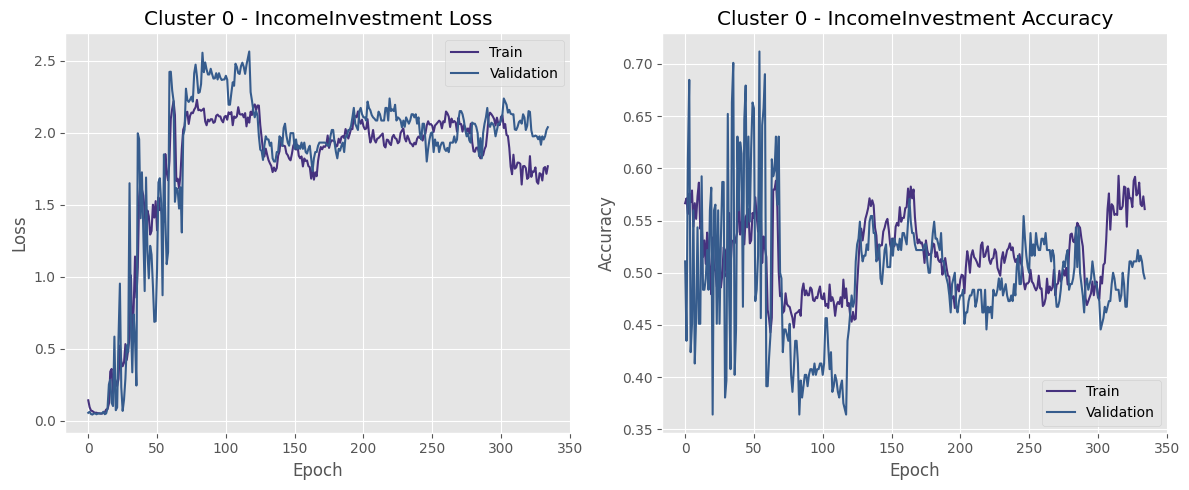


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 0
Generating advanced features... Done in 0.00s. New shape: (920, 37)
One-hot encoding features... Done in 0.00s. Shape: (920, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 736 samples | Test set: 184 samples
Class distribution: {1.0: 427, 0.0: 309}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 64 to 61 for dataset with 184 samples
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.5761 - auc: 0.6135 - loss: 0.2040 - precision: 0.6501 - recall: 0.5440 - val_accuracy: 0.6467 - val_auc: 0.6836 - val_loss: 0.0588 - val_precision: 0.7283 - val_recall: 0.6262
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5803 - auc: 0.6133 - loss: 0.1385 - precision: 0.6382 - recall: 0.6444 - val_accuracy: 0.5924 - val_auc: 0.6993 - val_loss: 0.0613 - val_precision: 0.8077 - val_recall: 0.3925
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6259 - auc: 0.6570 - loss: 0.1196 - precision: 0.7183 - recall: 0.5818 - val_accuracy: 0.7120 - val_auc: 0.7696 - val_loss: 0.0437 - val_precision: 0.6985 - val_recall: 0.8879
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6351 - auc: 0.6686 - loss: 0.0893 - precision: 0.6759 - recall: 0.6926 - val_accuracy: 0.7446 - val_auc: 0.7861 - val_loss: 0.0414 - val_precision: 0.7830 - val_recall: 0.7757
Epoch 5/1000
12/12 ━━━━━━━━

2025-04-04 22:43:17.541867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


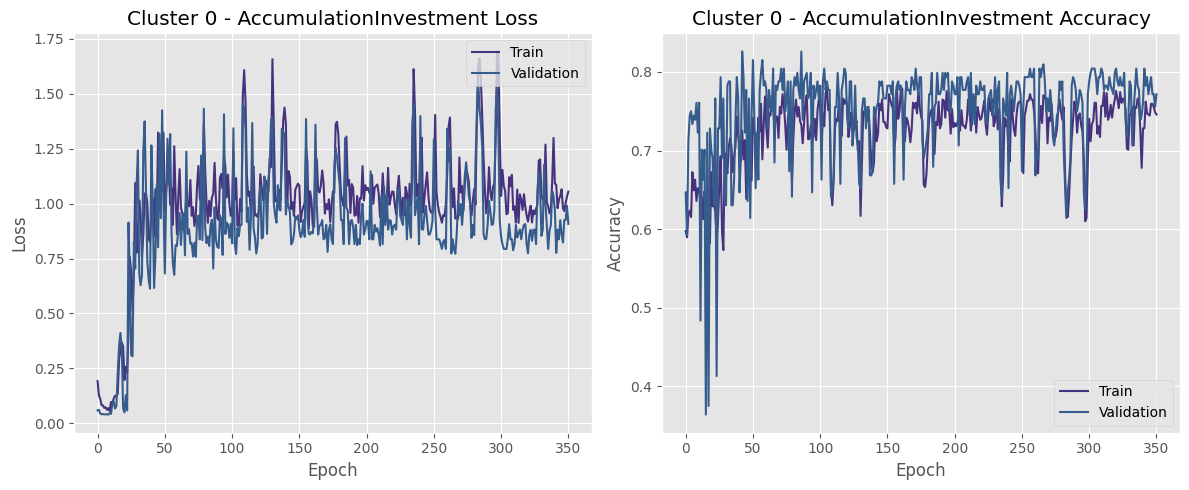


 PROCESSING CLUSTER 1 (2/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 1
Generating advanced features... Done in 0.00s. New shape: (1180, 38)
One-hot encoding features... Done in 0.00s. Shape: (1180, 38)
Splitting data into train/test sets... Done in 0.00s
Training set: 944 samples | Test set: 236 samples
Class distribution: {0.0: 650, 1.0: 294}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 1300 samples
New class distribution: {0.0: 650, 1.0: 650}
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5419 - auc: 0.5793 - loss: 0.1661 - precision: 0.5104 - recall: 0.4930 - val_accuracy: 0.3305 - val_auc: 0.6320 - val_loss: 0.0737 - val_precision: 0.3128 - val_recall: 0.9726
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5839 - auc: 0.6178 - loss: 0.1042 - precision: 0.5661 - recall: 0.5319 - val_accuracy: 0.3729 - val_auc: 0.6638 - val_loss: 0.0719 - val_precision: 0.3223 - val_recall: 0.9315
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6005 - auc: 0.6369 - loss: 0.0804 - precision: 0.6001 - recall: 0.5681 - val_accuracy: 0.4280 - val_auc: 0.6251 - val_loss: 0.0527 - val_precision: 0.3239 - val_recall: 0.7808
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5816 - auc: 0.6334 - loss: 0.0666 - precision: 0.5484 - recall: 0.6061 - val_accuracy: 0.6102 - val_auc: 0.7070 - val_loss: 0.0505 - val_precision: 0.4228 - val_recall: 0.7123
Epoch 5/1000
21/21 ━━━━━━━━━

2025-04-04 22:46:15.131913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


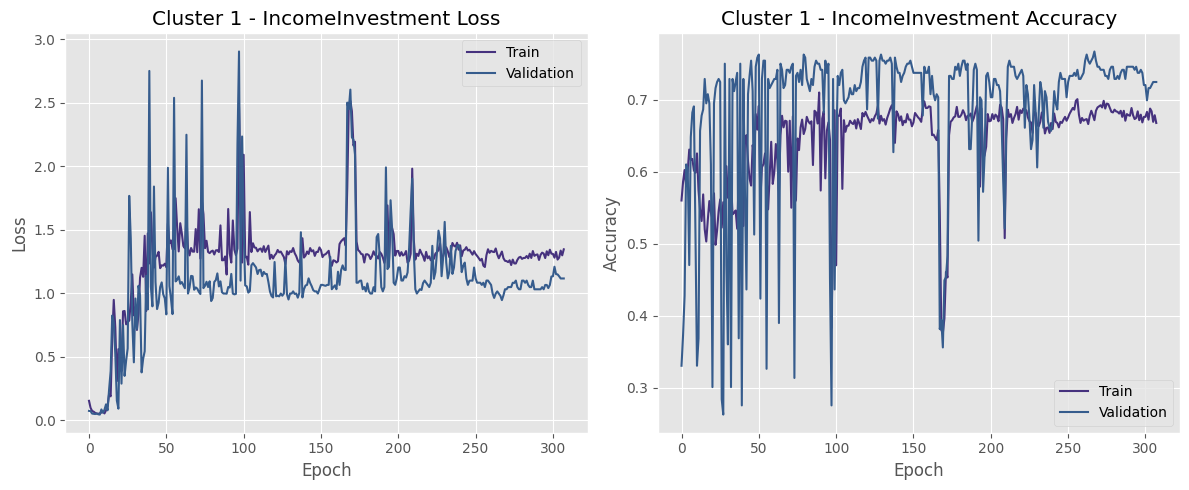


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 1
Generating advanced features... Done in 0.00s. New shape: (1180, 38)
One-hot encoding features... Done in 0.00s. Shape: (1180, 38)
Splitting data into train/test sets... Done in 0.00s
Training set: 944 samples | Test set: 236 samples
Class distribution: {1.0: 477, 0.0: 467}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5786 - auc: 0.6027 - loss: 0.2127 - precision: 0.6014 - recall: 0.5805 - val_accuracy: 0.6102 - val_auc: 0.6384 - val_loss: 0.0506 - val_precision: 0.6098 - val_recall: 0.6303
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6492 - auc: 0.6770 - loss: 0.1168 - precision: 0.6893 - recall: 0.5417 - val_accuracy: 0.6610 - val_auc: 0.7127 - val_loss: 0.0479 - val_precision: 0.6309 - val_recall: 0.7899
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6163 - auc: 0.6689 - loss: 0.0933 - precision: 0.6045 - recall: 0.6509 - val_accuracy: 0.6229 - val_auc: 0.6445 - val_loss: 0.0562 - val_precision: 0.6271 - val_recall: 0.6218
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6238 - auc: 0.6706 - loss: 0.0940 - precision: 0.6531 - recall: 0.6262 - val_accuracy: 0.7076 - val_auc: 0.7647 - val_loss: 0.0428 - val_precision: 0.6894 - val_recall: 0.7647
Epoch 5/1000
15/15 ━━━━━━━━

2025-04-04 22:48:36.008624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


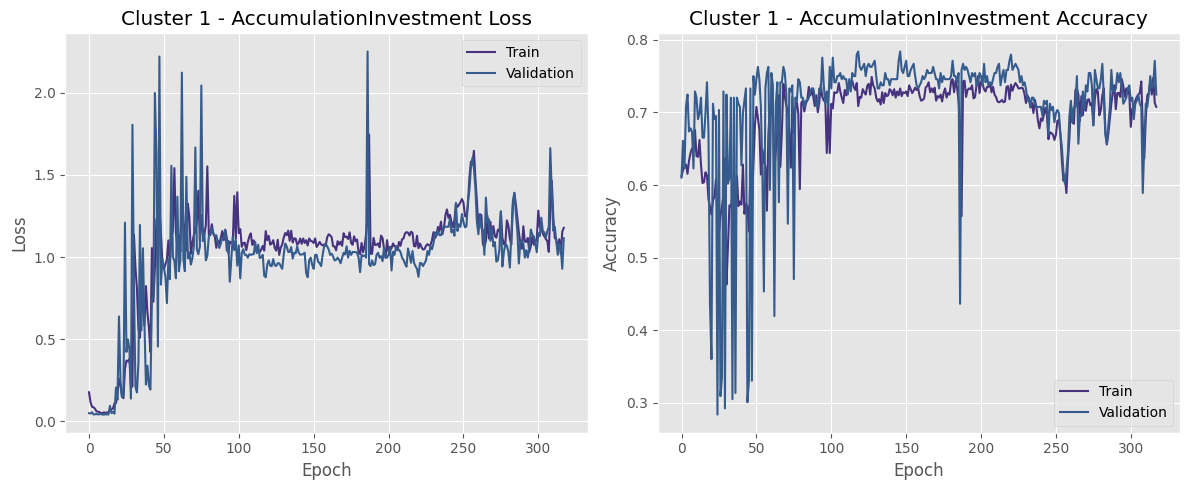


 PROCESSING CLUSTER 2 (3/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 2
Generating advanced features... Done in 0.00s. New shape: (414, 37)
One-hot encoding features... Done in 0.00s. Shape: (414, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 331 samples | Test set: 83 samples
Class distribution: {1.0: 261, 0.0: 70}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 471 samples
New class distribution: {1.0: 261, 0.0: 210}
Scaling features... Done in 0.00s
Using batch size of 32 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 32 to 27 for dataset with 83 samples
Using medium model architecture for medium cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6791 - auc: 0.7458 - loss: 0.1714 - precision: 0.7354 - recall: 0.6436 - val_accuracy: 0.7470 - val_auc: 0.7843 - val_loss: 0.0863 - val_precision: 0.8571 - val_recall: 0.8182
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7757 - auc: 0.8604 - loss: 0.1134 - precision: 0.7889 - recall: 0.8008 - val_accuracy: 0.7470 - val_auc: 0.8373 - val_loss: 0.0895 - val_precision: 0.9412 - val_recall: 0.7273
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7851 - auc: 0.8610 - loss: 0.0978 - precision: 0.8162 - recall: 0.7610 - val_accuracy: 0.7831 - val_auc: 0.8061 - val_loss: 0.0770 - val_precision: 0.8750 - val_recall: 0.8485
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7173 - auc: 0.8350 - loss: 0.0958 - precision: 0.7902 - recall: 0.7219 - val_accuracy: 0.7590 - val_auc: 0.8151 - val_loss: 0.0745 - val_precision: 0.8966 - val_recall: 0.7879
Epoch 5/1000
15/15 ━━━━━━━━

2025-04-04 22:50:51.913298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


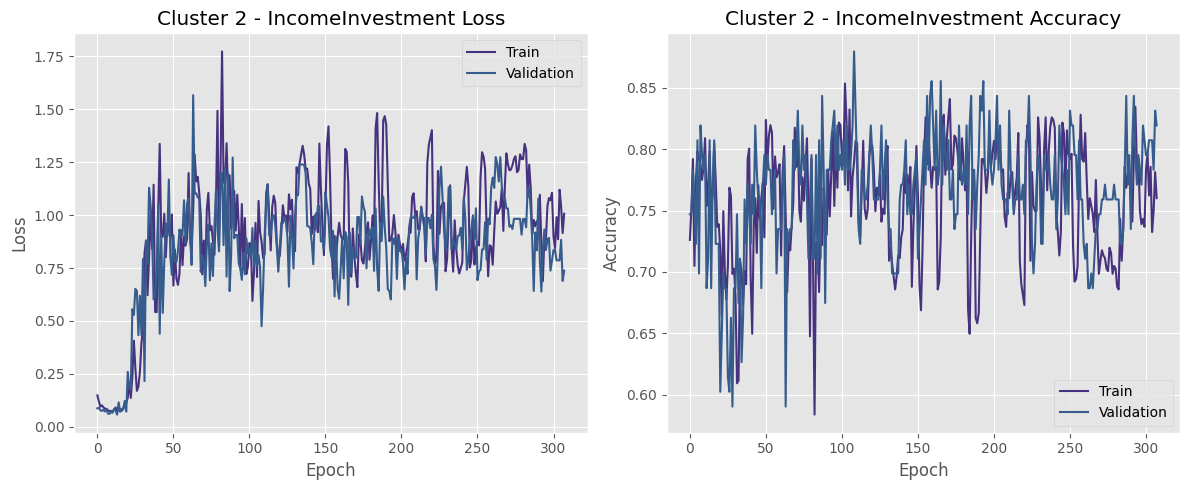


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 2
Generating advanced features... Done in 0.00s. New shape: (414, 37)
One-hot encoding features... Done in 0.00s. Shape: (414, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 331 samples | Test set: 83 samples
Class distribution: {1.0: 169, 0.0: 162}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 32 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 32 to 27 for dataset with 83 samples
Using medium model architecture for medium cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.6033 - auc: 0.6472 - loss: 0.1696 - precision: 0.6227 - recall: 0.6348 - val_accuracy: 0.6024 - val_auc: 0.6512 - val_loss: 0.1395 - val_precision: 0.5862 - val_recall: 0.7907
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7500 - auc: 0.8411 - loss: 0.1389 - precision: 0.8130 - recall: 0.6681 - val_accuracy: 0.6265 - val_auc: 0.7169 - val_loss: 0.1008 - val_precision: 0.6200 - val_recall: 0.7209
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6053 - auc: 0.7193 - loss: 0.1548 - precision: 0.5809 - recall: 0.7991 - val_accuracy: 0.6747 - val_auc: 0.7369 - val_loss: 0.0976 - val_precision: 0.6667 - val_recall: 0.7442
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7322 - auc: 0.7993 - loss: 0.1155 - precision: 0.8098 - recall: 0.6347 - val_accuracy: 0.6024 - val_auc: 0.6410 - val_loss: 0.0945 - val_precision: 0.6250 - val_recall: 0.5814
Epoch 5/1000
11/11 ━━━━━━━━

2025-04-04 22:52:43.125803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


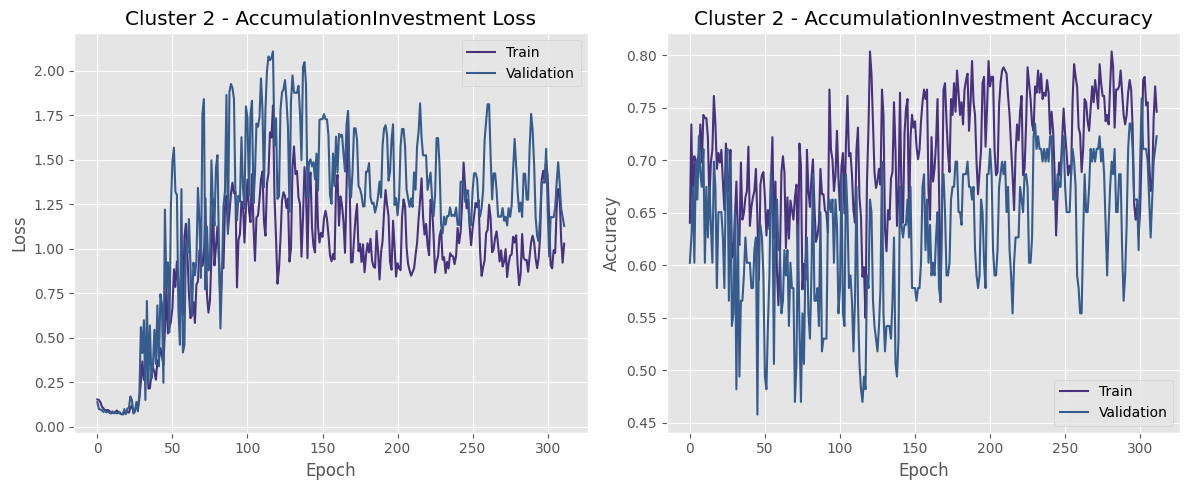


 PROCESSING CLUSTER 3 (4/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 3
Generating advanced features... Done in 0.00s. New shape: (1151, 37)
One-hot encoding features... Done in 0.00s. Shape: (1151, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 920 samples | Test set: 231 samples
Class distribution: {0.0: 597, 1.0: 323}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 1194 samples
New class distribution: {0.0: 597, 1.0: 597}
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5811 - auc: 0.6125 - loss: 0.1579 - precision: 0.5743 - recall: 0.5635 - val_accuracy: 0.6840 - val_auc: 0.6816 - val_loss: 0.0478 - val_precision: 0.5455 - val_recall: 0.5926
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6302 - auc: 0.6737 - loss: 0.0929 - precision: 0.6360 - recall: 0.5440 - val_accuracy: 0.4632 - val_auc: 0.6693 - val_loss: 0.0565 - val_precision: 0.3825 - val_recall: 0.8642
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6018 - auc: 0.6491 - loss: 0.0729 - precision: 0.5851 - recall: 0.6640 - val_accuracy: 0.5887 - val_auc: 0.6414 - val_loss: 0.0473 - val_precision: 0.4314 - val_recall: 0.5432
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6391 - auc: 0.6858 - loss: 0.0638 - precision: 0.6138 - recall: 0.6456 - val_accuracy: 0.6320 - val_auc: 0.6725 - val_loss: 0.0456 - val_precision: 0.4811 - val_recall: 0.6296
Epoch 5/1000
19/19 ━━━━━━━━━

2025-04-04 22:58:17.783982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


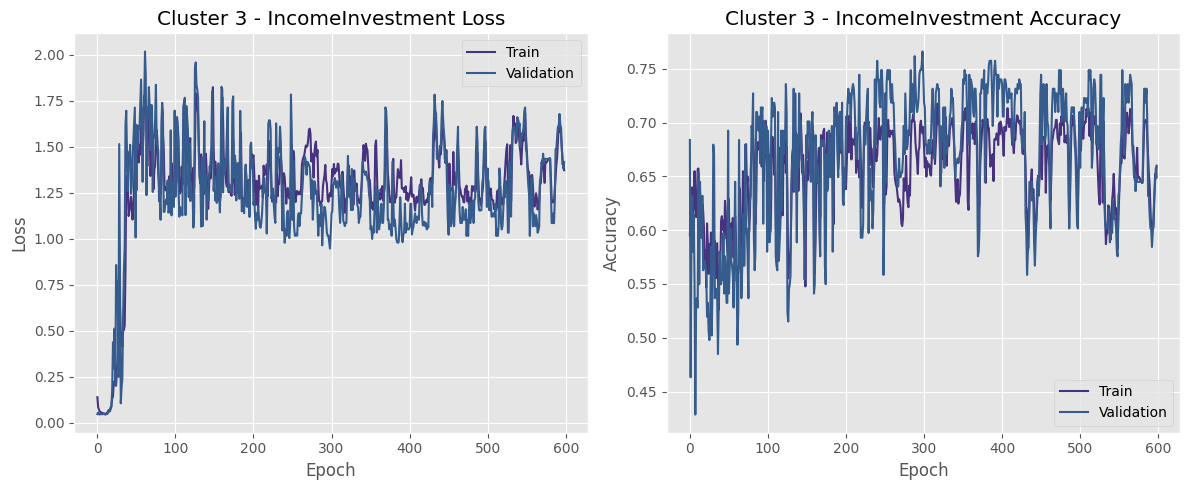


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 3
Generating advanced features... Done in 0.00s. New shape: (1151, 37)
One-hot encoding features... Done in 0.00s. Shape: (1151, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 920 samples | Test set: 231 samples
Class distribution: {0.0: 484, 1.0: 436}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5828 - auc: 0.6197 - loss: 0.1727 - precision: 0.5572 - recall: 0.6099 - val_accuracy: 0.6710 - val_auc: 0.7075 - val_loss: 0.0471 - val_precision: 0.6977 - val_recall: 0.5455
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6055 - auc: 0.6395 - loss: 0.1124 - precision: 0.5778 - recall: 0.6503 - val_accuracy: 0.6364 - val_auc: 0.6485 - val_loss: 0.0504 - val_precision: 0.6327 - val_recall: 0.5636
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6369 - auc: 0.6700 - loss: 0.0832 - precision: 0.6206 - recall: 0.5545 - val_accuracy: 0.6234 - val_auc: 0.6620 - val_loss: 0.0561 - val_precision: 0.5650 - val_recall: 0.9091
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5979 - auc: 0.6168 - loss: 0.0869 - precision: 0.5678 - recall: 0.6459 - val_accuracy: 0.6926 - val_auc: 0.7192 - val_loss: 0.0447 - val_precision: 0.6612 - val_recall: 0.7273
Epoch 5/1000
15/15 ━━━━━━━━

2025-04-04 23:00:48.407236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


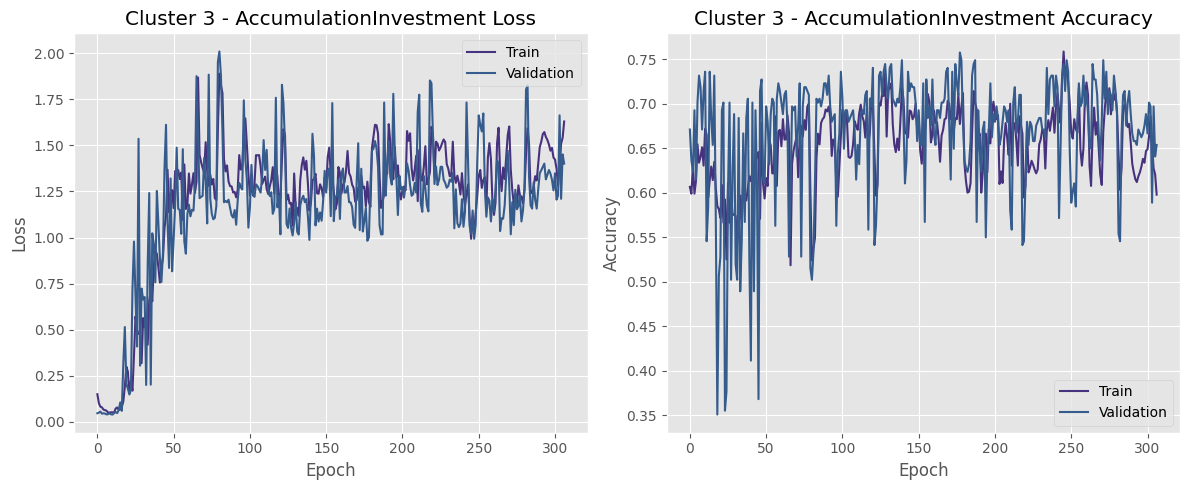


 PROCESSING CLUSTER 4 (5/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 4
Generating advanced features... Done in 0.00s. New shape: (700, 37)
One-hot encoding features... Done in 0.00s. Shape: (700, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 560 samples | Test set: 140 samples
Class distribution: {0.0: 437, 1.0: 123}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 806 samples
New class distribution: {0.0: 437, 1.0: 369}
Scaling features... Done in 0.00s
Using batch size of 64 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 64 to 46 for dataset with 140 samples
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.4969 - auc: 0.5095 - loss: 0.1782 - precision: 0.4274 - recall: 0.4572 - val_accuracy: 0.4286 - val_auc: 0.6148 - val_loss: 0.0603 - val_precision: 0.2474 - val_recall: 0.7742
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5865 - auc: 0.5994 - loss: 0.0992 - precision: 0.5434 - recall: 0.5071 - val_accuracy: 0.5929 - val_auc: 0.4161 - val_loss: 0.0494 - val_precision: 0.1579 - val_recall: 0.1935
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5379 - auc: 0.5600 - loss: 0.0846 - precision: 0.5094 - recall: 0.5827 - val_accuracy: 0.5929 - val_auc: 0.5000 - val_loss: 0.0477 - val_precision: 0.2292 - val_recall: 0.3548
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5240 - auc: 0.5370 - loss: 0.0823 - precision: 0.4701 - recall: 0.5667 - val_accuracy: 0.4857 - val_auc: 0.5633 - val_loss: 0.0519 - val_precision: 0.2405 - val_recall: 0.6129
Epoch 5/1000
13/13 ━━━━━━━━

2025-04-04 23:03:13.907880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


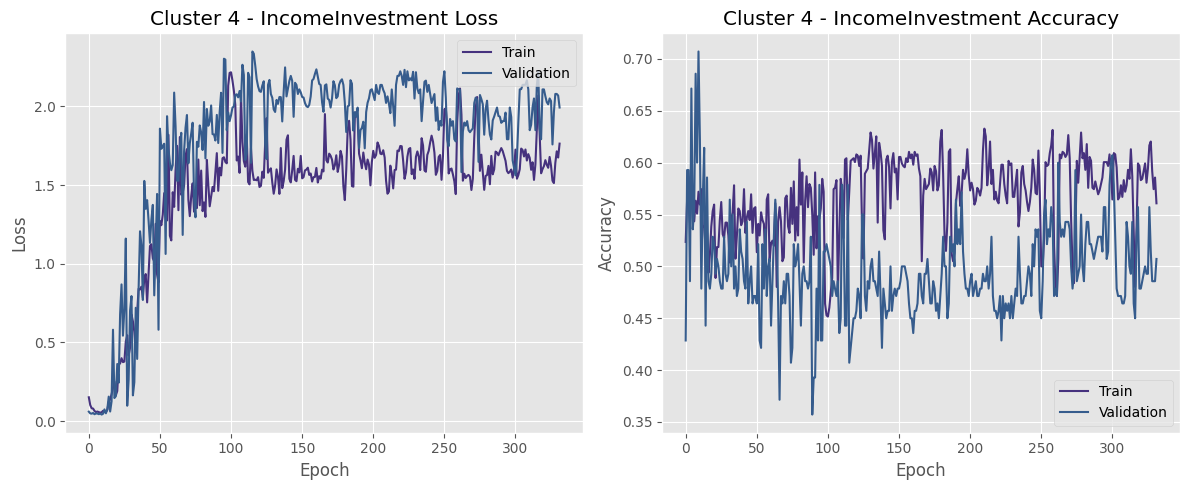


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 4
Generating advanced features... Done in 0.00s. New shape: (700, 37)
One-hot encoding features... Done in 0.00s. Shape: (700, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 560 samples | Test set: 140 samples
Class distribution: {1.0: 290, 0.0: 270}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 56 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 56 to 46 for dataset with 140 samples
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.5682 - auc: 0.5927 - loss: 0.1927 - precision: 0.5744 - recall: 0.5845 - val_accuracy: 0.6643 - val_auc: 0.7441 - val_loss: 0.0583 - val_precision: 0.7500 - val_recall: 0.5342
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6805 - auc: 0.7185 - loss: 0.1188 - precision: 0.7033 - recall: 0.6711 - val_accuracy: 0.6214 - val_auc: 0.6865 - val_loss: 0.0507 - val_precision: 0.6562 - val_recall: 0.5753
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6429 - auc: 0.6760 - loss: 0.1119 - precision: 0.6580 - recall: 0.6398 - val_accuracy: 0.6500 - val_auc: 0.7623 - val_loss: 0.0449 - val_precision: 0.7400 - val_recall: 0.5068
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6745 - auc: 0.7474 - loss: 0.0863 - precision: 0.7162 - recall: 0.6971 - val_accuracy: 0.6786 - val_auc: 0.7845 - val_loss: 0.0441 - val_precision: 0.7800 - val_recall: 0.5342
Epoch 5/1000
10/10 ━━━━━━━━

2025-04-04 23:05:04.365715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


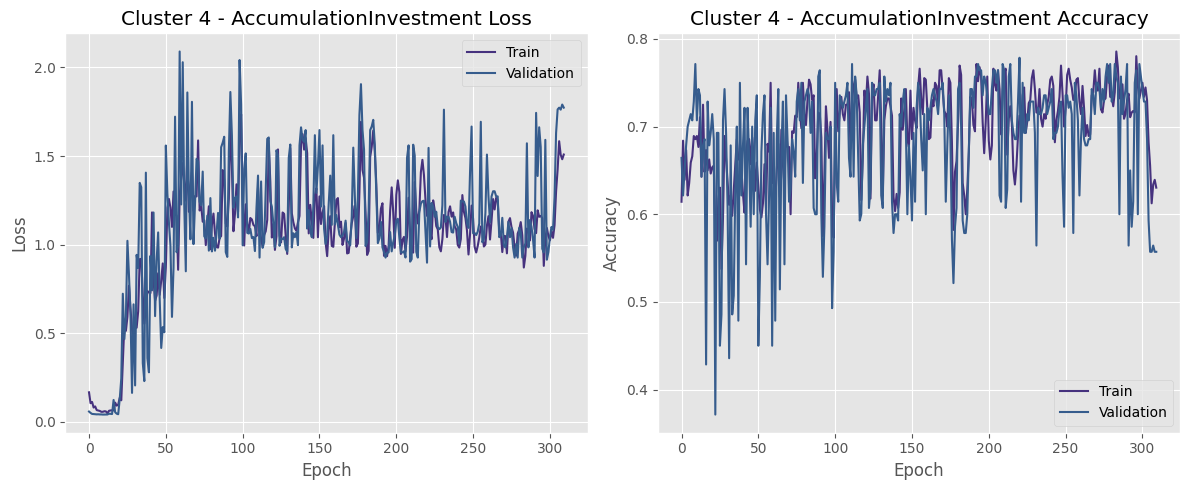


 PROCESSING CLUSTER 5 (6/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 5
Generating advanced features... Done in 0.00s. New shape: (542, 37)
One-hot encoding features... Done in 0.00s. Shape: (542, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 433 samples | Test set: 109 samples
Class distribution: {1.0: 318, 0.0: 115}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 636 samples
New class distribution: {1.0: 318, 0.0: 318}
Scaling features... Done in 0.00s
Using batch size of 63 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 63 to 36 for dataset with 109 samples
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.6696 - auc: 0.7417 - loss: 0.1290 - precision: 0.7089 - recall: 0.6725 - val_accuracy: 0.7706 - val_auc: 0.8746 - val_loss: 0.0399 - val_precision: 0.9104 - val_recall: 0.7625
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7728 - auc: 0.8556 - loss: 0.0874 - precision: 0.8126 - recall: 0.6872 - val_accuracy: 0.6514 - val_auc: 0.8142 - val_loss: 0.0502 - val_precision: 0.9375 - val_recall: 0.5625
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7568 - auc: 0.8566 - loss: 0.0623 - precision: 0.7571 - recall: 0.7681 - val_accuracy: 0.7890 - val_auc: 0.8532 - val_loss: 0.0340 - val_precision: 0.8800 - val_recall: 0.8250
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7904 - auc: 0.8776 - loss: 0.0485 - precision: 0.7898 - recall: 0.8286 - val_accuracy: 0.6697 - val_auc: 0.8065 - val_loss: 0.0468 - val_precision: 0.9074 - val_recall: 0.6125
Epoch 5/1000
11/11 ━━━━━━━━

2025-04-04 23:06:59.742238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


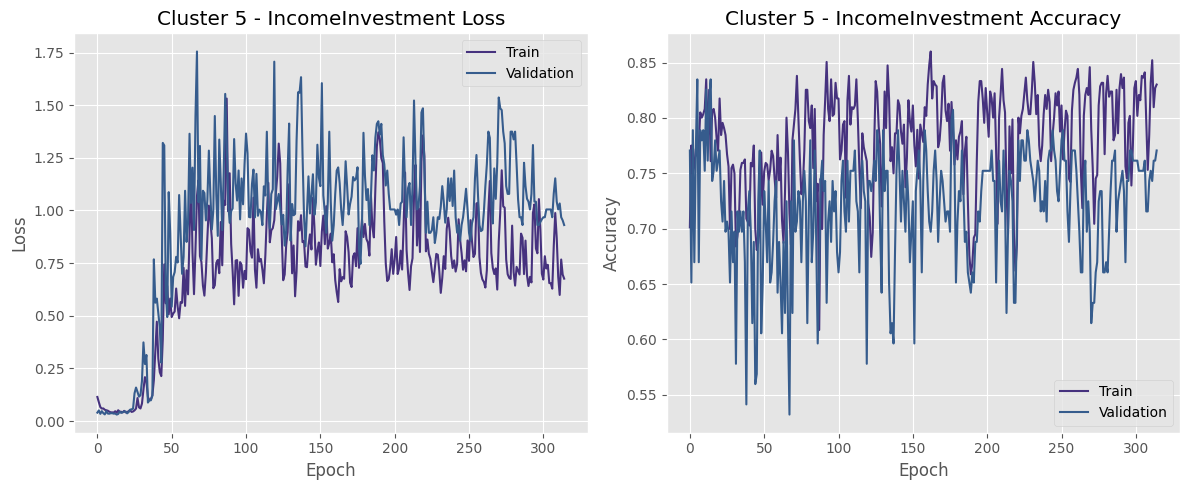


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 5
Generating advanced features... Done in 0.00s. New shape: (542, 37)
One-hot encoding features... Done in 0.00s. Shape: (542, 37)
Splitting data into train/test sets... Done in 0.00s
Training set: 433 samples | Test set: 109 samples
Class distribution: {1.0: 222, 0.0: 211}
Handling class imbalance...
Class distribution is already reasonably balanced. Skipping balancing.
Scaling features... Done in 0.00s
Using batch size of 32 for this dataset
Creating TensorFlow datasets...
Using medium model architecture for large cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5588 - auc: 0.5806 - loss: 0.1585 - precision: 0.5695 - recall: 0.5250 - val_accuracy: 0.6697 - val_auc: 0.7271 - val_loss: 0.0497 - val_precision: 0.6667 - val_recall: 0.7143
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6792 - auc: 0.7237 - loss: 0.1044 - precision: 0.6838 - recall: 0.7377 - val_accuracy: 0.6514 - val_auc: 0.6973 - val_loss: 0.0471 - val_precision: 0.7143 - val_recall: 0.5357
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5893 - auc: 0.6351 - loss: 0.1101 - precision: 0.6236 - recall: 0.5082 - val_accuracy: 0.6055 - val_auc: 0.6838 - val_loss: 0.0475 - val_precision: 0.5747 - val_recall: 0.8929
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6038 - auc: 0.6281 - loss: 0.0766 - precision: 0.6248 - recall: 0.6037 - val_accuracy: 0.6514 - val_auc: 0.7155 - val_loss: 0.0455 - val_precision: 0.6250 - val_recall: 0.8036
Epoch 5/1000
14/14 ━━━━━━━━

2025-04-04 23:09:21.899883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


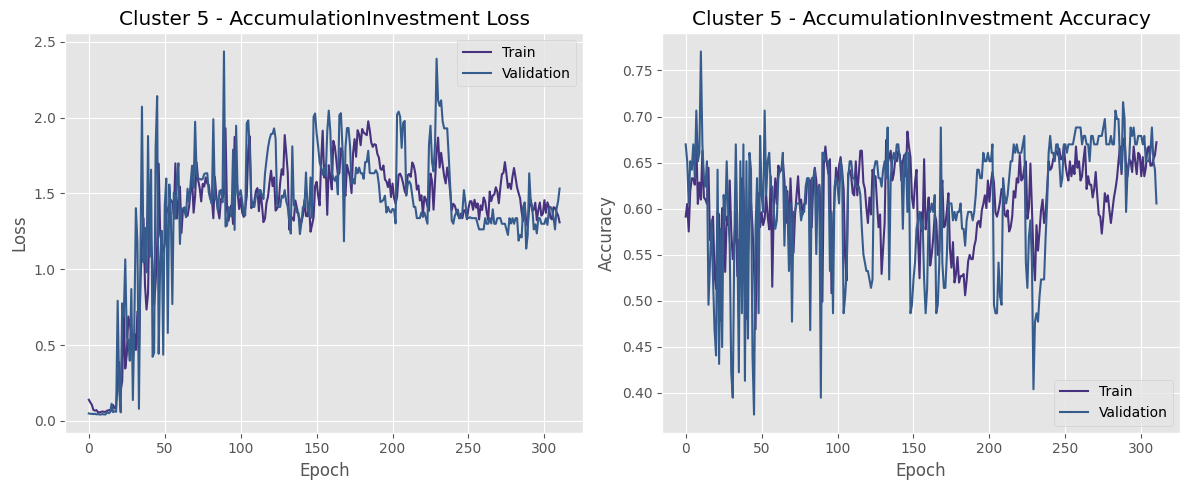


 PROCESSING CLUSTER 6 (7/7 clusters)

 TRAINING MODEL FOR IncomeInvestment IN CLUSTER 6
One-hot encoding features... Done in 0.00s. Shape: (93, 19)
Splitting data into train/test sets... Done in 0.00s
Training set: 74 samples | Test set: 19 samples
Class distribution: {0.0: 63, 1.0: 11}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 96 samples
New class distribution: {0.0: 63, 1.0: 33}
Scaling features... Done in 0.00s
Using batch size of 16 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 16 to 6 for dataset with 19 samples
Using small model architecture for small cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5381 - auc: 0.5496 - loss: 0.1603 - precision: 0.3456 - recall: 0.4110 - val_accuracy: 0.5263 - val_auc: 0.5104 - val_loss: 0.0843 - val_precision: 0.2000 - val_recall: 0.6667
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5548 - auc: 0.6384 - loss: 0.1412 - precision: 0.3598 - recall: 0.5720 - val_accuracy: 0.6316 - val_auc: 0.5521 - val_loss: 0.0803 - val_precision: 0.2500 - val_recall: 0.6667
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7040 - auc: 0.7763 - loss: 0.0907 - precision: 0.5487 - recall: 0.7572 - val_accuracy: 0.5789 - val_auc: 0.6458 - val_loss: 0.0776 - val_precision: 0.2222 - val_recall: 0.6667
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7015 - auc: 0.8142 - loss: 0.0907 - precision: 0.5346 - recall: 0.8586 - val_accuracy: 0.6842 - val_auc: 0.6458 - val_loss: 0.0737 - val_precision: 0.2857 - val_recall: 0.6667
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━

2025-04-04 23:12:00.560183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


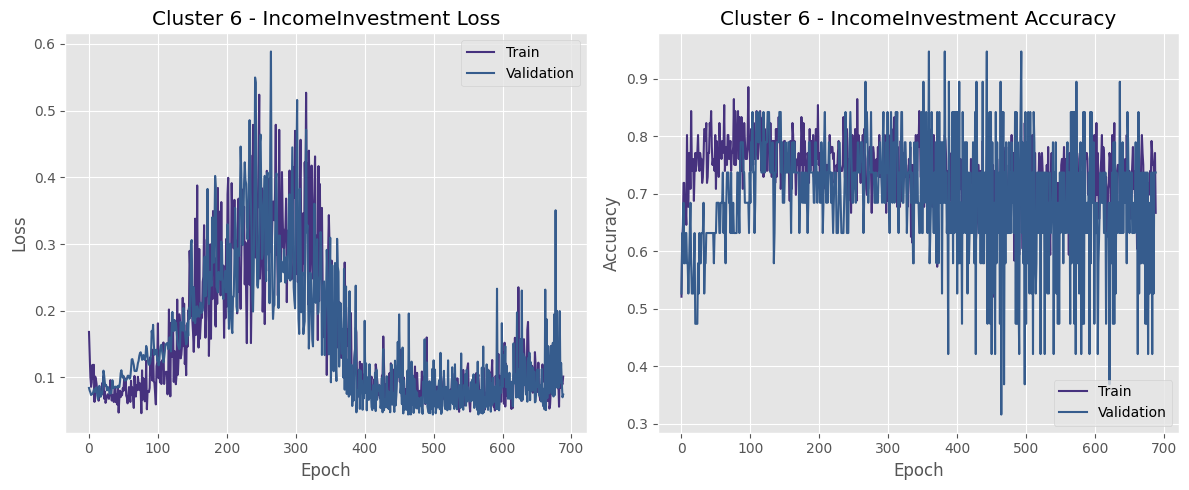


 TRAINING MODEL FOR AccumulationInvestment IN CLUSTER 6
One-hot encoding features... Done in 0.00s. Shape: (93, 19)
Splitting data into train/test sets... Done in 0.00s
Training set: 74 samples | Test set: 19 samples
Class distribution: {0.0: 45, 1.0: 29}
Handling class imbalance...
Balanced dataset in 0.00s. New training set: 90 samples
New class distribution: {0.0: 45, 1.0: 45}
Scaling features... Done in 0.00s
Using batch size of 16 for this dataset
Creating TensorFlow datasets...
⚠️ Reduced batch size from 16 to 6 for dataset with 19 samples
Using small model architecture for small cluster...
Training model for up to 1000 epochs with 300 patience...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4005 - auc: 0.4409 - loss: 0.2162 - precision: 0.4159 - recall: 0.3813 - val_accuracy: 0.5789 - val_auc: 0.6875 - val_loss: 0.0883 - val_precision: 0.5000 - val_recall: 0.7500
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6371 - auc: 0.6427 - loss: 0.1713 - precision: 0.6722 - recall: 0.6224 - val_accuracy: 0.6842 - val_auc: 0.7500 - val_loss: 0.0771 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6078 - auc: 0.6785 - loss: 0.1441 - precision: 0.5970 - recall: 0.6416 - val_accuracy: 0.7368 - val_auc: 0.7273 - val_loss: 0.0742 - val_precision: 0.7143 - val_recall: 0.6250
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6776 - auc: 0.7173 - loss: 0.1321 - precision: 0.6353 - recall: 0.6793 - val_accuracy: 0.6316 - val_auc: 0.7443 - val_loss: 0.0784 - val_precision: 0.5455 - val_recall: 0.7500
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━

2025-04-04 23:14:22.868068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


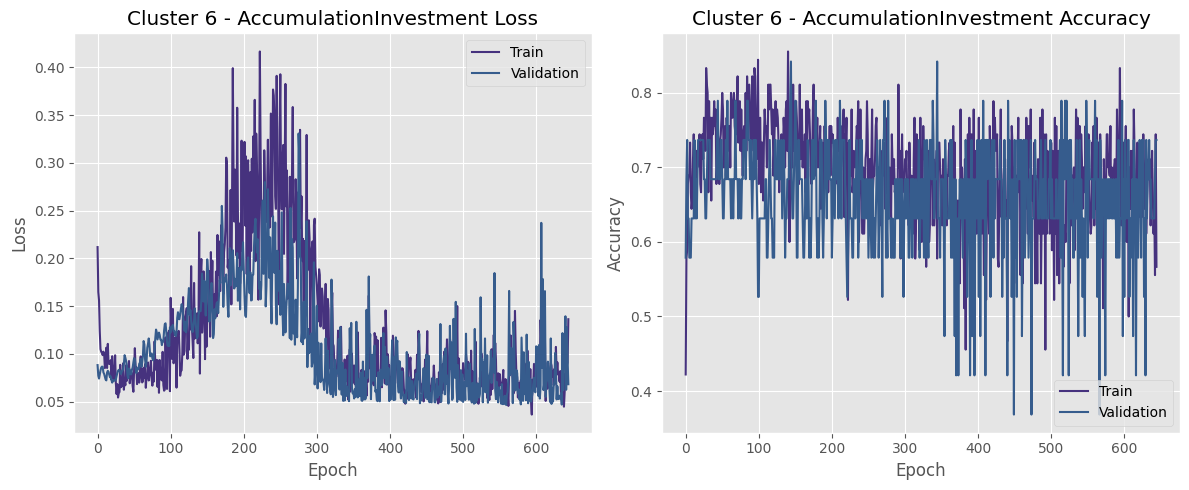

Number of Income models: 7
Number of Accumulation models: 7

 MODEL COMPARISON


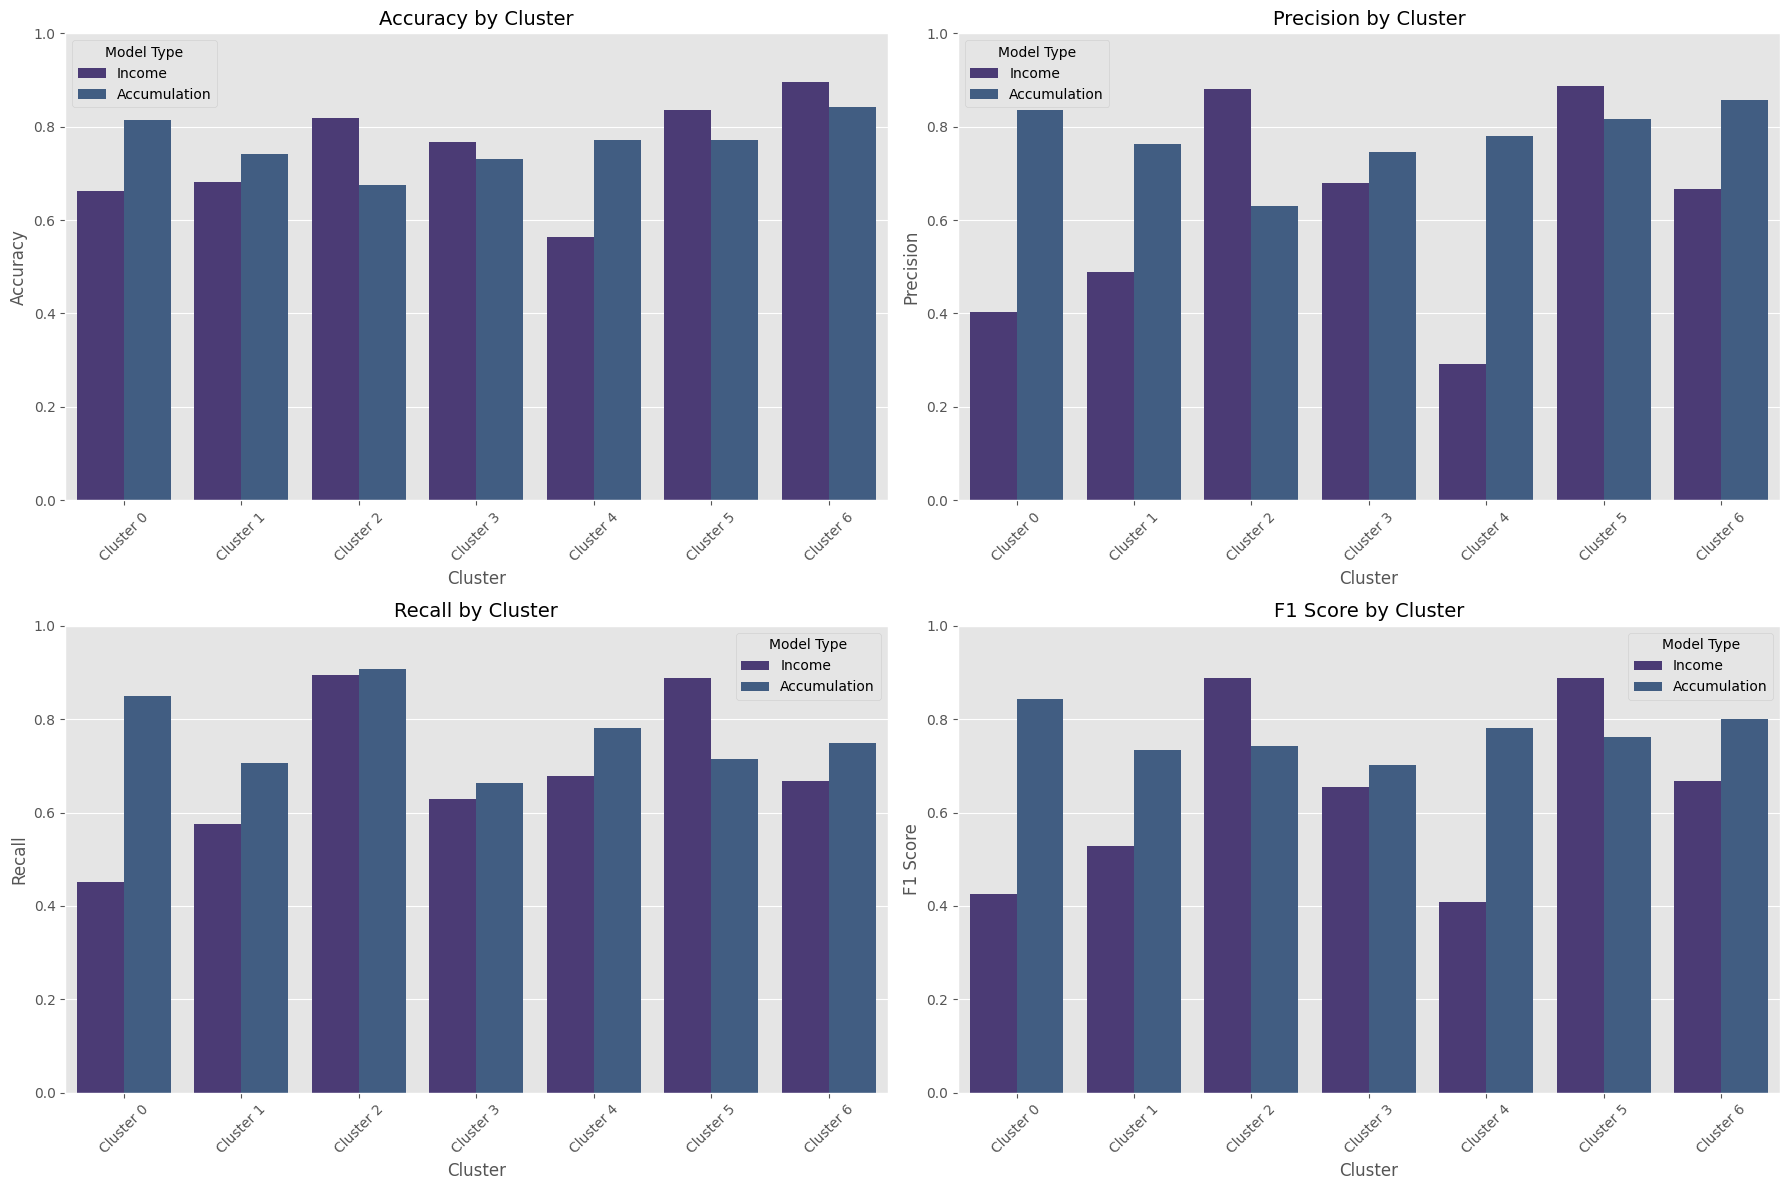


===== FINAL REPORT =====
Successfully trained 14 models across 14 clusters

Average metrics across all models:
Accuracy: 0.7551
Precision: 0.6946
Recall: 0.7253
F1 Score: 0.7015
Auc: 0.7770
Pr Auc: 0.7259

===== Neural Network Models Complete =====
✅ Cluster-specific neural networks have been trained
✅ Model checkpoints saved to 'models/' directory
✅ Performance logs saved to nn_optimization_20250404_223815.log


In [19]:
# PART 4: ROBUST NEURAL NETWORKS FOR APPLE M4 MAX GPU

print("\n===== Building Robust Neural Network Models for M4 Max GPU =====")

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import class_weight, resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import time
from tqdm.auto import tqdm, trange
import sys
import psutil
import gc
import logging
import datetime
import json
import platform
import math
from contextlib import contextmanager
from functools import partial

# ===== OPTIMIZATION LOGGING SETUP =====
# Create optimization log file
log_filename = f"nn_optimization_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('NNOptimization')

# Add system info logging
def log_system_info():
    """Log detailed system information for optimization reference"""
    system_info = {
        "platform": platform.platform(),
        "processor": platform.processor(),
        "python_version": platform.python_version(),
        "tensorflow_version": tf.__version__,
        "numpy_version": np.__version__,
        "pandas_version": pd.__version__,
        "physical_devices": str(tf.config.list_physical_devices()),
        "memory_total": psutil.virtual_memory().total / (1024**3),  # GB
        "cpu_count": psutil.cpu_count(logical=False),
        "cpu_threads": psutil.cpu_count(logical=True)
    }
    
    # Try to get GPU info if available
    try:
        import subprocess
        result = subprocess.run(['system_profiler', 'SPDisplaysDataType'], 
                               capture_output=True, text=True)
        gpu_info = result.stdout
        system_info["gpu_info"] = gpu_info
    except:
        system_info["gpu_info"] = "Could not retrieve GPU info"
    
    logger.info(f"SYSTEM INFO: {json.dumps(system_info)}")
    print("System info logged for optimization reference")

# Time profiling context manager
@contextmanager
def timer_log(name):
    """Context manager to time operations and log them"""
    start_time = time.time()
    memory_before = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
    
    try:
        yield
    finally:
        end_time = time.time()
        duration = end_time - start_time
        memory_after = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        memory_diff = memory_after - memory_before
        
        logger.info(f"OPERATION: {name} - Duration: {duration:.2f}s - Memory: {memory_diff:.2f}MB")

# ===== GPU CONFIGURATION =====
os.environ['TF_ENABLE_MPS_UPLOAD_TENSORS'] = '1'
os.environ['TF_MPS_ENABLE_ASYNC_PROGRAMMING'] = '1'
os.environ['TF_MPS_ALLOW_GROWTH'] = 'true'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_MPS_MEMORY_ALLOCATION_RATIO'] = '0.95' 
os.environ['TF_MPS_MAX_COPY_STREAMING_INFLIGHT_RATIO'] = '0.9'

# Log system info at startup
log_system_info()

# Enable Metal Performance Shaders (MPS) for Apple Silicon
print("Checking GPU availability...")
physical_devices = tf.config.list_physical_devices()
print(f"Available devices: {physical_devices}")

# Enable mixed precision for faster training
print("Enabling mixed precision training...")
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create directory for saving models
if not os.path.exists('models'):
    os.makedirs('models')

# Simple GPU warm-up function
def warm_up_gpu():
    """Simple GPU warm-up that won't cause errors"""
    print("Warming up GPU...")
    with timer_log("gpu_warmup"):
        try:
            # Try to use GPU but fall back to CPU if needed
            try:
                device = '/device:GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/device:CPU:0'
                with tf.device(device):
                    # Simple matrix multiplication
                    a = tf.random.normal((1000, 1000), dtype=tf.float32)
                    b = tf.random.normal((1000, 1000), dtype=tf.float32)
                    c = tf.matmul(a, b)
                    _ = c.numpy()
            except:
                # Fall back to CPU
                a = tf.random.normal((1000, 1000), dtype=tf.float32)
                b = tf.random.normal((1000, 1000), dtype=tf.float32)
                c = tf.matmul(a, b)
                _ = c.numpy()
        except Exception as e:
            print(f"Warning: GPU warm-up failed: {e}")
    
    print("GPU warm-up complete")
    # Force garbage collection
    gc.collect()
    tf.keras.backend.clear_session()

# Run GPU warm-up
warm_up_gpu()

# Simple GPU monitoring callback
class GPUMonitorCallback(tf.keras.callbacks.Callback):
    """Simple GPU monitoring callback"""
    def __init__(self):
        super().__init__()
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        
        # Log metrics
        if logs:
            metrics_log = {k: float(v) for k, v in logs.items()}
            metrics_log["epoch"] = epoch
            metrics_log["duration"] = epoch_time
            logger.info(f"EPOCH_METRICS: {json.dumps(metrics_log)}")
        
        # Perform garbage collection every 10 epochs
        if epoch % 10 == 0:
            gc.collect()

# Custom progress bar callback
class ProgressBarCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, metrics=['loss', 'accuracy', 'val_loss', 'val_accuracy']):
        self.epochs = epochs
        self.metrics = metrics
        self.start_time = None
        self.pbar = None
        
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.pbar = tqdm(total=self.epochs, desc='Training', position=0)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate time per epoch and ETA
        elapsed = time.time() - self.start_time
        time_per_epoch = elapsed / (epoch + 1)
        eta = time_per_epoch * (self.epochs - epoch - 1)
        
        # Create status message
        status = f"Epoch {epoch+1}/{self.epochs}"
        for metric in self.metrics:
            if metric in logs:
                status += f" - {metric}: {logs[metric]:.4f}"
        
        status += f" - {time_per_epoch:.2f}s/epoch - ETA: {eta:.0f}s"
        
        # Update progress bar
        self.pbar.set_description(status)
        self.pbar.update(1)
        
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        self.pbar.set_description(f"Training completed in {total_time:.2f}s")
        self.pbar.close()

# COMPLETELY REVISED DATASET CREATION FUNCTION
def create_robust_dataset(X, y, batch_size=32, is_training=True, name="dataset"):
    """Create a robust TensorFlow dataset that works reliably with small datasets"""
    with timer_log(f"dataset_creation_{name}"):
        # Get dataset size
        n_samples = len(X)
        
        # Calculate a safe batch size (never more than 1/3 of dataset)
        safe_batch_size = min(batch_size, max(1, n_samples // 3))
        if safe_batch_size < batch_size:
            print(f"⚠️ Reduced batch size from {batch_size} to {safe_batch_size} for dataset with {n_samples} samples")
            
        # Convert to tensors with explicit dtypes
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
        y_tensor = tf.reshape(y_tensor, (-1, 1))  # Ensure consistent shape
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
        
        # Apply simple operations that work well with small datasets
        if is_training and n_samples > 10:
            # Only shuffle if enough data, with appropriate buffer size
            buffer_size = min(n_samples, 1000)
            dataset = dataset.shuffle(buffer_size=buffer_size, seed=42)
        
        # Batch with drop_remainder=False to handle uneven batches
        dataset = dataset.batch(safe_batch_size, drop_remainder=False)
        
        # Simple prefetch with constant value (AUTOTUNE can cause issues)
        dataset = dataset.prefetch(1)
        
        logger.info(f"DATASET_CREATED: {name} - Size: {n_samples} samples - Batch size: {safe_batch_size}")
        return dataset

# Simple batch size finder
def find_safe_batch_size(X, y):
    """Find a safe batch size for this dataset size"""
    n_samples = len(X)
    
    # For tiny datasets, use very small batches
    if n_samples < 100:
        safe_size = max(1, min(16, n_samples // 2))
        logger.info(f"Tiny dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For small datasets
    if n_samples < 500:
        safe_size = max(16, min(32, n_samples // 4))
        logger.info(f"Small dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For medium datasets
    if n_samples < 2000:
        safe_size = max(32, min(64, n_samples // 10))
        logger.info(f"Medium dataset ({n_samples} samples), using batch size: {safe_size}")
        return safe_size
    
    # For large datasets
    safe_size = max(64, min(128, n_samples // 20))
    logger.info(f"Large dataset ({n_samples} samples), using batch size: {safe_size}")
    return safe_size

# Custom focal loss for imbalanced data
def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss with gamma focus parameter"""
    def focal_loss_fixed(y_true, y_pred):
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        focal_weight = tf.pow(1-pt, gamma)
        return -alpha * focal_weight * tf.math.log(tf.clip_by_value(pt, 1e-7, 1))
    return focal_loss_fixed

# Create a small model for smaller clusters
def create_small_model(input_dim, learning_rate=0.001, l2_reg=0.001, dropout_rate=0.4):
    """Simple robust model for small clusters"""
    with timer_log(f"small_model_creation_dim{input_dim}"):
        # Start with CPU for reliability
        with tf.device('/device:CPU:0'):
            inputs = tf.keras.Input(shape=(input_dim,))
            
            # Feature extraction
            x = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            
            # Simple residual connection
            residual = x
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.add([x, residual])
            
            # Output layer
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate/2)(x)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0  # Add gradient clipping for stability
            )
            
            # Compile with focal loss for imbalanced data
            model.compile(
                optimizer=optimizer,
                loss=focal_loss(gamma=2.0, alpha=0.25),
                metrics=[
                    'accuracy', 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()
                ]
            )
        
        logger.info(f"SMALL_MODEL_CREATED: input_dim={input_dim}, params={model.count_params()}")
        return model

# Create a medium model for medium-sized clusters
def create_medium_model(input_dim, learning_rate=0.001, l2_reg=0.001, dropout_rate=0.3):
    """Medium-sized model for balanced performance"""
    with timer_log(f"medium_model_creation_dim{input_dim}"):
        # Start with CPU for reliability
        with tf.device('/device:CPU:0'):
            inputs = tf.keras.Input(shape=(input_dim,))
            
            # Feature extraction
            x = tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            
            # Residual block
            residual = x
            x = tf.keras.layers.Dense(256, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            x = tf.keras.layers.Dense(256)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.add([x, residual])
            
            # Additional layers
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.Dropout(dropout_rate/2)(x)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
            
            # Compile with focal loss for imbalanced data
            model.compile(
                optimizer=optimizer,
                loss=focal_loss(gamma=2.0, alpha=0.25),
                metrics=[
                    'accuracy', 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(), 
                    tf.keras.metrics.Recall()
                ]
            )
        
        logger.info(f"MEDIUM_MODEL_CREATED: input_dim={input_dim}, params={model.count_params()}")
        return model

# Enhanced feature generation
def generate_advanced_features(X):
    """Generate advanced features safely"""
    with timer_log("feature_generation"):
        # Make a copy to avoid modifying the original
        X_new = X.copy()
        
        # Get numeric columns safely
        numeric_cols = X.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
        
        # If no numeric columns or too many, return the original
        if not numeric_cols or len(numeric_cols) > 100:
            return X
        
        # Limit to top 5 numeric columns to avoid explosion
        if len(numeric_cols) > 5:
            numeric_cols = numeric_cols[:5]
            
        try:
            # Add squared terms for key numeric columns
            for col in numeric_cols:
                X_new[f"{col}_squared"] = X[col] ** 2
                
            # Add log transforms for positive columns
            for col in numeric_cols:
                if X[col].min() > 0:  # Only apply to positive columns
                    X_new[f"{col}_log"] = np.log1p(X[col])
            
            # Add simple interactions (only if not too many)
            if len(numeric_cols) <= 5:
                for i, col1 in enumerate(numeric_cols):
                    for col2 in numeric_cols[i+1:]:
                        X_new[f"{col1}_x_{col2}"] = X[col1] * X[col2]
        except Exception as e:
            print(f"Warning: Error in feature generation: {e}. Using original features.")
            return X
            
        logger.info(f"FEATURE_GENERATION: Original columns: {X.shape[1]}, New columns: {X_new.shape[1]}")
        return X_new

# Simple history plotting function
def plot_training_history(history, cluster_id, target_name):
    """Simple, reliable history plotting function"""
    try:
        plt.figure(figsize=(12, 5))
        
        # Ensure history has data
        if not history.history or len(history.history) == 0:
            print("Warning: No history data available to plot")
            return
            
        # Get available metrics
        metrics = list(history.history.keys())
        val_metrics = [m for m in metrics if m.startswith('val_')]
        train_metrics = [m for m in metrics if not m.startswith('val_')]
        
        # Plot loss if available
        if 'loss' in train_metrics and 'val_loss' in val_metrics:
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title(f'Cluster {cluster_id} - {target_name} Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right')
        
        # Plot accuracy or AUC if available
        metric_to_plot = None
        val_metric_to_plot = None
        
        if 'accuracy' in train_metrics and 'val_accuracy' in val_metrics:
            metric_to_plot = 'accuracy'
            val_metric_to_plot = 'val_accuracy'
            metric_name = 'Accuracy'
        elif 'auc' in train_metrics and 'val_auc' in val_metrics:
            metric_to_plot = 'auc'
            val_metric_to_plot = 'val_auc' 
            metric_name = 'AUC'
            
        if metric_to_plot and val_metric_to_plot:
            plt.subplot(1, 2, 2)
            plt.plot(history.history[metric_to_plot])
            plt.plot(history.history[val_metric_to_plot])
            plt.title(f'Cluster {cluster_id} - {target_name} {metric_name}')
            plt.ylabel(metric_name)
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.tight_layout()
        plt.savefig(f"cluster_{cluster_id}_{target_name}_history.png", dpi=300)
        plt.show()
    except Exception as e:
        print(f"Warning: Error plotting history: {e}")

# Create dictionaries to store data and models for each cluster
income_models = {}
accum_models = {}

# Add engineered features and target variables
df_for_nn = engineered_df.copy()
df_for_nn['cluster'] = labels

# Display cluster distribution
print("Cluster distribution:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples ({count/len(labels)*100:.1f}%)")

# Constants for cluster sizing
SMALL_CLUSTER_THRESHOLD = 200
MEDIUM_CLUSTER_THRESHOLD = 500

# Function to print section header
def print_section(title):
    print(f"\n{'=' * 80}")
    print(f" {title}")
    print(f"{'=' * 80}")

# Process each cluster
for cluster_id in np.unique(labels):
    try:
        print_section(f"PROCESSING CLUSTER {cluster_id} ({list(np.unique(labels)).index(cluster_id) + 1}/{len(np.unique(labels))} clusters)")
        
        # Filter data for this cluster
        cluster_df = df_for_nn[df_for_nn['cluster'] == cluster_id]
        
        # Skip very small clusters
        if len(cluster_df) < 30:
            print(f"⚠️ Cluster {cluster_id} has only {len(cluster_df)} samples. Skipping...")
            continue
        
        # For each target variable
        for target_name in ['IncomeInvestment', 'AccumulationInvestment']:
            print_section(f"TRAINING MODEL FOR {target_name} IN CLUSTER {cluster_id}")
            
            # Prepare features and target
            X = cluster_df.drop(['IncomeInvestment', 'AccumulationInvestment', 'cluster'], axis=1)
            y = cluster_df[target_name]
            
            # Apply enhanced feature engineering (if cluster is large enough)
            if len(X) > 100:
                print("Generating advanced features... ", end='')
                start_time = time.time()
                X = generate_advanced_features(X)
                print(f"Done in {time.time() - start_time:.2f}s. New shape: {X.shape}")
            
            # One-hot encode categorical features
            start_time = time.time()
            print(f"One-hot encoding features... ", end='')
            X = pd.get_dummies(X)
            print(f"Done in {time.time() - start_time:.2f}s. Shape: {X.shape}")
            
            # Train-test split with stratification
            print("Splitting data into train/test sets... ", end='')
            start_time = time.time()
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            print(f"Done in {time.time() - start_time:.2f}s")
            print(f"Training set: {X_train.shape[0]} samples | Test set: {X_test.shape[0]} samples")
            print(f"Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
            
            # Handle imbalanced data with simple resampling
            print("Handling class imbalance...")
            start_time = time.time()
            
            # Get minority and majority classes
            minority_class = 1 if sum(y_train == 1) < sum(y_train == 0) else 0
            majority_class = 1 - minority_class
            
            # Create a DataFrame with features and target
            train_data = X_train.copy()
            train_data[target_name] = y_train
            
            # Get samples from each class
            minority_samples = train_data[train_data[target_name] == minority_class]
            majority_samples = train_data[train_data[target_name] == majority_class]
            
            # Only balance if significant imbalance exists
            if len(minority_samples) < len(majority_samples) * 0.7:
                # Balance by oversampling minority class
                n_to_sample = min(len(majority_samples), len(minority_samples) * 3)
                minority_upsampled = resample(
                    minority_samples,
                    replace=True,
                    n_samples=n_to_sample,
                    random_state=42
                )
                
                # Combine and extract features/target
                balanced_data = pd.concat([majority_samples, minority_upsampled])
                X_train = balanced_data.drop([target_name], axis=1)
                y_train = balanced_data[target_name]
                
                print(f"Balanced dataset in {time.time() - start_time:.2f}s. New training set: {len(X_train)} samples")
                print(f"New class distribution: {pd.Series(y_train).value_counts().to_dict()}")
            else:
                print("Class distribution is already reasonably balanced. Skipping balancing.")
            
            # Scale features with RobustScaler
            print("Scaling features... ", end='')
            start_time = time.time()
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            print(f"Done in {time.time() - start_time:.2f}s")
            
            # Calculate class weights
            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
            
            # Find a safe batch size based on dataset size
            batch_size = find_safe_batch_size(X_train, y_train)
            print(f"Using batch size of {batch_size} for this dataset")
            
            # Create TensorFlow datasets
            print("Creating TensorFlow datasets...")
            train_dataset = create_robust_dataset(
                X_train_scaled, y_train, 
                batch_size=batch_size, 
                is_training=True,
                name=f"train_cluster{cluster_id}_{target_name}"
            )
            
            test_dataset = create_robust_dataset(
                X_test_scaled, y_test, 
                batch_size=batch_size, 
                is_training=False,
                name=f"test_cluster{cluster_id}_{target_name}"
            )
            
            # Determine model size based on cluster size
            is_small_cluster = len(cluster_df) < SMALL_CLUSTER_THRESHOLD
            is_medium_cluster = len(cluster_df) < MEDIUM_CLUSTER_THRESHOLD
            
            # Clear memory before creating model
            tf.keras.backend.clear_session()
            gc.collect()
            
            # Create model based on cluster size
            if is_small_cluster:
                print("Using small model architecture for small cluster...")
                model = create_small_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.001,
                    dropout_rate=0.3
                )
            elif is_medium_cluster:
                print("Using medium model architecture for medium cluster...")
                model = create_medium_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.001,
                    dropout_rate=0.3
                )
            else:
                print("Using medium model architecture for large cluster...")
                model = create_medium_model(
                    X_train_scaled.shape[1],
                    learning_rate=0.001,
                    l2_reg=0.0001,
                    dropout_rate=0.4
                )
            
            # Using 1000 epochs and 300 patience as requested
            epochs = 1000
            patience = 300
            
            # Create callbacks
            checkpoint_path = f"models/cluster_{cluster_id}_{target_name}.h5"
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_auc', 
                    patience=patience,  # 300 patience as requested
                    restore_best_weights=True,
                    mode='max'
                ),
                ModelCheckpoint(
                    filepath=checkpoint_path,
                    monitor='val_auc',
                    mode='max',
                    save_best_only=True
                ),
                ProgressBarCallback(epochs=epochs, metrics=['loss', 'auc', 'val_loss', 'val_auc']),
                GPUMonitorCallback()
            ]
            
            # Train model
            print(f"Training model for up to {epochs} epochs with {patience} patience...")
            start_time = time.time()
            history = model.fit(
                train_dataset,
                epochs=epochs,  # 1000 epochs as requested
                validation_data=test_dataset,
                callbacks=callbacks,
                class_weight=class_weight_dict,
                verbose=1
            )
            training_time = time.time() - start_time
            print(f"Training completed in {training_time:.2f}s")
            
            # Evaluate model
            print("Evaluating model...")
            
            # Get predictions
            y_pred_prob = model.predict(test_dataset, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int)
            
            # Get true labels
            y_test_list = []
            for _, y_batch in test_dataset:
                y_test_list.append(y_batch.numpy())
            y_test_array = np.concatenate(y_test_list, axis=0)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test_array, y_pred)
            precision = precision_score(y_test_array, y_pred, zero_division=0)
            recall = recall_score(y_test_array, y_pred, zero_division=0)
            f1 = f1_score(y_test_array, y_pred, zero_division=0)
            
            # Only calculate AUC if we have both classes
            if len(np.unique(y_test_array)) > 1:
                auc = roc_auc_score(y_test_array, y_pred_prob)
                # Also calculate PR AUC (precision-recall AUC) - better for imbalanced data
                pr_auc = average_precision_score(y_test_array, y_pred_prob)
            else:
                auc = 0.5  # Default for single class
                pr_auc = 0.5  # Default for single class
            
            # Print metrics
            print("\n📊 MODEL PERFORMANCE:")
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1 Score:  {f1:.4f}")
            print(f"ROC AUC:   {auc:.4f}")
            print(f"PR AUC:    {pr_auc:.4f}")
            
            # Store model and data
            model_info = {
                'model': model,
                'scaler': scaler,
                'feature_names': X.columns.tolist(),
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc,
                    'pr_auc': pr_auc
                },
                'training_time': training_time
            }
            
            if target_name == 'IncomeInvestment':
                income_models[cluster_id] = model_info
            else:
                accum_models[cluster_id] = model_info
            
            # Plot training history
            plot_training_history(history, cluster_id, target_name)
            
            # Clear memory before next model
            tf.keras.backend.clear_session()
            gc.collect()

    except Exception as e:
        print(f"Error processing cluster {cluster_id}: {e}")
        import traceback
        traceback.print_exc()
        print("Continuing to next cluster...")
        continue

# Visualize the comparison of models if we have any
metrics_comparison = []

if income_models or accum_models:
    print(f"Number of Income models: {len(income_models)}")
    print(f"Number of Accumulation models: {len(accum_models)}")
    
    for model_type, models_dict in [('Income', income_models), ('Accumulation', accum_models)]:
        for cluster_id, model_data in models_dict.items():
            try:
                metrics_comparison.append({
                    'Model Type': model_type,
                    'Cluster': f'Cluster {cluster_id}',
                    'Accuracy': model_data['metrics']['accuracy'],
                    'Precision': model_data['metrics']['precision'],
                    'Recall': model_data['metrics']['recall'],
                    'F1 Score': model_data['metrics']['f1'],
                    'AUC': model_data['metrics']['auc'],
                    'PR AUC': model_data['metrics']['pr_auc']
                })
            except KeyError as e:
                print(f"Warning: Missing metric {e} for {model_type} model in cluster {cluster_id}")
    
    # Create visualization if we have comparison data
    if metrics_comparison:
        metrics_df = pd.DataFrame(metrics_comparison)
        
        print_section("MODEL COMPARISON")
        
        try:
            plt.figure(figsize=(18, 12))
            
            metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
            
            for i, metric in enumerate(metrics_to_plot):
                plt.subplot(2, 2, i+1)
                sns.barplot(x='Cluster', y=metric, hue='Model Type', data=metrics_df)
                plt.title(f'{metric} by Cluster', fontsize=14)
                plt.xticks(rotation=45)
                plt.ylim(0, 1)
            
            plt.tight_layout()
            plt.savefig('cluster_model_comparison.png', dpi=300)
            plt.show()
            
            # Create a simple performance summary
            performance_summary = {
                "clusters_processed": len(income_models) + len(accum_models),
                "total_models": len(metrics_comparison),
                "average_metrics": {
                    "accuracy": float(np.mean(metrics_df['Accuracy'])),
                    "precision": float(np.mean(metrics_df['Precision'])),
                    "recall": float(np.mean(metrics_df['Recall'])),
                    "f1_score": float(np.mean(metrics_df['F1 Score'])),
                    "auc": float(np.mean(metrics_df['AUC'])),
                    "pr_auc": float(np.mean(metrics_df['PR AUC']))
                }
            }
            
            # Log performance summary
            logger.info(f"PERFORMANCE_SUMMARY: {json.dumps(performance_summary)}")
            
            # Print final report
            print("\n===== FINAL REPORT =====")
            print(f"Successfully trained {performance_summary['total_models']} models across {performance_summary['clusters_processed']} clusters")
            print("\nAverage metrics across all models:")
            for metric, value in performance_summary['average_metrics'].items():
                print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        except Exception as e:
            print(f"Error in visualization: {e}")
else:
    print("No models were successfully trained. Check for errors in the logs.")

print("\n===== Neural Network Models Complete =====")
print("✅ Cluster-specific neural networks have been trained")
print("✅ Model checkpoints saved to 'models/' directory")
print(f"✅ Performance logs saved to {log_filename}")